<a href="https://colab.research.google.com/github/mahault/Multi-agent-sustainability/blob/main/Sust_AIF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modeling Sustainable Resource Management Using Active Inference**
---
*Mahault Albarracin, Maria Raffa, Paul Kinghorn*
--
Based on the suggestions from the *ICAM Lab* and Filippo Torresan, Department of Informatics and Engineering, University of Sussex.


The following code in progress is the first step towards simulating sustainability under AIF.

In order to deal with sustainability in a very straightforward way, we start by thinking of a simple model, i.e. an agent that is able to sustain itself by learning how to use the resources at its disposal wisely. The agent is in a certain place and has to decide whether or not to eat food that is in the same place, at different time steps.

The agent should learn that it does not have to satisfy its greed immediately, even if it is very hungry, because the aim is to maintain a balance between itself and the environment (i.e. a room with food) as long as possible over time. In this case, it learns to align available resources with its needs.

**Case 1** is the baseline to be sure the model works as intended, and considers a static environment. It refers to an agent deciding whether to eat food or not. It should result in an agent that keeps eating, in an environment where food is always present. We assume the agent is aware of its own location and knows that food is in the same location as it is as well, so it has perfect knowledge of the environment.

**Case 2** considers a dynamic environment, where the agent should learn how to not be greedy over time, i.e. food increases when the agent does not eat.

In [ ]:
#!pip uninstall -y pymdp

In [ ]:
# Import necessary libraries
# !pip install inferactively-pymdp # default

# specific branch sparse_likelihoods_111 for B matrix factorization for Case 2
!pip install git+https://github.com/infer-actively/pymdp.git@sparse_likelihoods_111

  Cloning https://github.com/infer-actively/pymdp.git (to revision sparse_likelihoods_111) to /tmp/pip-req-build-376dgts8
  Running command git clone --filter=blob:none --quiet https://github.com/infer-actively/pymdp.git /tmp/pip-req-build-376dgts8
  Running command git checkout -b sparse_likelihoods_111 --track origin/sparse_likelihoods_111
  Switched to a new branch 'sparse_likelihoods_111'
  Branch 'sparse_likelihoods_111' set up to track remote branch 'sparse_likelihoods_111' from 'origin'.
  Resolved https://github.com/infer-actively/pymdp.git to commit 03846880dabce7edfd49aef04ac5be87695cb9da
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymdp #

In [ ]:
from pymdp import inference, control, learning
from pymdp import utils, maths
from pymdp.maths import softmax
from pymdp.agent import Agent
from pymdp.utils import random_B_matrix, is_normalized

In [ ]:
#!pip show pymdp

In [ ]:
from matplotlib.cm import Blues
from matplotlib.colors import Normalize

In [ ]:
print(dir(utils))

['EPS_VAL', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'build_xn_vn_array', 'construct_controllable_B', 'construct_full_a', 'convert_A_stub_to_ndarray', 'convert_B_stubs_to_ndarray', 'convert_observation_array', 'create_A_matrix_stub', 'create_B_matrix_stubs', 'dirichlet_like', 'get_model_dimensions', 'get_model_dimensions_from_labels', 'initialize_empty_A', 'initialize_empty_B', 'insert_multiple', 'is_normalized', 'is_obj_array', 'itertools', 'norm_dist', 'norm_dist_obj_arr', 'np', 'obj_array', 'obj_array_from_list', 'obj_array_ones', 'obj_array_uniform', 'obj_array_zeros', 'onehot', 'pd', 'plot_beliefs', 'plot_likelihood', 'plt', 'process_observation', 'process_observation_seq', 'random_A_matrix', 'random_B_matrix', 'random_single_categorical', 'read_A_matrix', 'read_B_matrices', 'reduce_a_matrix', 'sample', 'sample_obj_array', 'sns', 'to_obj_array', 'warnings']


# **1. Case 1**
-----
Baseline to ensure the model works as intended.

**Static environment**: the food is always present and the agent just decides whether to eat or not.

**Expected result**: the agent always eats whenever it is hungry.


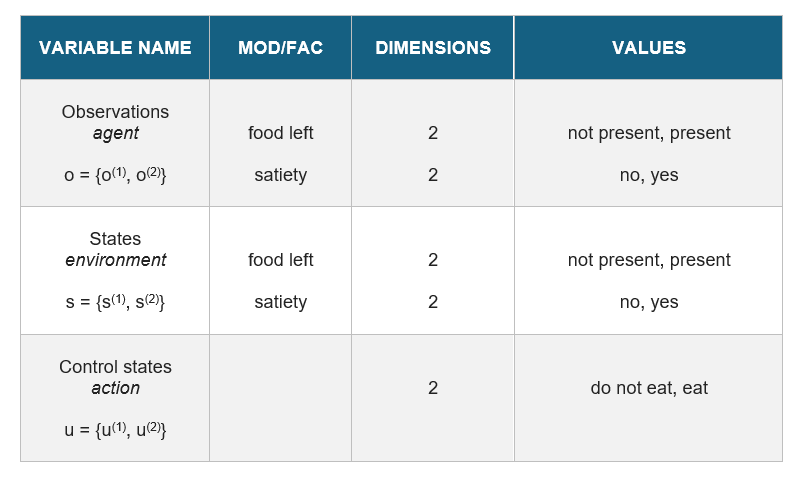

## **1.1. Generative model**

In [ ]:
# observations
obs_food = ['not present', 'present']
obs_satiety = ['no', 'yes']

# states
s_food = ['not present', 'present']
s_satiety = ['no', 'yes']

# controls
choice = ['do not eat', 'eat']

In [ ]:
# observation modality dimensions
num_obs = [len(obs_food), len(obs_satiety)]

# hidden state factors and dimensions
num_states = [len(s_food), len(s_satiety)]
num_factors = [len(num_states)]
num_controls = [2,2] # the same action has influence on both state, so the total num_controls is a list of two 2

# control state factor dimensions
num_control_factors = [len(choice)]

In [ ]:
num_factors

[2]

In [ ]:
num_obs

[2, 2]

In [ ]:
num_states

[2, 2]

In [ ]:
num_controls

[2, 2]

### Observation model (Perception) - *A matrix*
---

P (O|S)

x = State 0 food left

y = obs

z = State 1 satiety


In [ ]:
# one array for each obs
# the matrix has 2 rows (obs), 2 columns (state 0 type), 2 slices (state 1 type)

A = utils.initialize_empty_A(num_obs, num_states)

#### Food left observation





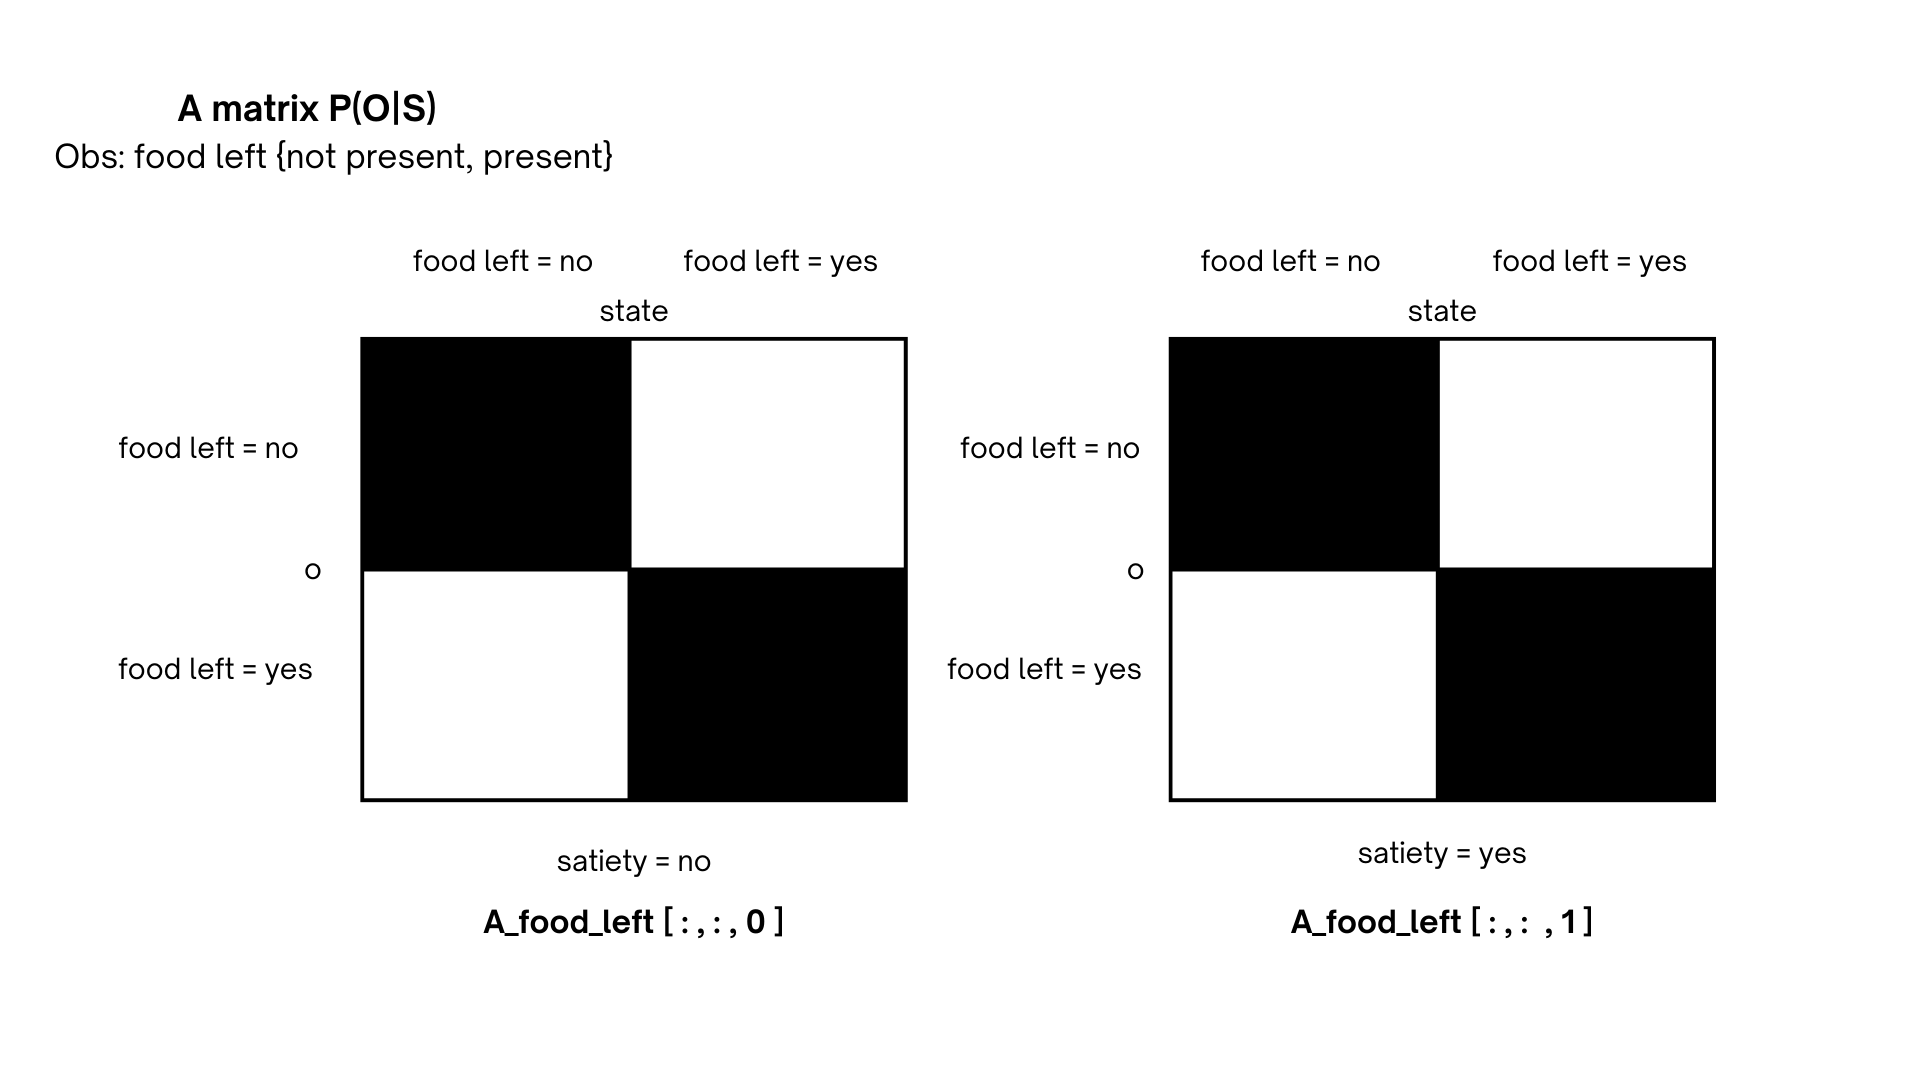

Both identities: food observation is the same with respect to food state.

In [ ]:
A_food_left = np.zeros((len(obs_food), len(s_food), len(s_satiety)))

In [ ]:
# State satiety = no -> A_food_left[:,:,0]

# index 1: obs food, index 2: state food, index 3: state satiety

# Obs food left = no (0), state food = not present (0), state satiety = no (0) should be 100% prob
A_food_left[0,0,0] = 1.0
print(A_food_left)

# Obs food left = yes (1), state food = not present (0), state satiety = no (0) should be 0%
A_food_left[1,0,0] = 0.0

# Obs food left = no (0), state food = present (1), state satiety = no (0) should be 0%
A_food_left[0,1,0] = 0.0

# Obs food left = yes (1), state food = present (1), state satiety = no (0) should be 100%
A_food_left[1,1,0] = 1.0

[[[1. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]]


In [ ]:
print(A_food_left[1,0,0])

0.0


In [ ]:
A_food_left[:,:,0]

array([[1., 0.],
       [0., 1.]])

In [ ]:
# State satiety = yes -> A_food_left[:,:,1]

# Obs food left = no (0), state food = not present (0), state satiety = yes (1)
A_food_left[0,0,1] = 1.0

# Obs food left = yes (1), state food = not present (0), state satiety = yes (1) should be 0%
A_food_left[1,0,1] = 0.0

# Obs food left = no (0), state food = present (1), state satiety = yes (0) should be 0%
A_food_left[0,1,1] = 0.0

# Obs food left = yes (1), state food = present (1), state satiety = yes (1)
A_food_left[1,1,1] = 1.0

In [ ]:
A_food_left[:,:,1]

array([[1., 0.],
       [0., 1.]])

In [ ]:
A[0] = A_food_left

In [ ]:
A[0]

array([[[1., 1.],
        [0., 0.]],

       [[0., 0.],
        [1., 1.]]])

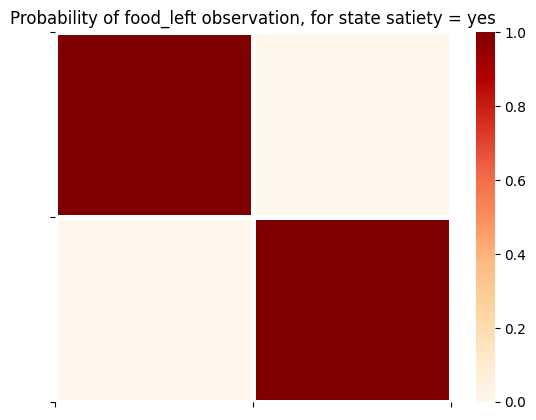

In [ ]:
utils.plot_likelihood(A[0][:,:,1], title = 'Probability of food_left observation, for state satiety = yes')

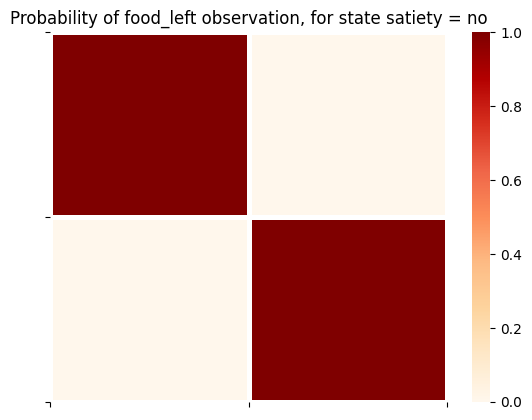

In [ ]:
utils.plot_likelihood(A[0][:,:,0], title = 'Probability of food_left observation, for state satiety = no')

It is an identity, since the food left obs does not depend on satiety.

#### Satiety observation


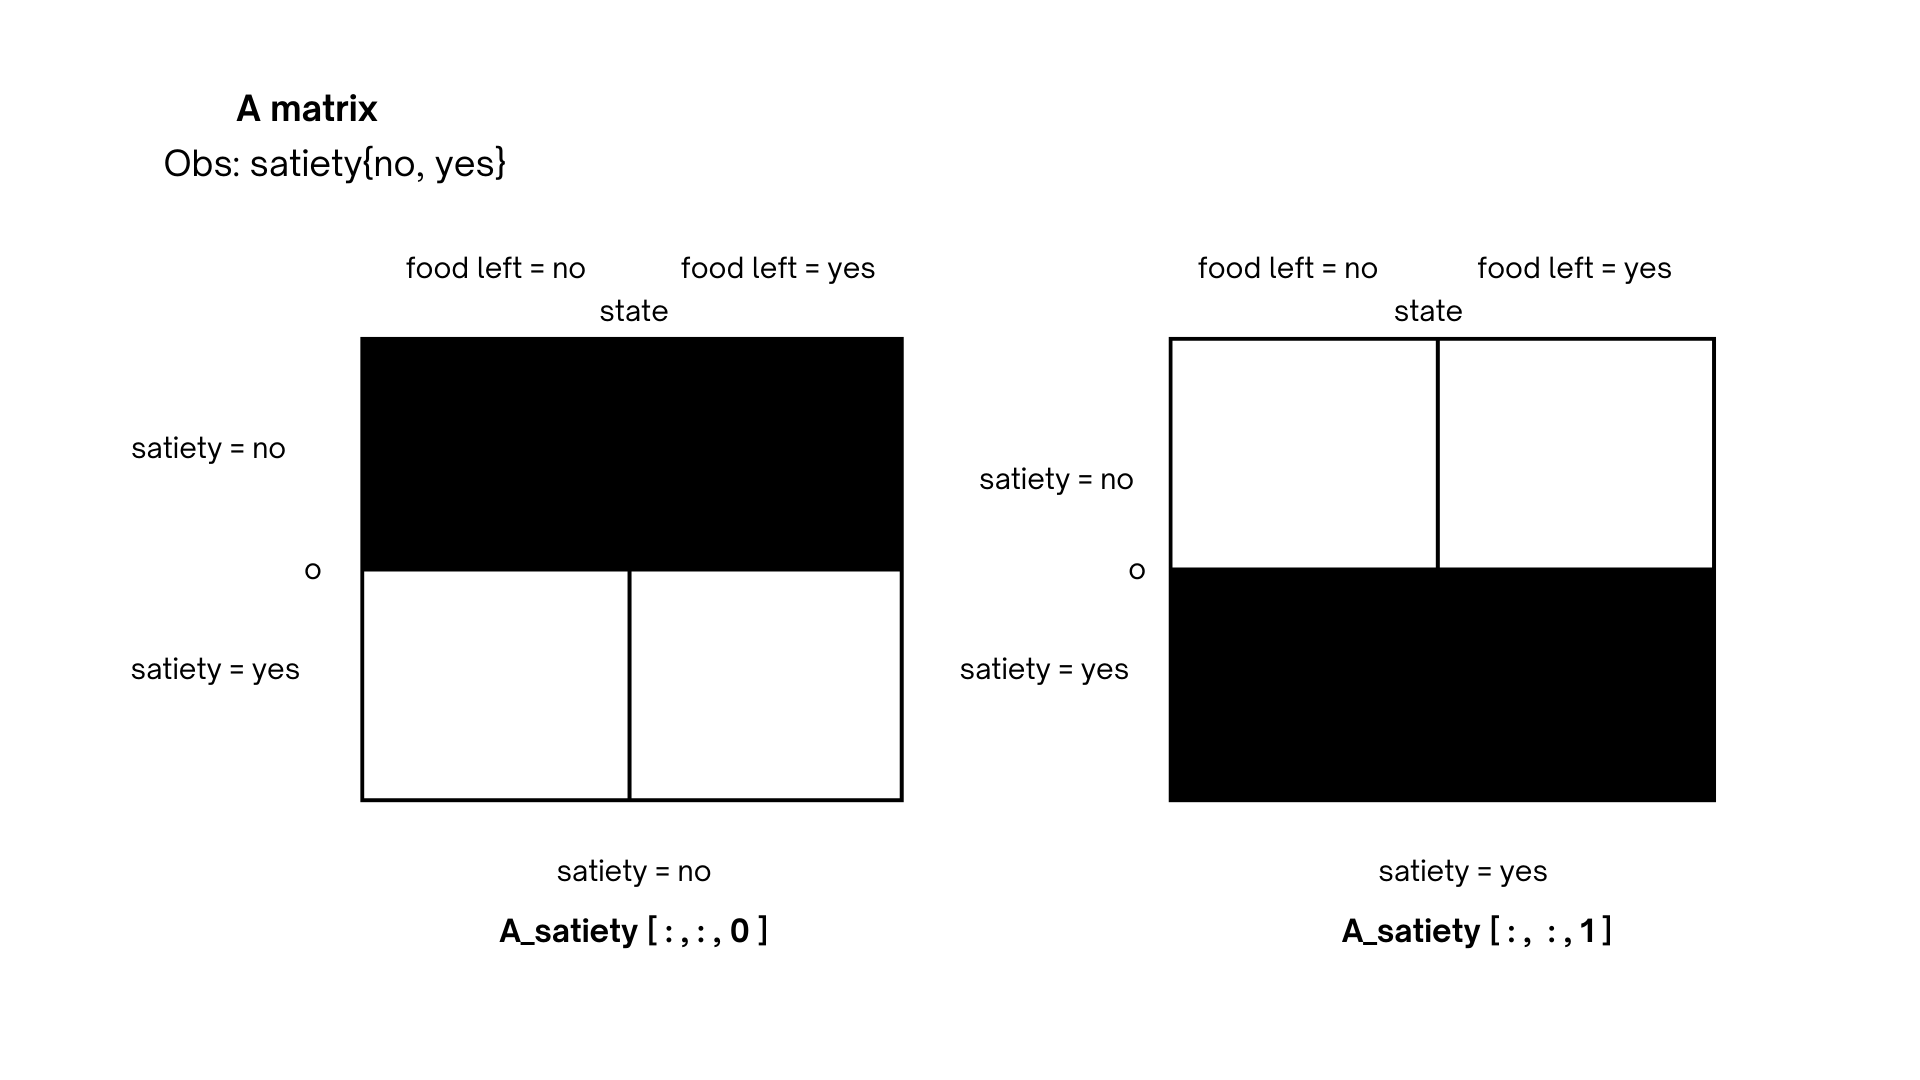

The agent is always hungry/not hungry, not depending on the observation of food.

In [ ]:
A_satiety = np.zeros((len(obs_satiety), len(s_food), len(s_satiety)))

In [ ]:
# State satiety = no -> A_satiety[:,:,0]
# State satiety = yes -> A_satiety[:,:,1]

# Obs satiety = no (0), state food = not present/present, state satiety = no (0)
A_satiety[0,:,0] = 1.0

# Obs satiety = yes (1), state food = not present/present, state satiety = no (0)
A_satiety[1,:,0] = 0.0

# Obs satiety = no (0), state food = not present/present, state satiety = yes (1)
A_satiety[0,:,1] = 0.0

# Obs satiety = yes (1), state food = not present/present, state satiety = yes (1)
A_satiety[1,:,1] = 1.0

In [ ]:
 A_satiety[:,:,0] # satiety = no

array([[1., 1.],
       [0., 0.]])

In [ ]:
A_satiety[:,:,1] # satiety = yes

array([[0., 0.],
       [1., 1.]])

In [ ]:
A_satiety[:,0,:]  # food = not present
                  # this should be identity

array([[1., 0.],
       [0., 1.]])

In [ ]:
A_satiety[:,1,:] # # food = present
                 # this should be identity

array([[1., 0.],
       [0., 1.]])

In [ ]:
A_satiety

array([[[1., 0.],
        [1., 0.]],

       [[0., 1.],
        [0., 1.]]])

In [ ]:
 A[1] = A_satiety

In [ ]:
A[1]

array([[[1., 0.],
        [1., 0.]],

       [[0., 1.],
        [0., 1.]]])

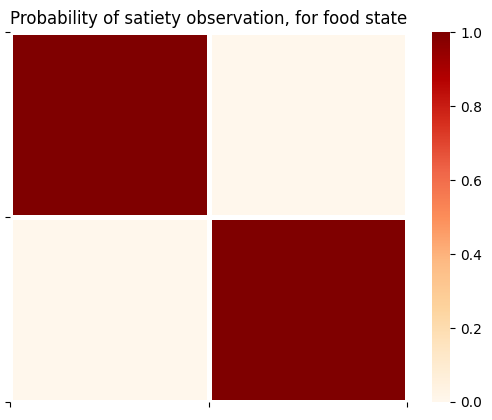

In [ ]:
utils.plot_likelihood(A[1][:,0,:], title = 'Probability of satiety observation, for food state')
                                   # this should be identity

The above are identity, since if food is not present the satiety is the same.

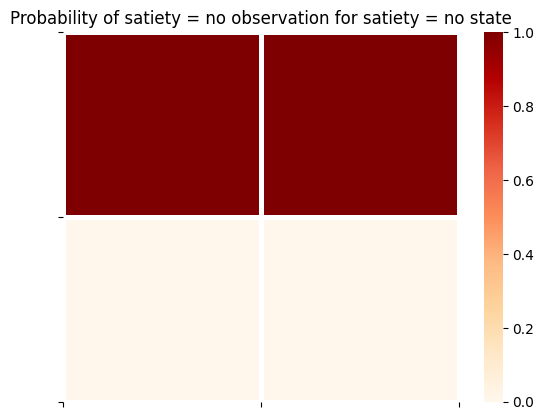

In [ ]:
utils.plot_likelihood(A[1][:,:,0], title = 'Probability of satiety = no observation for satiety = no state')

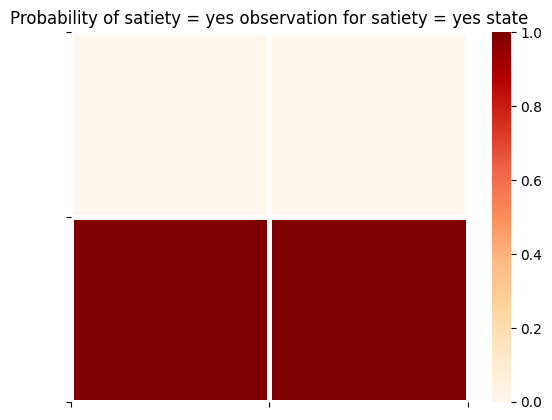

In [ ]:
utils.plot_likelihood(A[1][:,:,1], title = 'Probability of satiety = yes observation for satiety = yes state')

The agent is hungry/full when satiety state is no/yes, regardless food left.

In [ ]:
A

array([array([[[1., 1.],
               [0., 0.]],

              [[0., 0.],
               [1., 1.]]]), array([[[1., 0.],
                                    [1., 0.]],

                                   [[0., 1.],
                                    [0., 1.]]])], dtype=object)

In [ ]:
type(A)

numpy.ndarray

In [ ]:
A[0]

array([[[1., 1.],
        [0., 0.]],

       [[0., 0.],
        [1., 1.]]])

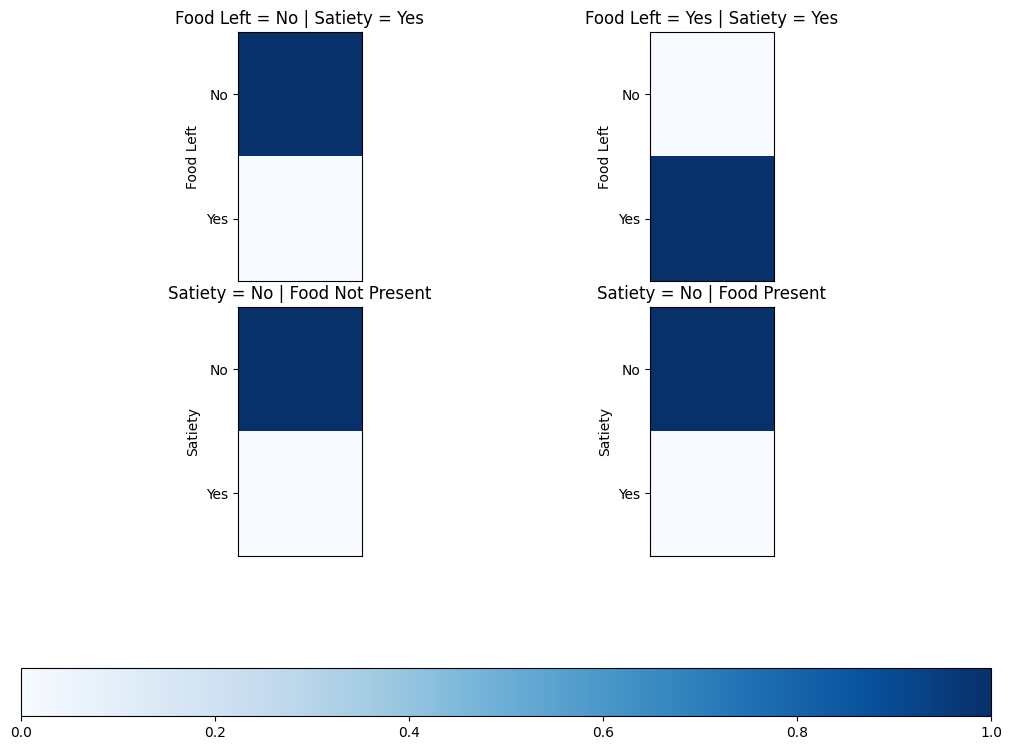

In [ ]:
# Plot both A_food_left and A_satiety together
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Titles for subplots
titles = ['Food Left = No | Satiety = Yes', 'Food Left = Yes | Satiety = Yes',
          'Satiety = No | Food Not Present', 'Satiety = No | Food Present']

# Plot for A_food_left
for i in range(2):
    im = axes[0, i].imshow(A_food_left[:, i, 1].reshape(2, 1), cmap='Blues', vmin=0, vmax=1)
    axes[0, i].set_title(titles[i])
    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([0, 1])
    axes[0, i].set_yticklabels(['No', 'Yes'])
    axes[0, i].set_ylabel('Food Left')

# Plot for A_satiety
for i in range(2):
    im = axes[1, i].imshow(A_satiety[:, i, 0].reshape(2, 1), cmap='Blues', vmin=0, vmax=1)
    axes[1, i].set_title(titles[i+2])
    axes[1, i].set_xticks([])
    axes[1, i].set_yticks([0, 1])
    axes[1, i].set_yticklabels(['No', 'Yes'])
    axes[1, i].set_ylabel('Satiety')

fig.tight_layout()
plt.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal')
plt.show()

### Transition model (Planning) - *B matrix*
----

P(St|St-1, Ut-1)

x = State t-1

y = State t

z = Control state

---

We set the matrices so that the the environment does not change, and food is always present. Since there is not learning on the B matrix, this will not affect the AIF loop.

In [ ]:
num_states

[2, 2]

In [ ]:
# we need one slice matrix for each state
# we have the same number for actions and states (2)
# transition depends on the current state only: for each action we have a matrix that describes the prob of moving from each state to every other state

B = utils.initialize_empty_B(num_states, num_states)

In [ ]:
B

array([array([[[0., 0.],
               [0., 0.]],

              [[0., 0.],
               [0., 0.]]]), array([[[0., 0.],
                                    [0., 0.]],

                                   [[0., 0.],
                                    [0., 0.]]])], dtype=object)

#### Food left state

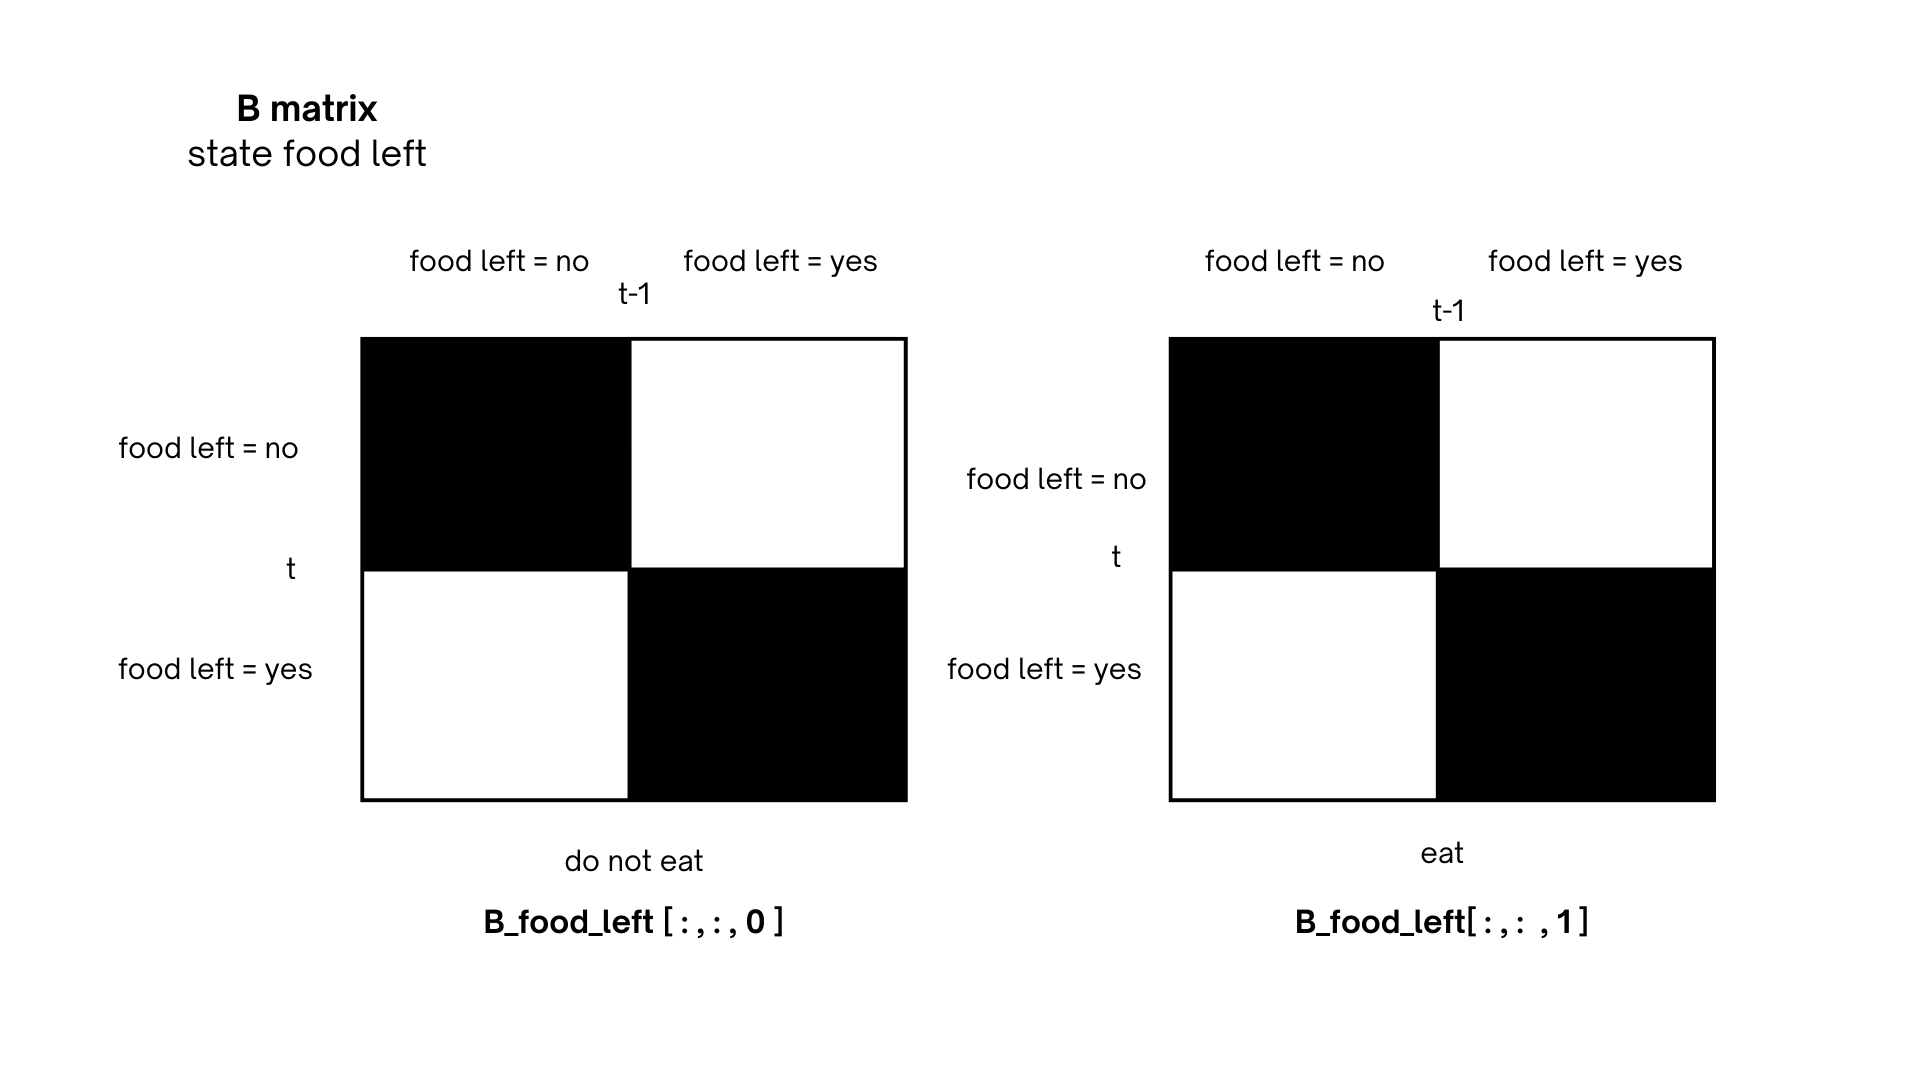

Both identities: food is always present, so there are no changes despite eating or not.

In [ ]:
B_food_left = np.zeros( (len(s_food), len(s_food), len(choice)) )

In [ ]:
# Action = do not eat -> B_food_left[:,:,0]
# Action = eat -> B_food_left[:,:,1]

# index 1: state t, index 2: state t-1, index 3: action

# state t: food left = no (0), state t-1: food left = no (0), action = eat/not eat 100% prob
B_food_left[0,0,:] = 1.0

# state t: food left = yes (1), state t-1: food = no (0), action: eat/not eat 0%
B_food_left[1,0,:] = 0.0

# state t: food left = no (0), state t-1: food = yes (1), action: eat/not eat 0%
B_food_left[0,1,:] = 0.0

# state t: food left = yes (1), state t-1: food = yes (1), action: eat/not eat should be 100%
B_food_left[1,1,:] = 1.0

In [ ]:
B_food_left[:,:,0]

array([[1., 0.],
       [0., 1.]])

In [ ]:
B[0] = B_food_left

In [ ]:
def plot_likelihoodB(matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, cmap="Oranges", cbar=True)
    plt.title(title)
    plt.xlabel("State t-1")
    plt.ylabel("State t")
    plt.show()

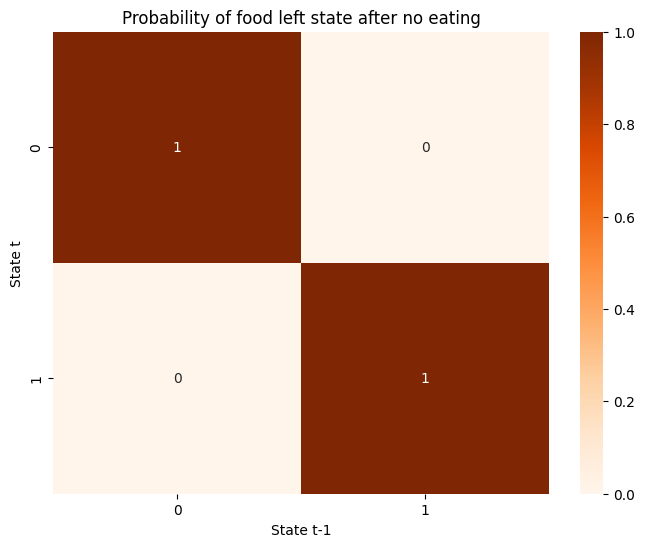

In [ ]:
plot_likelihoodB(B[0][:,:,0], title = 'Probability of food left state after no eating' )

In [ ]:
B_food_left[:,:,1]

array([[1., 0.],
       [0., 1.]])

In [ ]:
B[0]

array([[[1., 1.],
        [0., 0.]],

       [[0., 0.],
        [1., 1.]]])

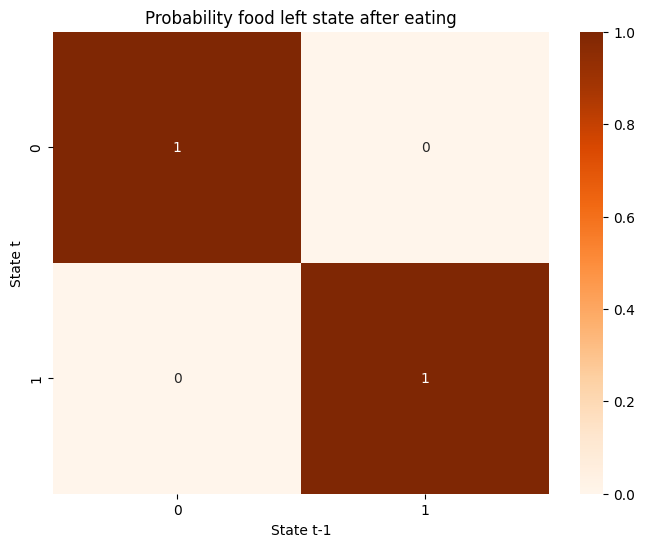

In [ ]:
plot_likelihoodB(B[0][:,:,1], title = 'Probability food left state after eating' )

#### Satiety state

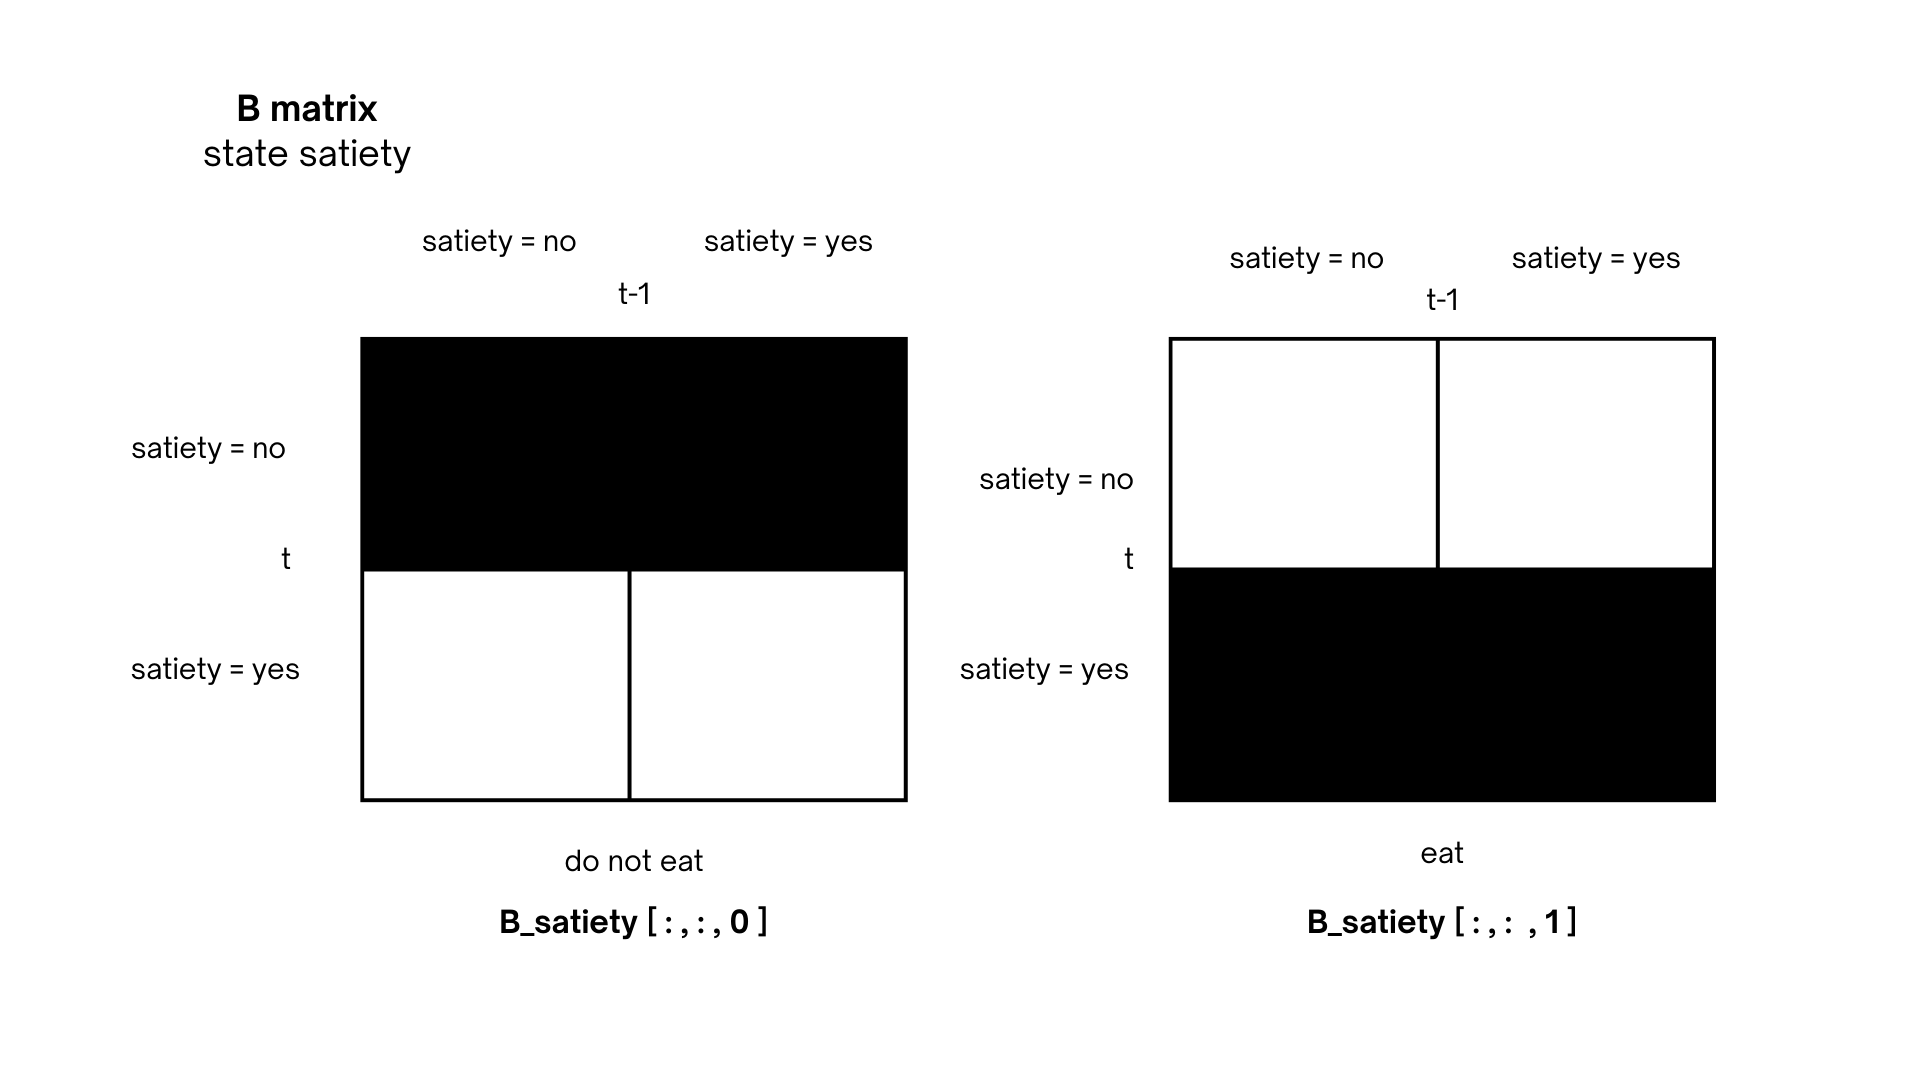

The agent is always hungry (satiety = no) after no eating and always full (satiety = yes) after eating.

In [ ]:
B_satiety = np.zeros( (len(s_satiety), len(s_satiety), len(choice)))

In [ ]:
# Action = do not eat -> B_satiety[:,:,0]
# Action = eat -> B_satiety[:,:,1]

#F index 1: state t, index 2: state t-1, index 3: action

# State t: satiety = no (0), state t-1: satiety = yes/no, action = do not eat (0)
B_satiety[0,:,0] = 1.0

# State t: satiety = yes (1), state t-1: satiety = yes/no, action: do not eat (0) should be 0%
B_satiety[1,:,0] = 0.0 # chances of being full when not  eating regardless of starting state is 0

# State t: satiety = no (0), state t-1: satiety = yes/no, action: do not eat (0) should be 0%
B_satiety[0,:,1] = 0.0

# State t: satiety = yes (1), state t-1: satiety = yes/no, action: do not eat (0) should be 100%
B_satiety[1,:,1] = 1.0 # chances of being full when eating regardless of starting state is 1

In [ ]:
B[1] = B_satiety

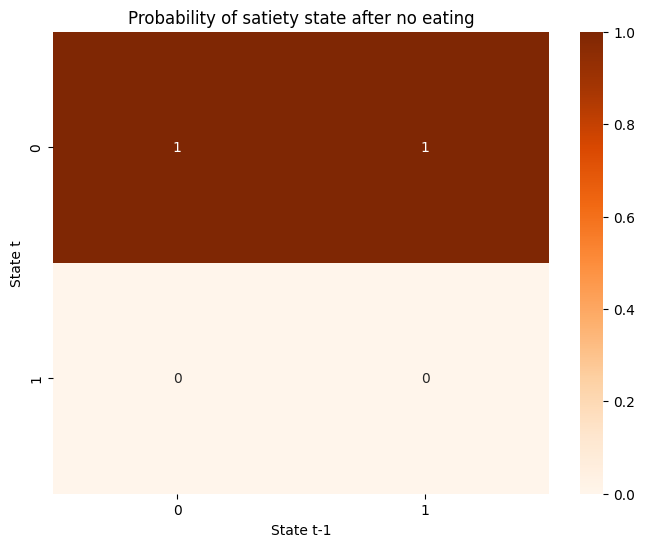

In [ ]:
# chances of being full when not  eating regardless of starting state is
plot_likelihoodB(B[1][:,:,0], title = 'Probability of satiety state after no eating')

In [ ]:
B_satiety[:,:,1]

array([[0., 0.],
       [1., 1.]])

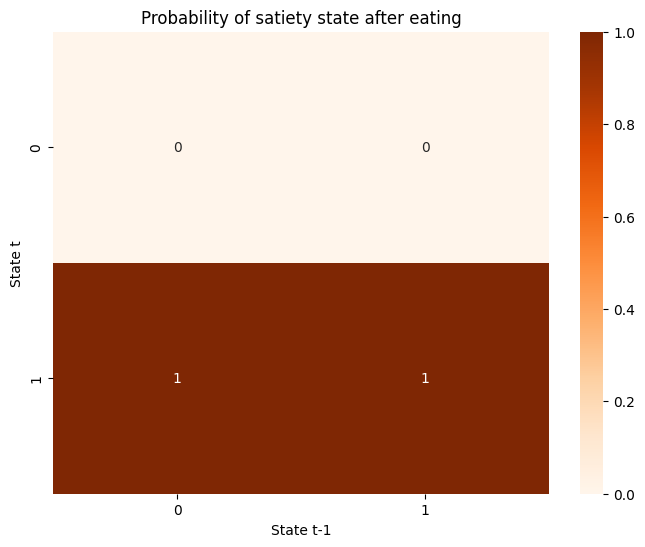

In [ ]:
# chances of being full when eating regardless of starting state is 1

plot_likelihoodB(B[1][:,:,1], title = 'Probability of satiety state after eating' )

In [ ]:
B

array([array([[[1., 1.],
               [0., 0.]],

              [[0., 0.],
               [1., 1.]]]), array([[[1., 0.],
                                    [1., 0.]],

                                   [[0., 1.],
                                    [0., 1.]]])], dtype=object)

In [ ]:
type(B)

numpy.ndarray

In [ ]:
# check if the matrix is normalised
# Sum the probabilities across the first axis (observation probabilities for each state)
sums = B.sum(axis=0)
sums = B[1].sum(axis=0)

# Check if all sums are close to 1.0
if np.allclose(sums, 1.0):
    print("The matrix is properly normalised.")
else:
    print("The matrix is not normalised. Sums:", sums)

print("Is the B matrix normalised?", utils.is_normalized(B))

The matrix is properly normalised.
Is the B matrix normalised? True


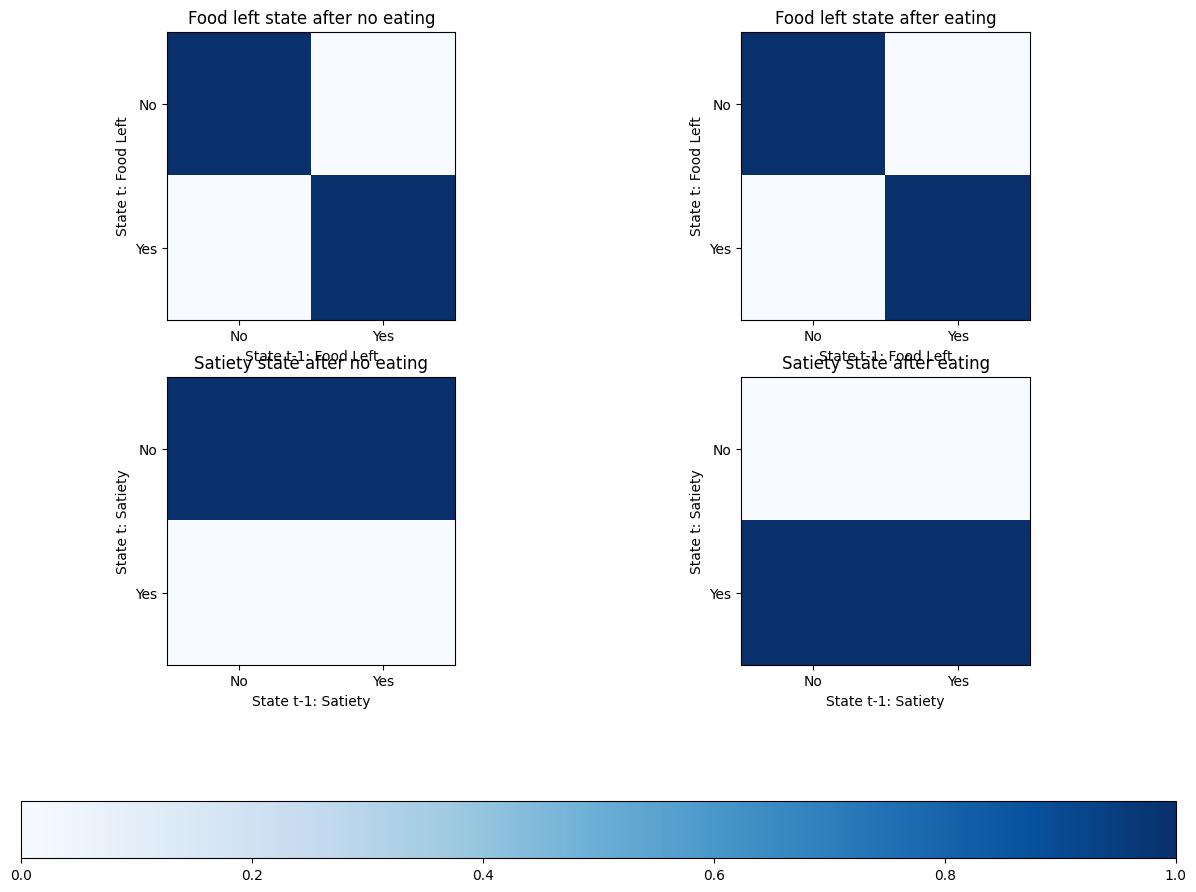

In [ ]:
# plot both B_food_left and B_satiety together

# Titles for each subplot
titles = [
    "Food left state after no eating",
    "Food left state after eating",
    "Satiety state after no eating",
    "Satiety state after eating"
]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
action_labels = ['Do Not Eat', 'Eat']

for i in range(2):
    im = axes[0, i].imshow(B_food_left[:, :, i], cmap='Blues', vmin=0, vmax=1)
    axes[0, i].set_title(titles[i])
    axes[0, i].set_xticks([0, 1])
    axes[0, i].set_yticks([0, 1])
    axes[0, i].set_xticklabels(['No', 'Yes'])
    axes[0, i].set_yticklabels(['No', 'Yes'])
    axes[0, i].set_xlabel('State t-1: Food Left')
    axes[0, i].set_ylabel('State t: Food Left')

    im = axes[1, i].imshow(B_satiety[:, :, i], cmap='Blues', vmin=0, vmax=1)
    axes[1, i].set_title(titles[i + 2])
    axes[1, i].set_xticks([0, 1])
    axes[1, i].set_yticks([0, 1])
    axes[1, i].set_xticklabels(['No', 'Yes'])
    axes[1, i].set_yticklabels(['No', 'Yes'])
    axes[1, i].set_xlabel('State t-1: Satiety')
    axes[1, i].set_ylabel('State t: Satiety')

fig.tight_layout()
plt.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal')
plt.show()


In [ ]:
print(B[1].shape)

(2, 2, 2)


### Prior preferences - *C vector*


We set an agent that has a strong preference for being full (*satiety* = yes) and *food_left* = present.

In [ ]:
# create prior preferences over observations (C vector)
# our agent has a strong preference for obs satiety = yes

C = utils.obj_array_zeros([num_obs])

In [ ]:
# Define preferences for each observation modality
# index 1: mod not present/no, index 2: mod present/yes C[0][:,1] C[1][:,1]

C_food_left = np.array([0.0, 20.0])  # preference for the observation modality of food present
C_satiety = np.array([0.0, 20.0])  # preference for the observation modality of satiety

# create an object array to hold each modality's preferences
C = np.empty(2, dtype=object)
C[0] = C_food_left
C[1] = C_satiety

In [ ]:
C

array([array([ 0., 20.]), array([ 0., 20.])], dtype=object)

In [ ]:
len(C)

2

In [ ]:
type(C)

numpy.ndarray

In [ ]:
print("C vector:", C)
for i, pref in enumerate(C):
    print(f"Preferences for modality {i}: {pref}") #modality 0: food_left; 1: satiety

C vector: [array([ 0., 20.]) array([ 0., 20.])]
Preferences for modality 0: [ 0. 20.]
Preferences for modality 1: [ 0. 20.]


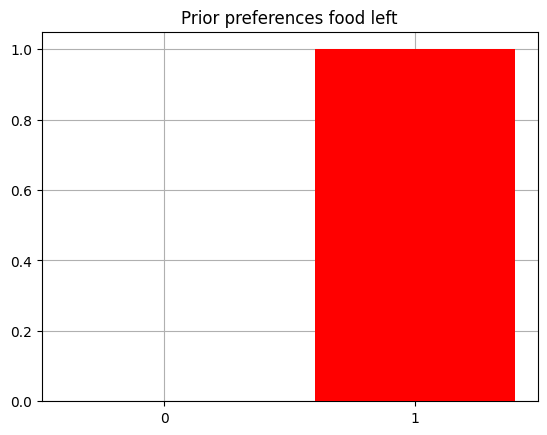

In [ ]:
utils.plot_beliefs(softmax(C[0]), title = "Prior preferences food left")

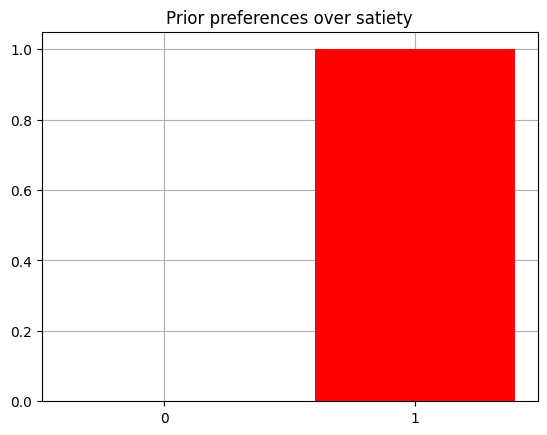

In [ ]:
utils.plot_beliefs(softmax(C[1]), title = "Prior preferences over satiety")

Following *D vector* for initial beliefs is superfluous/could mess thing up

In [ ]:
# specify prior over hidden states (D vector)

# D = utils.obj_array(num_factors)

# we set at t = 0 strong beliefs over hidden state food left = yes D[0][:,1] and satiety = no D[1][0,:]

# D_food_left = np.array([0.0, 20.0])
# D_satiety = np.array([20.0, 0.0])

# create an object array to hold each modality's preferences
#D = np.empty(2, dtype=object)
#D[0] = D_food_left
#D[1] = D_satiety

#utils.plot_beliefs(softmax(D[0]), title = "Initial beliefs about probability of food left state")

## **1.2 Generative Process**

### Agent

We set the agents beliefs matching the actual structure of the environment: food present and satiety no

In [ ]:
my_agent = Agent(A=A, B=B, C=C, policies=None, action_selection="stochastic") # we do not pass D vector, it is flat

In [ ]:
my_agent.B

array([array([[[1., 1.],
               [0., 0.]],

              [[0., 0.],
               [1., 1.]]]), array([[[1., 0.],
                                    [1., 0.]],

                                   [[0., 1.],
                                    [0., 1.]]])], dtype=object)

In [ ]:
my_agent.policy_len #for case 2 agent should be 3

1

In [ ]:
my_agent.policies

[array([[0, 0]]), array([[0, 1]]), array([[1, 0]]), array([[1, 1]])]

In [ ]:
my_agent.policies=[np.array([[0,0]]),np.array([[1,1]])] # we need to change the policies, from 4 to 2, so that the agent takes one action only on the two obs modalities
my_agent.E = my_agent._construct_E_prior() # we adjust the E matrix size after having changed policies

In [ ]:
my_agent.policies

[array([[0, 0]]), array([[1, 1]])]

In [ ]:
A[1]

array([[[1., 0.],
        [1., 0.]],

       [[0., 1.],
        [0., 1.]]])

In [ ]:
B

array([array([[[1., 1.],
               [0., 0.]],

              [[0., 0.],
               [1., 1.]]]), array([[[1., 0.],
                                    [1., 0.]],

                                   [[0., 1.],
                                    [0., 1.]]])], dtype=object)

In [ ]:
C

array([array([ 0., 20.]), array([ 0., 20.])], dtype=object)

### Environment and AIF loop

In [ ]:
from pymdp.envs import Env

In [ ]:
# class for the room environment (generative process)
class room_Env(Env):

    def __init__(self):

        # initial states
        self.state_food = 1 # food present
        self.state_satiety = 0 # no satiety

    def step(self, action):
        """
        Updates the environment state based on the agent's action and returns the observation.

        :param action: int, the action taken by the agent, 0 for 'do not eat', 1 for 'eat'
        :return: tuple, (observation_food, observation_satiety)
        """
        print(action)
        if action == 0:  # do not eat
            # state does not change
            self.state_food = 1
            self.state_satiety = 0

        elif action == 1 and self.state_food == 1: # eat
            # food is always 'present', satiety 'yes'
            self.state_food = 1
            self.state_satiety=1

        elif action == 1 and self.state_food == 0:
            self.state_food = 0
            self.state_satiety = 0


        # mapping states to observations
        obs_food = self.state_food  # directly use the state as observation
        obs_satiety = self.state_satiety

        obs = [obs_food, obs_satiety]

        return obs

# function to restart the loop
    def reset(self):
        # reset the environment to the initial state
        self.state_food = 1 #food left present
        self.state_satiety = 0 #no satiety

        states = [self.state_food, self.state_satiety]

        return states

In [ ]:
# initialize lists to store data
actions = []
observations = []
qs_values = []

env = room_Env()

T = 4  # number of timesteps

# initialize or reset the environment
current_state = env.reset()

# initialize the agent or ensure all necessary internal states are set
my_agent.reset()

for t in range(T):


    # current observation from the environment

    observation = env.step(action) if t > 0 else current_state  # initial state for the first observation

    # update the agent's belief about the current state based on the observation
    qs = my_agent.infer_states(observation)  # update state beliefs

    # infer policies based on the updated beliefs
    my_agent.infer_policies() # it is expected to get 4 values but changed agent policies to get just 2 values

    # debugging print to ensure the agent is ready to sample an action
    print("Agent's internal state (posterior over policies - q_pi):", getattr(my_agent, 'q_pi', 'Attribute not set'))

    # sample the next action from the inferred policies
    action = my_agent.sample_action()

# print action to check its structure
    print("Sampled action output:", action)
    #print("Type of action:", type(action))
    #print("Shape of action:", np.shape(action))

    # handle action based on its type and structure
    if isinstance(action, np.ndarray) and action.size == 1:
        action = int(action.item())  # convert single-item array to integer
    elif isinstance(action, np.ndarray) and action.ndim > 0:
        print("Action array elements:", action)
        action = int(action[0])  # select the first action if multiple are given
    else:
        print("Unexpected action format. Terminating loop.")
        break

        # Store data for this timestep
    actions.append(action)
    observations.append(observation)
    qs_values.append(qs)

    # results for this timestep
    print(f"Time step {t}, Action taken: {action}, Observation: {observation}")
    print()

Agent's internal state (posterior over policies - q_pi): [1.06112398e-139 1.00000000e+000]
Sampled action output: [1. 1.]
Action array elements: [1. 1.]
Time step 0, Action taken: 1, Observation: [1, 0]

1
Agent's internal state (posterior over policies - q_pi): [1.06112398e-139 1.00000000e+000]
Sampled action output: [1. 1.]
Action array elements: [1. 1.]
Time step 1, Action taken: 1, Observation: [1, 1]

1
Agent's internal state (posterior over policies - q_pi): [1.06112398e-139 1.00000000e+000]
Sampled action output: [1. 1.]
Action array elements: [1. 1.]
Time step 2, Action taken: 1, Observation: [1, 1]

1
Agent's internal state (posterior over policies - q_pi): [1.06112398e-139 1.00000000e+000]
Sampled action output: [1. 1.]
Action array elements: [1. 1.]
Time step 3, Action taken: 1, Observation: [1, 1]



In [ ]:
print(observation) # index 1: food left; index 2: satiety

[1, 1]


### Results plot

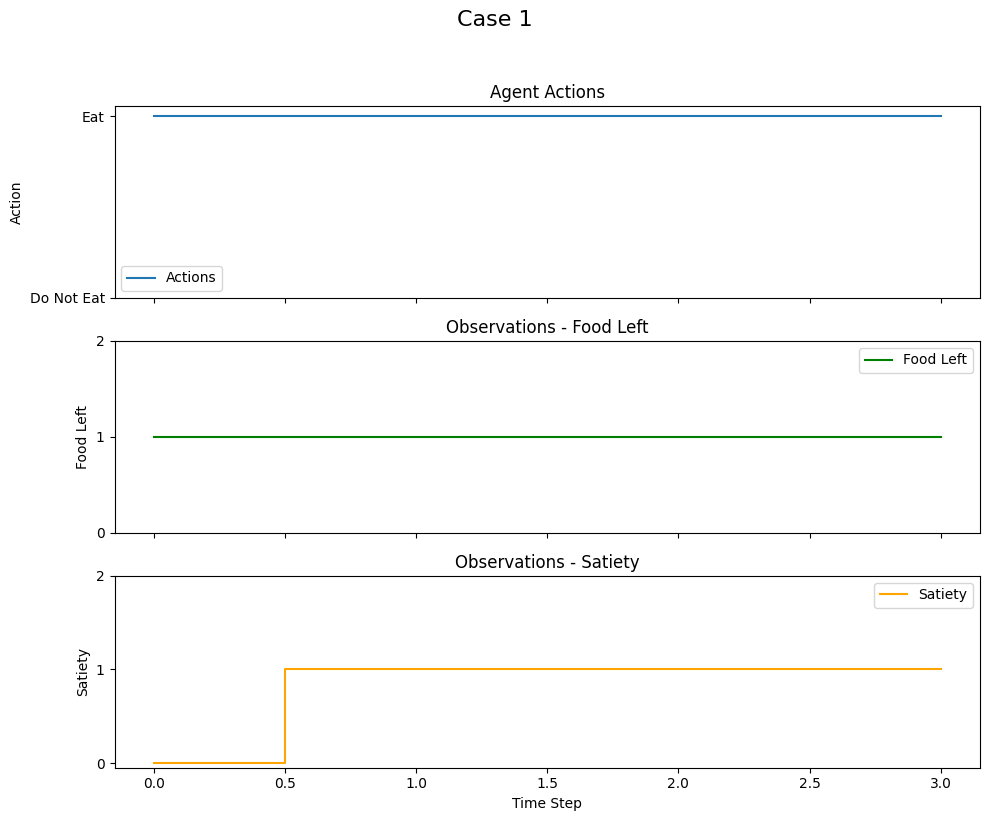

In [ ]:
# Plot the results
time_steps = range(T)

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Plotting actions
axs[0].step(time_steps, actions, where='mid', label='Actions')
axs[0].set_ylabel("Action")
axs[0].set_title("Agent Actions")
axs[0].set_yticks([0, 1])
axs[0].set_yticklabels(["Do Not Eat", "Eat"])
axs[0].legend()

# Extracting and plotting observations
obs_food = [obs[0] for obs in observations]
obs_satiety = [obs[1] for obs in observations]

axs[1].step(time_steps, obs_food, where='mid', label='Food Left', color='green')
axs[1].set_ylabel("Food Left")
axs[1].set_title("Observations - Food Left")
axs[1].set_yticks([0, 1, 2])
axs[1].legend()

axs[2].step(time_steps, obs_satiety, where='mid', label='Satiety', color='orange')
axs[2].set_ylabel("Satiety")
axs[2].set_title("Observations - Satiety")
axs[2].set_yticks([0, 1, 2])
axs[2].legend()

plt.xlabel("Time Step")
plt.tight_layout()

fig.suptitle("Case 1", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.9)


plt.show()

As expected, the agent keeps eating, the food is always available and satiety = yes.

## **1.3 Extending results**

### *1.3.1 Wrong matrices*
Now we set wrong matrices to check whether the agents keeps eating despite them. We make them incorrect by swapping probabilities.

 **Observation model (Perception) - A matrix**

*Food left observation*





In [ ]:
A1 = utils.initialize_empty_A(num_obs, num_states)

In [ ]:
A1[0] = np.copy(A_food_left)

In [ ]:
A_food_left_wrong = A1[0]

In [ ]:
# we introduce some noise in the matrix

A_food_left_wrong[0, 0, 0] = 0.0
A_food_left_wrong[1, 0, 0] = 1.0  # Wrong observation probability
A_food_left_wrong[0, 1, 0] = 1.0
A_food_left_wrong[1, 1, 0] = 0.0  # Wrong observation probability

In [ ]:
print(A_food_left_wrong[1,0,0])

1.0


In [ ]:
A_food_left_wrong[:,:,0]

array([[0., 1.],
       [1., 0.]])

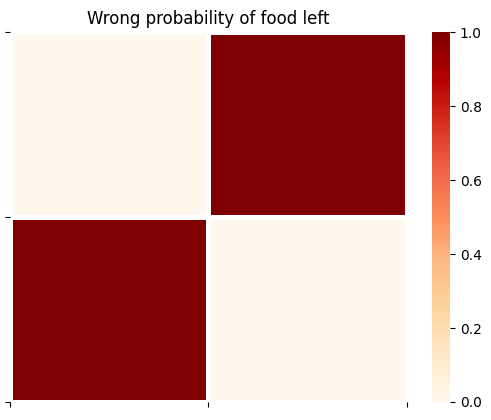

In [ ]:
utils.plot_likelihood(A1[0][:,:,0], title = 'Wrong probability of food left')

*Satiety observation*


In [ ]:
A1[1] = np.copy(A_satiety)

In [ ]:
A_satiety_wrong = A1[1]

In [ ]:
A_satiety_wrong[0, :, 0] = 0.0
A_satiety_wrong[1, :, 0] = 1.0  # Wrong observation probability

In [ ]:
A_satiety_wrong[:,:,0]

array([[0., 0.],
       [1., 1.]])

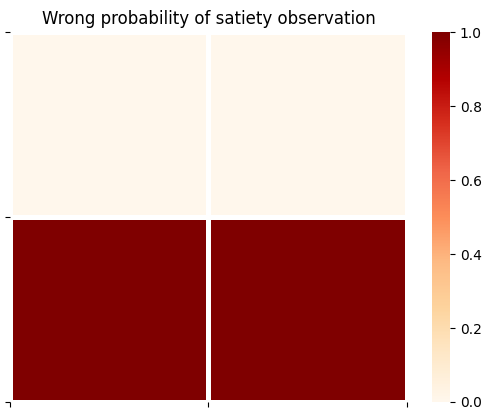

In [ ]:
utils.plot_likelihood(A1[1][:,:,0], title = 'Wrong probability of satiety observation')


**Transition model (Planning) - B matrix**

In [ ]:
B1 = utils.initialize_empty_B(num_obs, num_states)

*Food left state*

In [ ]:
B1[0] = np.copy(B_food_left)

In [ ]:
B_food_left_wrong = B1[0]

In [ ]:
# Introduce noise into the transition matrix
B_food_left_wrong[0, 0, 0] = 0.5
B_food_left_wrong[1, 0, 0] = 0.5  # Wrong transition probability
B_food_left_wrong[0, 1, 0] = 0.5
B_food_left_wrong[1, 1, 0] = 0.5  # Wrong transition probability

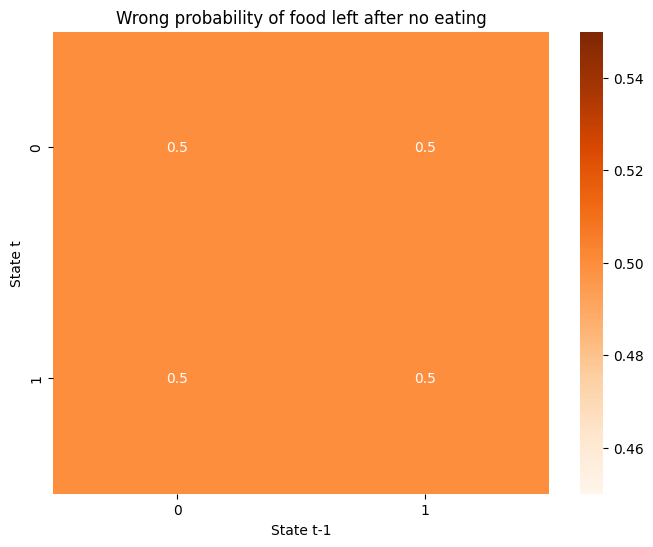

In [ ]:
plot_likelihoodB(B1[0][:,:,0], title = 'Wrong probability of food left after no eating')

*Satiety state*

In [ ]:
B1[1] = np.copy(B_satiety)

In [ ]:
B_satiety_wrong = B1[1]

In [ ]:
B_satiety_wrong[0, 0, 0] = 0.5
B_satiety_wrong[1, 0, 0] = 0.5  # Wrong transition probability

In [ ]:
B_satiety_wrong[:,:,0]

array([[0.5, 1. ],
       [0.5, 0. ]])

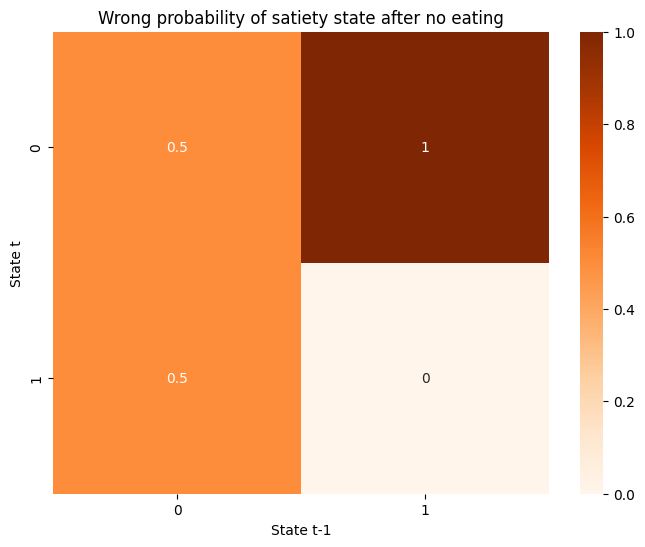

In [ ]:
plot_likelihoodB(B1[1][:,:,0], title = 'Wrong probability of satiety state after no eating')


We set a new agent

In [ ]:
my_w_agent = Agent(A=A1, B=B1, C=C, policies=None, action_selection="stochastic") # we do not pass D vector, it is flatten

In [ ]:
my_w_agent.policies

[array([[0, 0]]), array([[0, 1]]), array([[1, 0]]), array([[1, 1]])]

In [ ]:
my_w_agent.policies=[np.array([[0,0]]),np.array([[1,1]])]
my_w_agent.E = my_w_agent._construct_E_prior()

In [ ]:
my_w_agent.policies

[array([[0, 0]]), array([[1, 1]])]

**AIF loop**

The environment is the same as main case1, so now we change the agent in the AIF loop only.

In [ ]:
# initialize lists to store data
actions = []
observations = []
qs_values = []

env = room_Env()

T = 4  # number of timesteps

# initialize or reset the environment
current_state = env.reset()

# initialize the agent or ensure all necessary internal states are set
my_w_agent.reset()

for t in range(T):


    # current observation from the environment

    observation = env.step(action) if t > 0 else current_state  # initial state for the first observation

    # update the agent's belief about the current state based on the observation
    qs = my_w_agent.infer_states(observation)  # update state beliefs

    # infer policies based on the updated beliefs
    my_w_agent.infer_policies() # it is expected to get 4 values but changed agent policies to get just 2 values

    # debugging print to ensure the agent is ready to sample an action
    print("Agent's internal state (posterior over policies - q_pi):", getattr(my_agent, 'q_pi', 'Attribute not set'))

    # sample the next action from the inferred policies
    action = my_w_agent.sample_action()

# print action to check its structure
    print("Sampled action output:", action)
    #print("Type of action:", type(action))
    #print("Shape of action:", np.shape(action))

    # handle action based on its type and structure
    if isinstance(action, np.ndarray) and action.size == 1:
        action = int(action.item())  # convert single-item array to integer
    elif isinstance(action, np.ndarray) and action.ndim > 0:
        print("Action array elements:", action)
        action = int(action[0])  # select the first action if multiple are given
    else:
        print("Unexpected action format. Terminating loop.")
        break

        # Store data for this timestep
    actions.append(action)
    observations.append(observation)
    qs_values.append(qs)

    # results for this timestep
    print(f"Time step {t}, Action taken: {action}, Observation: {observation}")
    print()

Agent's internal state (posterior over policies - q_pi): [1.06112398e-139 1.00000000e+000]
Sampled action output: [1. 1.]
Action array elements: [1. 1.]
Time step 0, Action taken: 1, Observation: [1, 0]

1
Agent's internal state (posterior over policies - q_pi): [1.06112398e-139 1.00000000e+000]
Sampled action output: [1. 1.]
Action array elements: [1. 1.]
Time step 1, Action taken: 1, Observation: [1, 1]

1
Agent's internal state (posterior over policies - q_pi): [1.06112398e-139 1.00000000e+000]
Sampled action output: [1. 1.]
Action array elements: [1. 1.]
Time step 2, Action taken: 1, Observation: [1, 1]

1
Agent's internal state (posterior over policies - q_pi): [1.06112398e-139 1.00000000e+000]
Sampled action output: [1. 1.]
Action array elements: [1. 1.]
Time step 3, Action taken: 1, Observation: [1, 1]



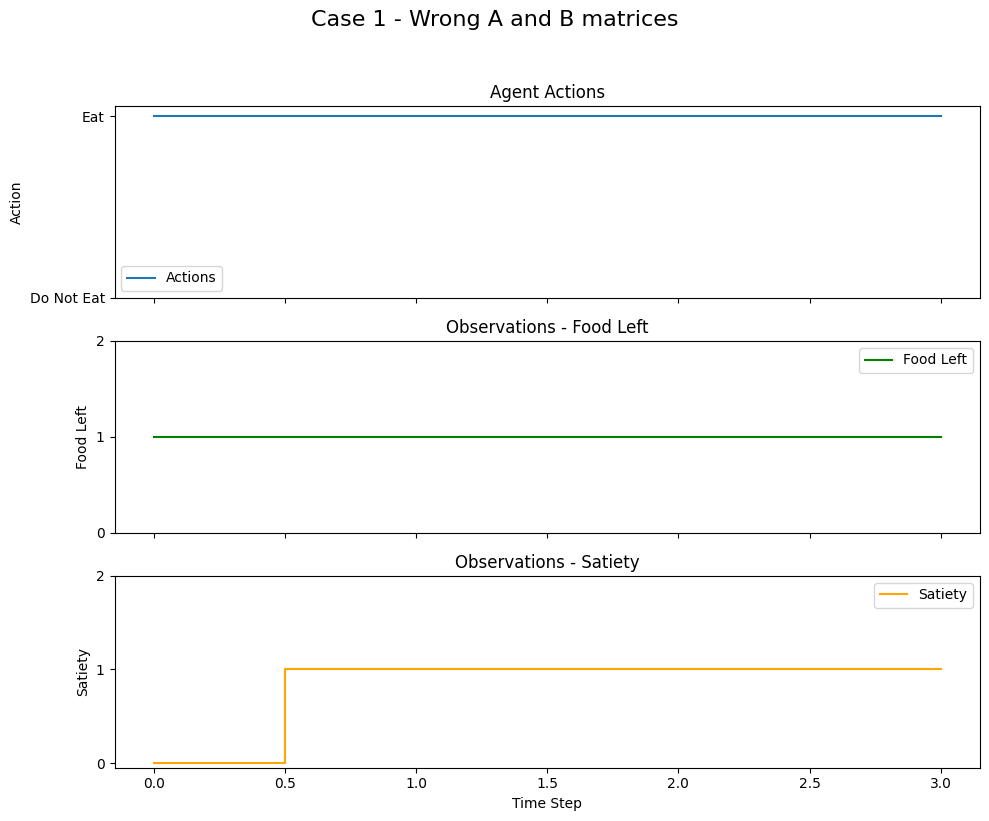

In [ ]:
# Plot the results
time_steps = range(T)

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Plotting actions
axs[0].step(time_steps, actions, where='mid', label='Actions')
axs[0].set_ylabel("Action")
axs[0].set_title("Agent Actions")
axs[0].set_yticks([0, 1])
axs[0].set_yticklabels(["Do Not Eat", "Eat"])
axs[0].legend()

# Extracting and plotting observations
obs_food = [obs[0] for obs in observations]
obs_satiety = [obs[1] for obs in observations]

axs[1].step(time_steps, obs_food, where='mid', label='Food Left', color='green')
axs[1].set_ylabel("Food Left")
axs[1].set_title("Observations - Food Left")
axs[1].set_yticks([0, 1, 2])
axs[1].legend()

axs[2].step(time_steps, obs_satiety, where='mid', label='Satiety', color='orange')
axs[2].set_ylabel("Satiety")
axs[2].set_title("Observations - Satiety")
axs[2].set_yticks([0, 1, 2])
axs[2].legend()

plt.xlabel("Time Step")
plt.tight_layout()

fig.suptitle("Case 1 - Wrong A and B matrices", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.9)
plt.show()


Despite the wrong matrices, the agent still prefers to continue eating. (This actually changes with respect to different runs)

### *1.3.2 Different prior preferences*
Now we set an agent that has a strong preference for being full only (*satiety* = yes) and does not care if food is present or not.

In [ ]:
# create prior preferences over observations (C vector)
# our agent has a strong preference for obs satiety = yes

C1 = utils.obj_array_zeros([num_obs])

In [ ]:
# Define preferences for each observation modality
# index 1: mod not present/no, index 2: mod present/yes C[0][:,1] C[1][:,1]

C1_food_left = np.array([0.0, 0.0])  # before we had 0.20 for obs mod food present, now we set flat preference
C1_satiety = np.array([0.0, 20.0])  # preference for the observation modality of satiety

# create an object array to hold each modality's preferences
C1 = np.empty(2, dtype=object)
C1[0] = C1_food_left
C1[1] = C1_satiety

In [ ]:
C1

array([array([0., 0.]), array([ 0., 20.])], dtype=object)

In [ ]:
len(C1)

2

In [ ]:
type(C1)

numpy.ndarray

In [ ]:
print("New C vector:", C1)
for i, pref in enumerate(C1):
    print(f"Preferences for modality {i}: {pref}") #modality 0: food_left; 1: satiety

New C vector: [array([0., 0.]) array([ 0., 20.])]
Preferences for modality 0: [0. 0.]
Preferences for modality 1: [ 0. 20.]


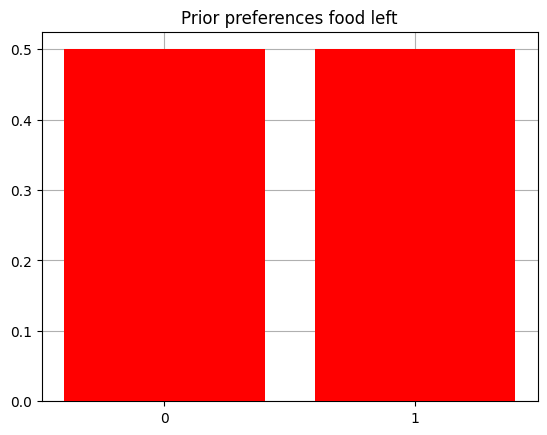

In [ ]:
utils.plot_beliefs(softmax(C1[0]), title = "Prior preferences food left")

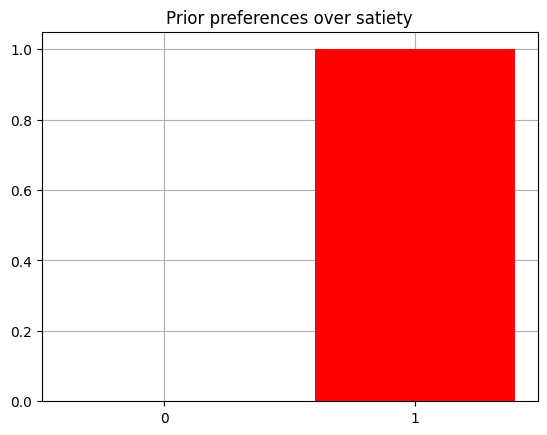

In [ ]:
utils.plot_beliefs(softmax(C1[1]), title = "Prior preferences over satiety")


We set a new agent

In [ ]:
my_agent1 = Agent(A=A, B=B, C=C1, policies=None, action_selection="stochastic") # we do not pass D vector, it is flat

In [ ]:
C1

array([array([0., 0.]), array([ 0., 20.])], dtype=object)

In [ ]:
my_agent1.policies

[array([[0, 0]]), array([[0, 1]]), array([[1, 0]]), array([[1, 1]])]

In [ ]:
my_agent1.policies=[np.array([[0,0]]),np.array([[1,1]])]
my_agent1.E = my_agent1._construct_E_prior()

In [ ]:
my_agent1.policies

[array([[0, 0]]), array([[1, 1]])]

**AIF loop**

The environment is the same as main case1, so now we change the agent in the AIF loop only.

In [ ]:
# initialize lists to store data
actions = []
observations = []
qs_values = []

env = room_Env()

T = 4  # number of timesteps

# initialize or reset the environment
current_state = env.reset()

# initialize the agent or ensure all necessary internal states are set
my_agent1.reset()

for t in range(T):


    # current observation from the environment

    observation = env.step(action) if t > 0 else current_state  # initial state for the first observation

    # update the agent's belief about the current state based on the observation
    qs = my_agent1.infer_states(observation)  # update state beliefs

    # infer policies based on the updated beliefs
    my_agent1.infer_policies() # it is expected to get 4 values but changed agent policies to get just 2 values

    # debugging print to ensure the agent is ready to sample an action
    print("Agent's internal state (posterior over policies - q_pi):", getattr(my_agent, 'q_pi', 'Attribute not set'))

    # sample the next action from the inferred policies
    action = my_agent1.sample_action()

# print action to check its structure
    print("Sampled action output:", action)
    #print("Type of action:", type(action))
    #print("Shape of action:", np.shape(action))

    # handle action based on its type and structure
    if isinstance(action, np.ndarray) and action.size == 1:
        action = int(action.item())  # convert single-item array to integer
    elif isinstance(action, np.ndarray) and action.ndim > 0:
        print("Action array elements:", action)
        action = int(action[0])  # select the first action if multiple are given
    else:
        print("Unexpected action format. Terminating loop.")
        break

        # Store data for this timestep
    actions.append(action)
    observations.append(observation)
    qs_values.append(qs)

    # results for this timestep
    print(f"Time step {t}, Action taken: {action}, Observation: {observation}")
    print()

Agent's internal state (posterior over policies - q_pi): [1.06112398e-139 1.00000000e+000]
Sampled action output: [1. 1.]
Action array elements: [1. 1.]
Time step 0, Action taken: 1, Observation: [1, 0]

1
Agent's internal state (posterior over policies - q_pi): [1.06112398e-139 1.00000000e+000]
Sampled action output: [1. 1.]
Action array elements: [1. 1.]
Time step 1, Action taken: 1, Observation: [1, 1]

1
Agent's internal state (posterior over policies - q_pi): [1.06112398e-139 1.00000000e+000]
Sampled action output: [1. 1.]
Action array elements: [1. 1.]
Time step 2, Action taken: 1, Observation: [1, 1]

1
Agent's internal state (posterior over policies - q_pi): [1.06112398e-139 1.00000000e+000]
Sampled action output: [1. 1.]
Action array elements: [1. 1.]
Time step 3, Action taken: 1, Observation: [1, 1]



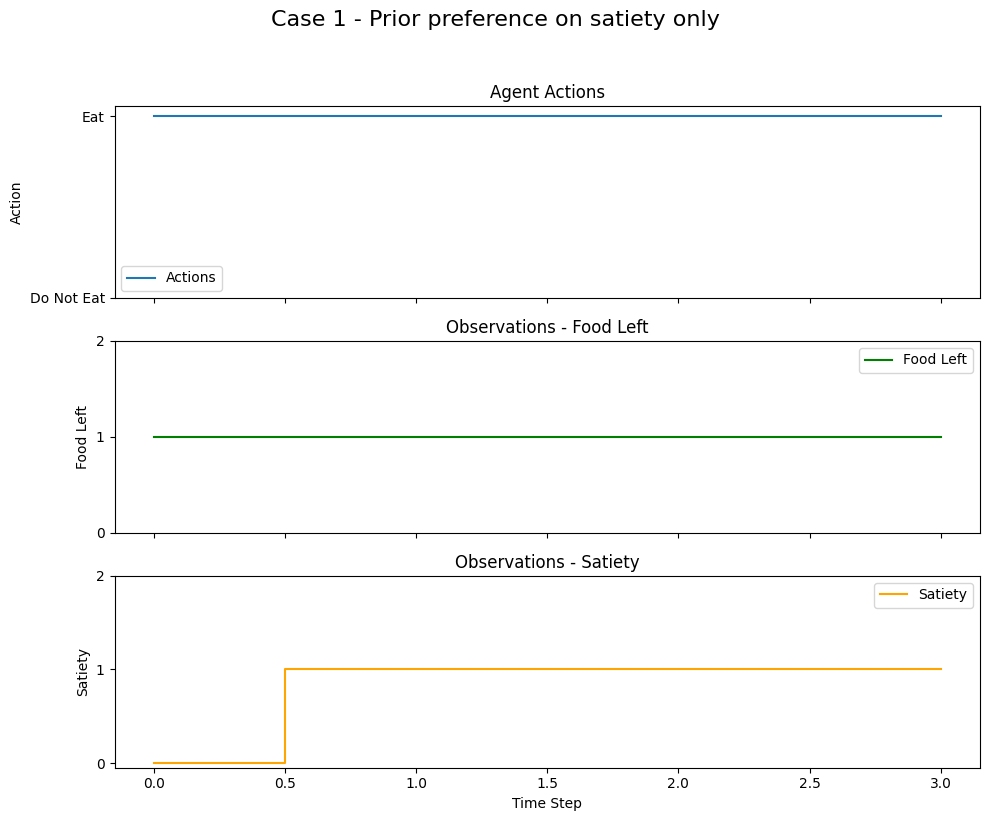

In [ ]:
# Plot the results
time_steps = range(T)

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Plotting actions
axs[0].step(time_steps, actions, where='mid', label='Actions')
axs[0].set_ylabel("Action")
axs[0].set_title("Agent Actions")
axs[0].set_yticks([0, 1])
axs[0].set_yticklabels(["Do Not Eat", "Eat"])
axs[0].legend()

# Extracting and plotting observations
obs_food = [obs[0] for obs in observations]
obs_satiety = [obs[1] for obs in observations]

axs[1].step(time_steps, obs_food, where='mid', label='Food Left', color='green')
axs[1].set_ylabel("Food Left")
axs[1].set_title("Observations - Food Left")
axs[1].set_yticks([0, 1, 2])
axs[1].legend()

axs[2].step(time_steps, obs_satiety, where='mid', label='Satiety', color='orange')
axs[2].set_ylabel("Satiety")
axs[2].set_title("Observations - Satiety")
axs[2].set_yticks([0, 1, 2])
axs[2].legend()

plt.xlabel("Time Step")
plt.tight_layout()

fig.suptitle("Case 1 - Prior preference on satiety only", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.9)
plt.show()


As before, nevertheless the agent has different prior preferences (we have set them just on satiety this time) it keeps eating.

# **2. Case 2**
-----
**Dynamic environment**: food is depleted if the agent eats, grows if it does not eat.The agent should learn how to not be greedy over time.
This might be done by giving more values to hidden states *food_left* and *satiety*.

Over successive timesteps, the agent updates its beliefs about the hidden states using its observations and the A matrix (perception). It then selects actions based on how it expects they will impact future states and observations, as captured in the B matrix (planning). By simulating this perception-action loop under the active inference framework, we can study the emergence of sustainable resource management strategies.

**Expected results**: the agent learns adjusting its eating
behavior according to the food replenishment rate. On the one way, consuming whenever food is present, may lead to periods of starvation. Not eating, on the other way, makes food increasing.
An optimal strategy would involve more conservative eating to sustain a steady level of satiety over time.


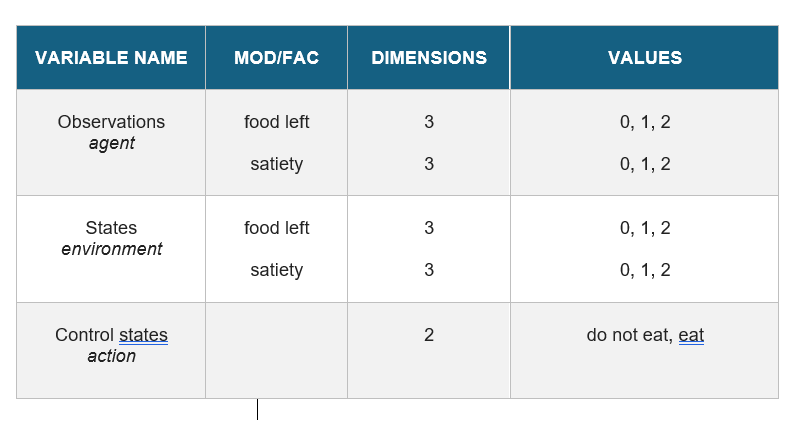

## **2.1 Generative model**

In [ ]:
# observations
obs_food2 = [0 , 1 , 2]
obs_satiety2 = [0 , 1 , 2]

# states
s_food2 = [0 , 1 , 2]
s_satiety2 = [0 , 1, 2]

In [ ]:
# observation modality dimensions
num_obs2 = [len(obs_food2), len(obs_satiety2)]

# hidden state factors and dimensions
num_states2 = [len(s_food2), len(s_satiety2)]
num_factors2 = [len(num_states2)]

In [ ]:
num_obs2

[3, 3]

In [ ]:
num_states2

[3, 3]

In [ ]:
# control state factor dimensions are the same as before
num_controls

[2, 2]

### Observation model (Perception) - *A matrix*

In [ ]:
A2 = utils.initialize_empty_A(num_obs2, num_states2)

#### Food left observation

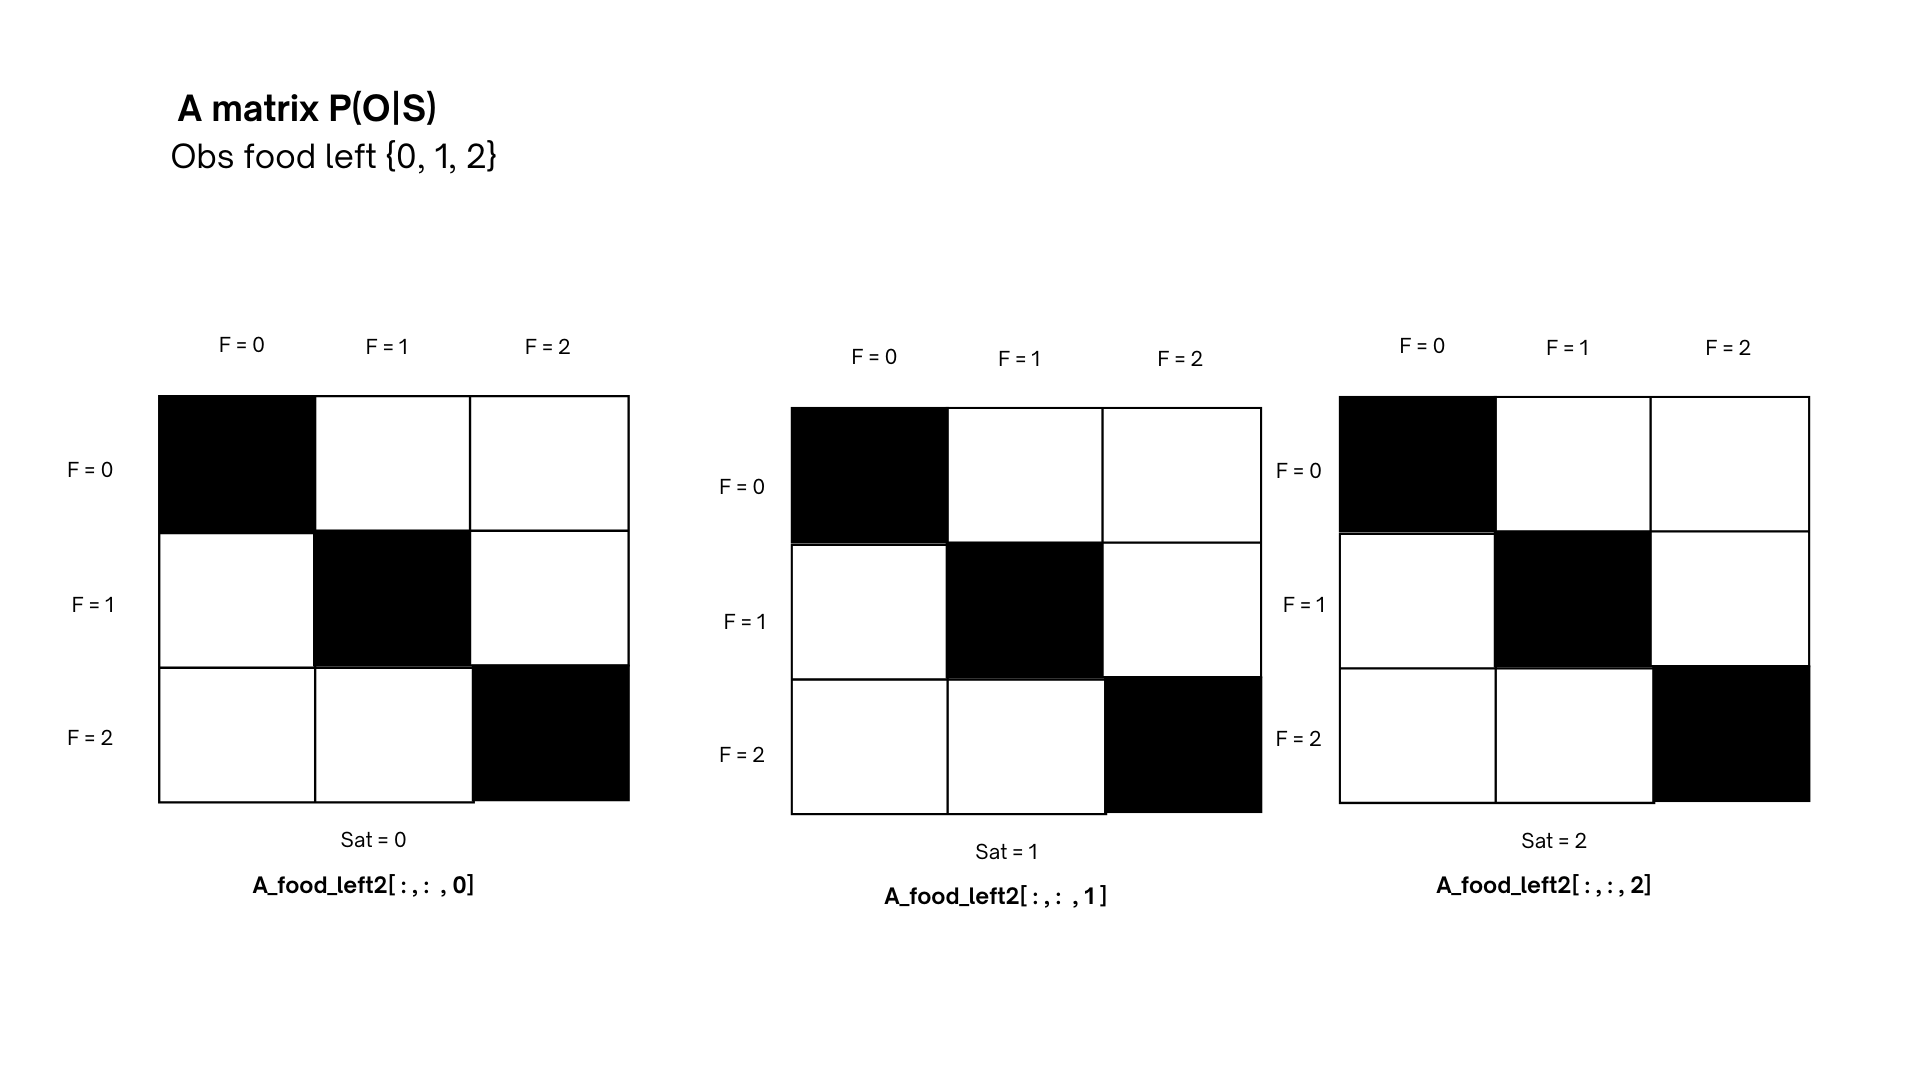

In [ ]:
A_food_left2 = np.zeros((len(obs_food2), len(s_food2), len(s_satiety2)))

In [ ]:
A_food_left2.shape

(3, 3, 3)

In [ ]:
# State satiety = 0 -> A_food_left2[:,:,0]

# index 1: obs food, index 2: state food, index 3: state satiety

# Obs food left = 0, state food = 0, state satiety = 0 should be 100% prob
A_food_left2[0,0,0] = 1.0

# Obs food left = 1, state food = 0, state satiety = 0 should be 0%
A_food_left2[1,0,0] = 0.0

# Obs food left = 2, state food = 0, satiety = 0
A_food_left2[2,0,0] = 0.0

# Obs food left = 0, state food = 1, state satiety = 0 should be 0%
A_food_left2[0,1,0] = 0.0

# Obs food left = 1, state food = 1, state satiety = 0 should be 100%
A_food_left2[1,1,0] = 1.0

#Obs food left = 2, state food = 1, satiety = 0
A_food_left2[2,1,0] = 0

#Obs food left = 2, state food = 2, satiety = 0
A_food_left2[2,2,0] = 1.0


In [ ]:
A_food_left2[:,:,0]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
# State satiety = 1 -> A_food_left2[:,:,1]

# Obs food left = 0, state food = 0, state satiety = 1 should be 100% prob
A_food_left2[0,0,1] = 1.0

# Obs food left = 1, state food = 0, state satiety = 1 should be 0%
A_food_left2[1,0,1] = 0.0

# Obs food left = 2, state food = 0, satiety = 1
A_food_left2[2,0,1] = 0.0

# Obs food left = 0, state food = 1, state satiety = 1 should be 0%
A_food_left2[0,1,1] = 0.0

# Obs food left = 1, state food = 1, state satiety = 1 should be 100%
A_food_left2[1,1,1] = 1.0

# Obs food left = 2, state food = 1, satiety = 1
A_food_left2[2,1,1] = 0

#Obs food left = 2, state food = 2, satiety = 1
A_food_left2[2,2,1] = 1.0

In [ ]:
A_food_left2[:,:,2]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [ ]:
# State satiety = 2 -> A_food_left2[:,:,2]


# Obs food left = 0, state food = 0, state satiety = 2 should be 100% prob
A_food_left2[0,0,2] = 1.0

# Obs food left = 1, state food = 0, state satiety = 2 should be 0%
A_food_left2[1,0,2] = 0.0

# Obs food left = 2, state food = 0, satiety = 2
A_food_left2[2,0,2] = 0.0

# Obs food left = 0, state food = 1, state satiety = 2 should be 0%
A_food_left2[0,1,2] = 0.0

# Obs food left = 1, state food = 1, state satiety = 2 should be 100%
A_food_left2[1,1,2] = 1.0

#Obs food left = 2, state food = 1, satiety = 2
A_food_left2[2,1,2] = 0

# Obs food left = 2, state food = 2, satiety = 2
A_food_left2[2,2,2] = 1.0

In [ ]:
A_food_left2[:,:,2]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
A2[0] = A_food_left2

In [ ]:
A2[0]

array([[[1., 1., 1.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [1., 1., 1.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [1., 1., 1.]]])

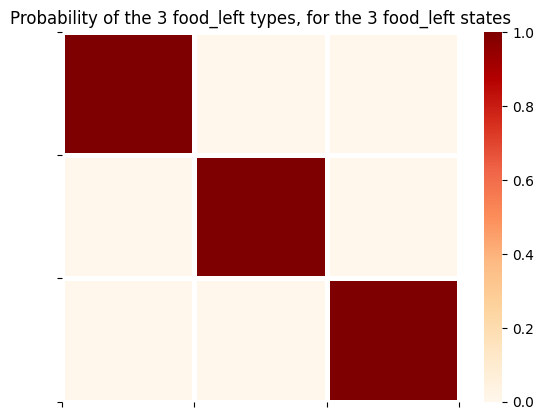

In [ ]:
utils.plot_likelihood(A2[0][:,:,2], title = 'Probability of the 3 food_left types, for the 3 food_left states')

#### Satiety observation


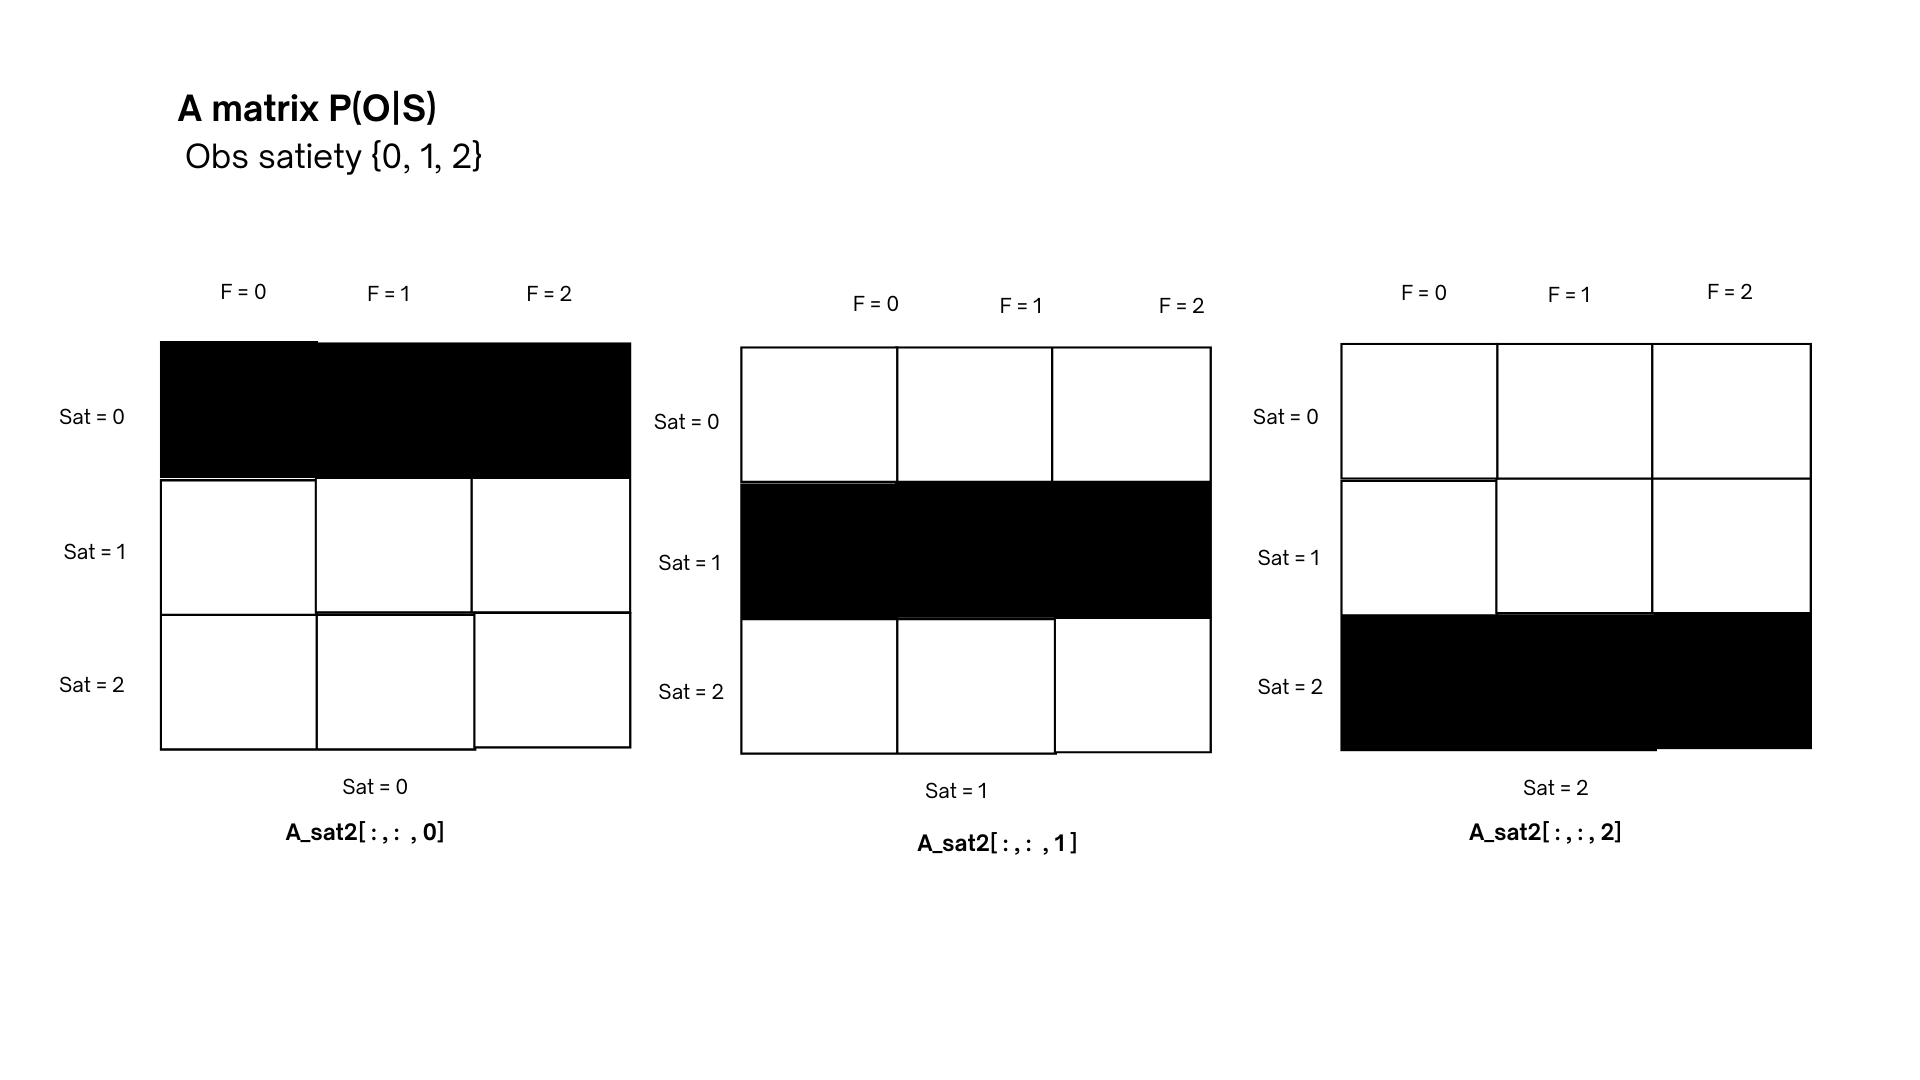

In [ ]:
A_satiety2 = np.zeros((len(obs_satiety2), len(s_food2), len(s_satiety2)))

In [ ]:
# State satiety = 0 -> A_satiety2[:,:,0]
# State satiety = 1 -> A_satiety2[:,:,1]
# State satiety = 2 -> A_satiety2[:,:,2]

# Obs satiety = 0, state food = 0/1/2, state satiety = 0
A_satiety2[0,:,0] = 1.0

A_satiety2[1,:,0] = 0.0

A_satiety2[2,:,0] = 0.0

# Obs satiety = 0, state food = 0/1/2, state satiety = 1
A_satiety2[0,:,1] = 0.0

A_satiety2[1,:,1] = 1.0

A_satiety2[2,:,1] = 0.0

# Obs satiety = 0, state food = 0/1/2, state satiety = 2
A_satiety2[0,:,2] = 0.0

A_satiety2[1,:,2] = 0.0

A_satiety2[2,:,2] = 1.0

In [ ]:
A_satiety2.shape

(3, 3, 3)

In [ ]:
A_satiety2[:,2,:]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
A2[1] = A_satiety2

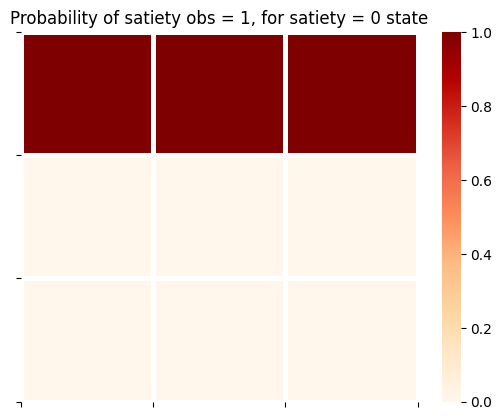

In [ ]:
utils.plot_likelihood(A2[1][:,:,0], title = 'Probability of satiety obs = 1, for satiety = 0 state')

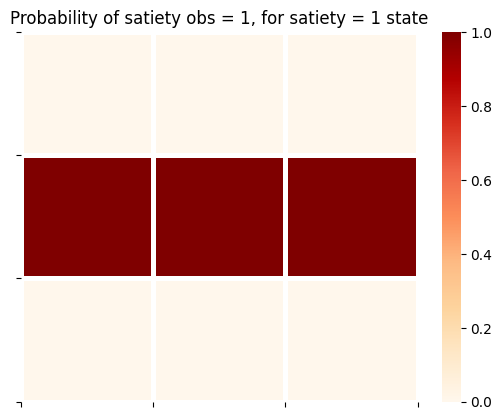

In [ ]:
utils.plot_likelihood(A2[1][:,:,1], title = 'Probability of satiety obs = 1, for satiety = 1 state')

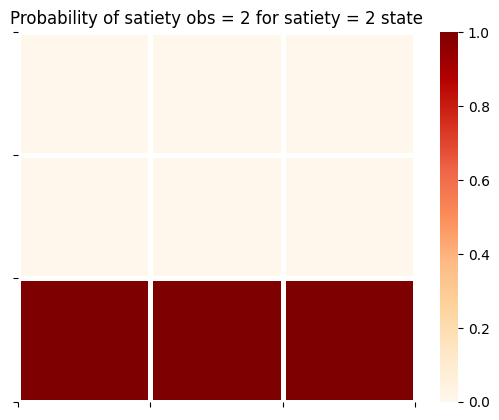

In [ ]:
utils.plot_likelihood(A2[1][:,:,2], title = 'Probability of satiety obs = 2 for satiety = 2 state')

Like above, the agent has satiety 0/1/2 when satiety state is 0/1/2, regardless food left.

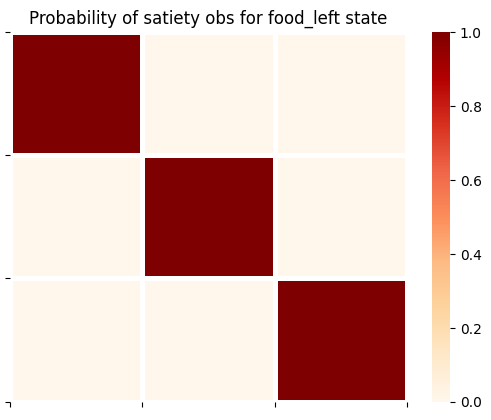

In [ ]:
utils.plot_likelihood(A2[1][:,2,:], title = 'Probability of satiety obs for food_left state')

### Transition model (Planning) - *B matrix*

B matrix is updated: eating when food is available leads to a satiated agent and no food. Not eating results in an increase of food and satiety. The agent must balance immediate satiety with long-term food availability.

In [ ]:
num_states2

[3, 3]

In [ ]:
num_controls

[2, 2]

In [ ]:
# B_factor_list says the states each state depends on
# index 1: food left state only depends on food left state [0]; index 2: satiety depends on both food left and satiety states [0,1]
B2_factor_list = [[0], [0,1]] # we add an extra dim to the matrix for satiety state

B2 = utils.random_B_matrix(num_states2, num_controls, B2_factor_list)

#### Food left state

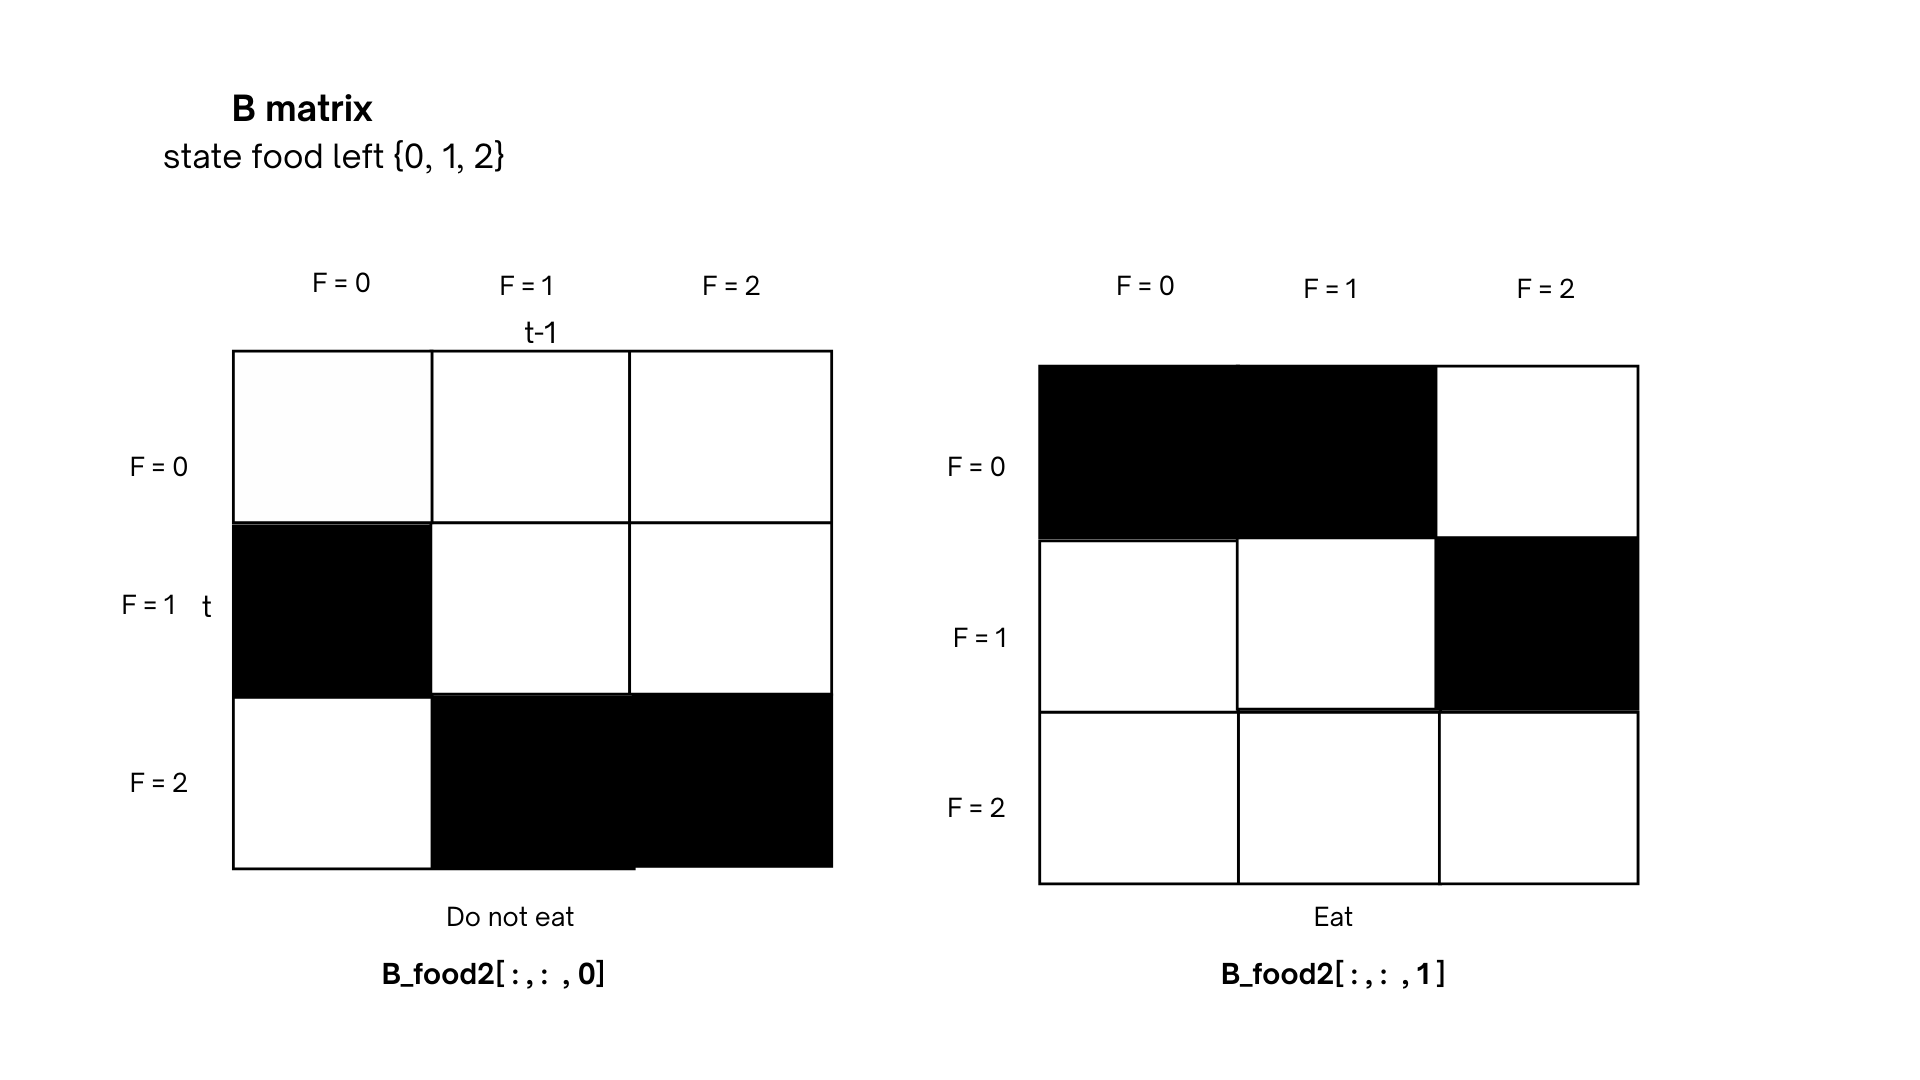

In [ ]:
B2[0].shape

(3, 3, 2)

In [ ]:
B2[0][:,:,:] = 0.0

# Action = do not eat -> B_food_left2[:,:,0]

# index 1: state t, index 2: state t-1, index 3: action

# state t: food left = 1, state t-1: food = 0, action: do not eat (0) should be 0%
B2[0][1,0,0] = 1.0

# state t: food left = 2, state t-1: food = 1, action: do not eat (0)
B2[0][2,1,0] = 1.0

# state t: food left = 2, state t-1: food = 0, action: do not eat (0)
B2[0][2,2,0] = 1.0

In [ ]:
B2[0][:,:,0]

array([[0., 0., 0.],
       [1., 0., 0.],
       [0., 1., 1.]])

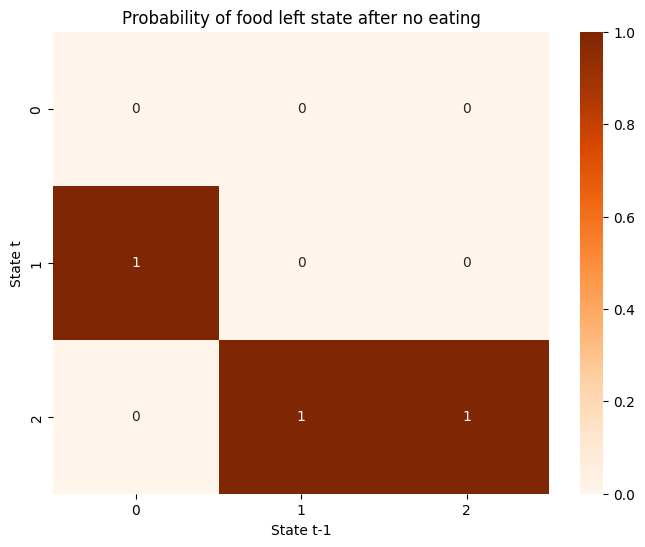

In [ ]:
plot_likelihoodB(B2[0][:,:,0], title = 'Probability of food left state after no eating' )

If the agent does not eat the food grows in time.

In [ ]:
# Action = eat -> B_food_left2[:,:,1]

B2[0][0,0,1] = 1.0
B2[0][0,1,1] = 1.0
B2[0][1,2,1] = 1.0

In [ ]:
B2[0][:,:,1]

array([[1., 1., 0.],
       [0., 0., 1.],
       [0., 0., 0.]])

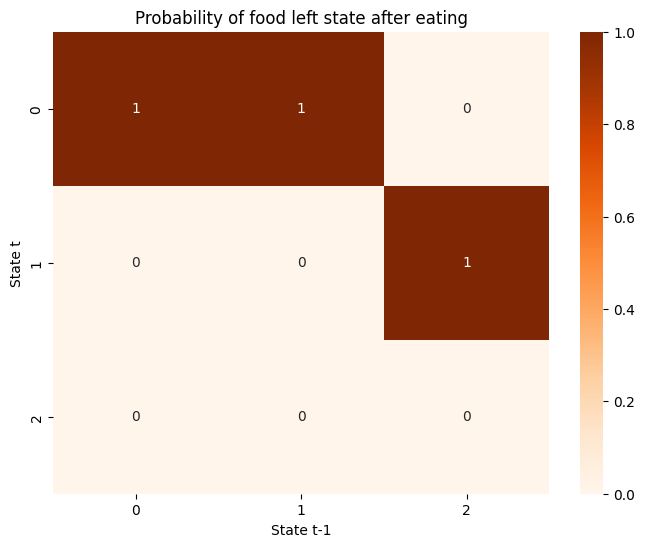

In [ ]:
plot_likelihoodB(B2[0][:,:,1], title = 'Probability of food left state after eating' )

#### Satiety state

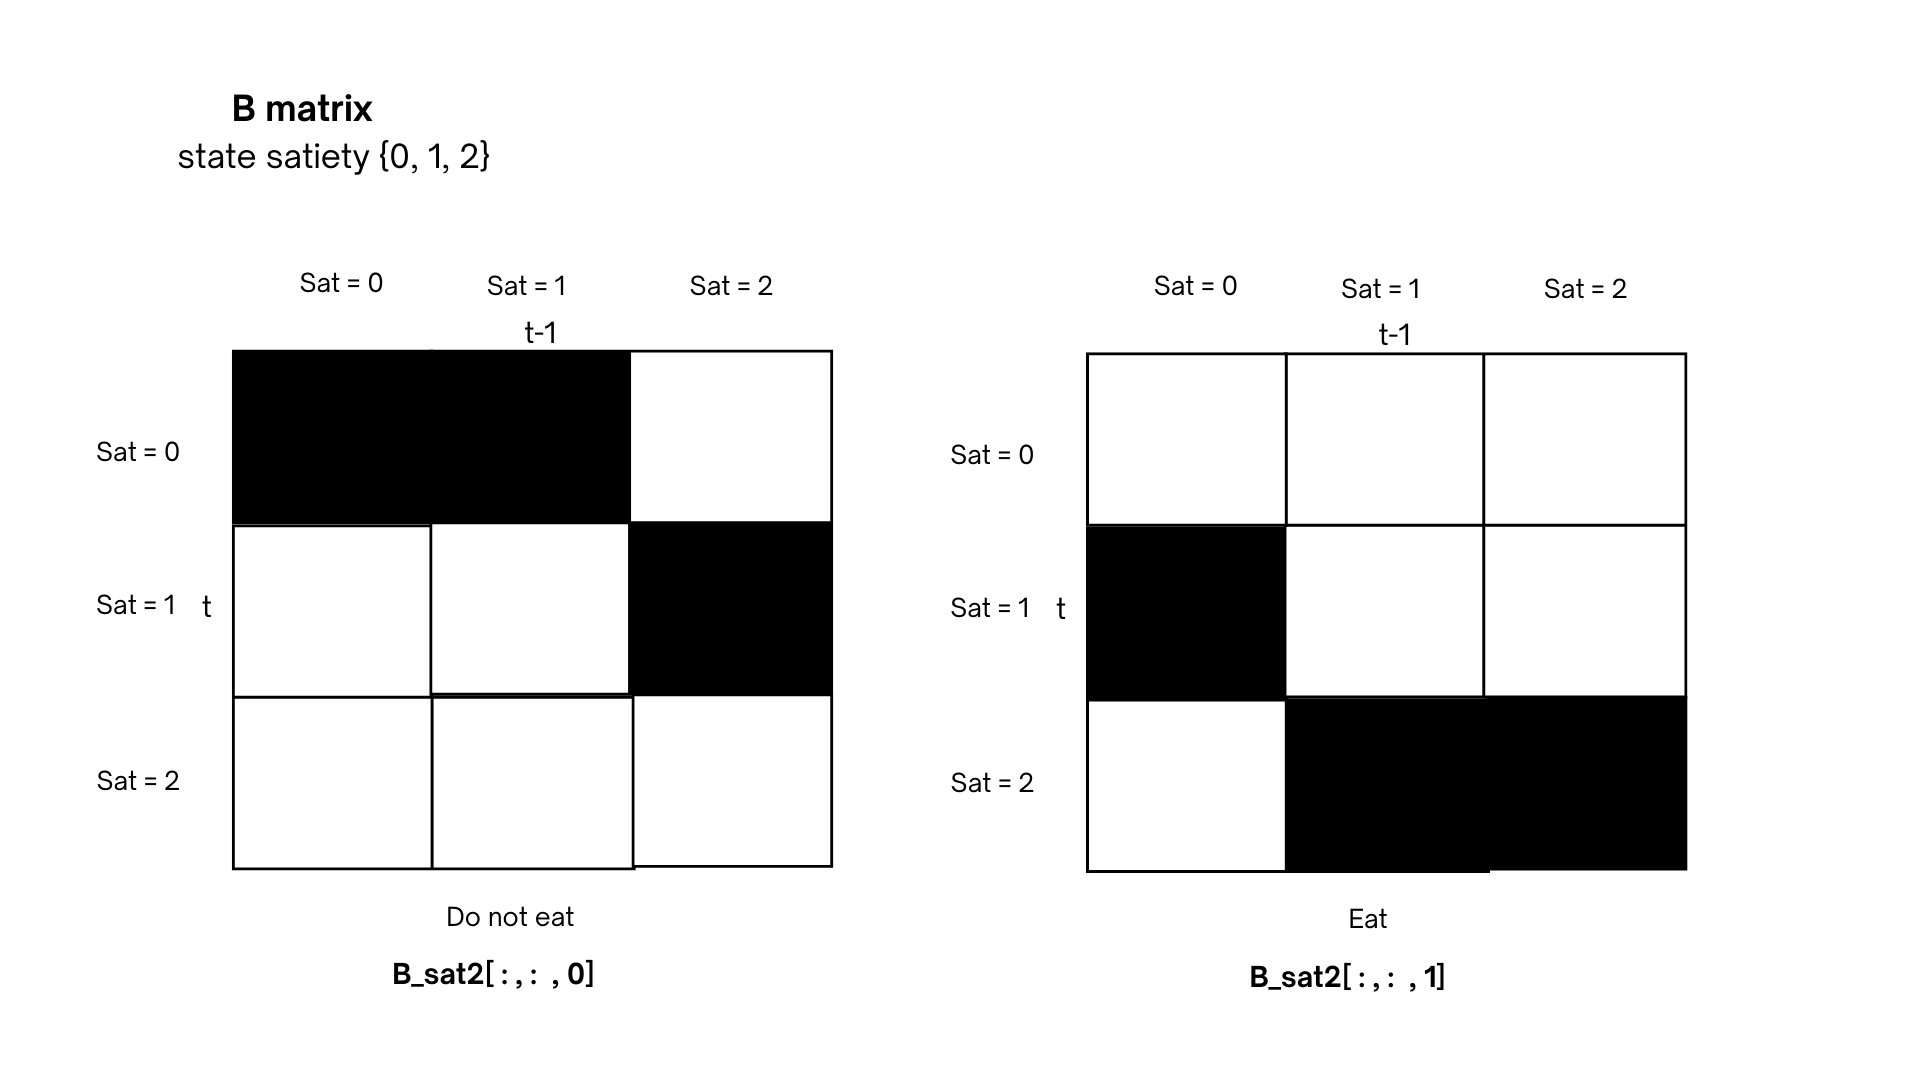

In [ ]:
# B2[1] -> satiety, has an extra dim with respect to B2[0]as set in B2_factor_list
# index 1: satiety t; index 2: food left t-1 ; index 3: satiety t-1; index 4: action

B2[1][:,:,:,:] = 0.0
print(B2[1].shape)

(3, 3, 3, 2)


In [ ]:
# Action = do not eat -> B_satiety2[:,:,:,0]
# index 1: satiety t; index 2: food left t-1; index 3: satiety t-1; index 4: action
# if the agent does not eat, regardless of food left situation, its satiety goes down by 1

B2[1][0,:,0,0] = 1.0
B2[1][0,:,1,0] = 1.0
B2[1][1,:,2,0] = 1.0

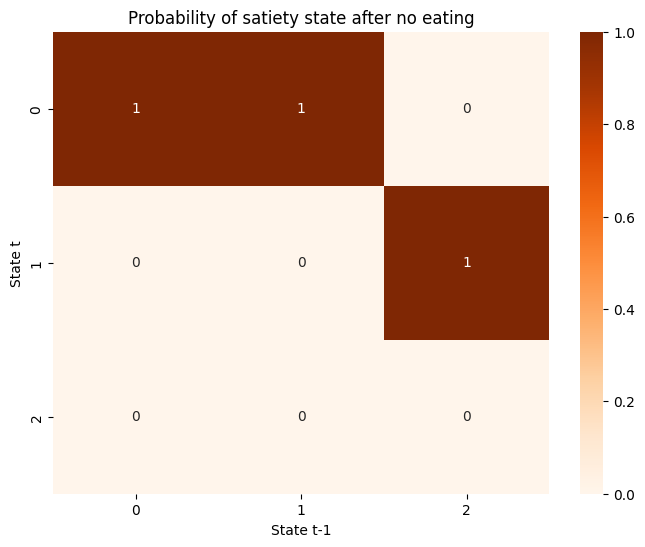

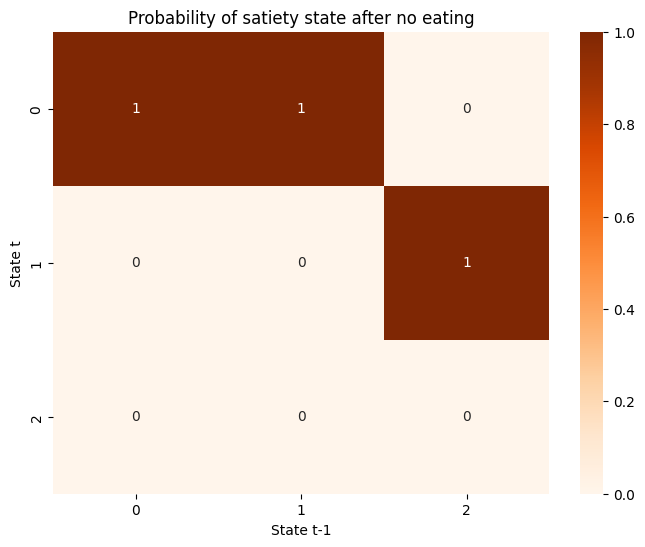

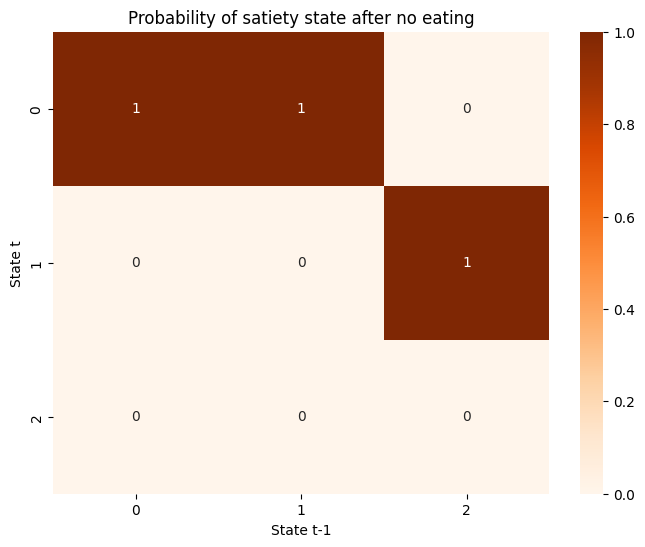

In [ ]:
plot_likelihoodB(B2[1][:,0,:,0], title = 'Probability of satiety state after no eating' )
plot_likelihoodB(B2[1][:,1,:,0], title = 'Probability of satiety state after no eating' )
plot_likelihoodB(B2[1][:,2,:,0], title = 'Probability of satiety state after no eating' )

In [ ]:
# do eat. if no food left at t-1 (index 2), then satiey will go down

B2[1][0,0,0,1]=1.0
B2[1][0,0,1,1]=1.0
B2[1][1,0,2,1]=1.0

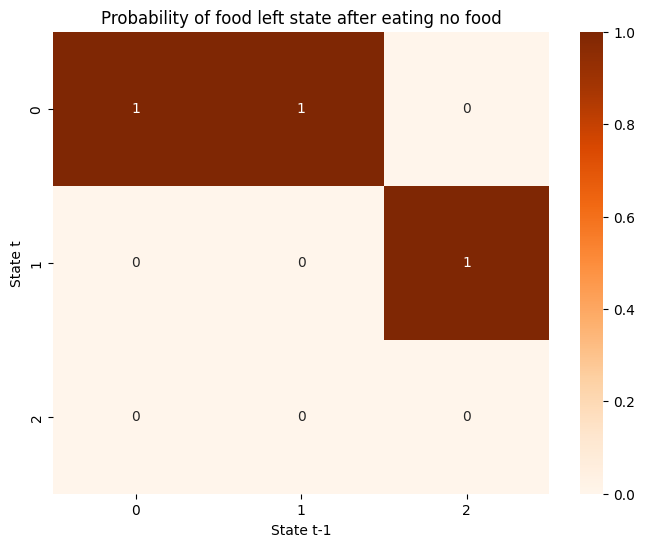

In [ ]:
plot_likelihoodB(B2[1][:,0,:,1], title = 'Probability of food left state after eating no food' )

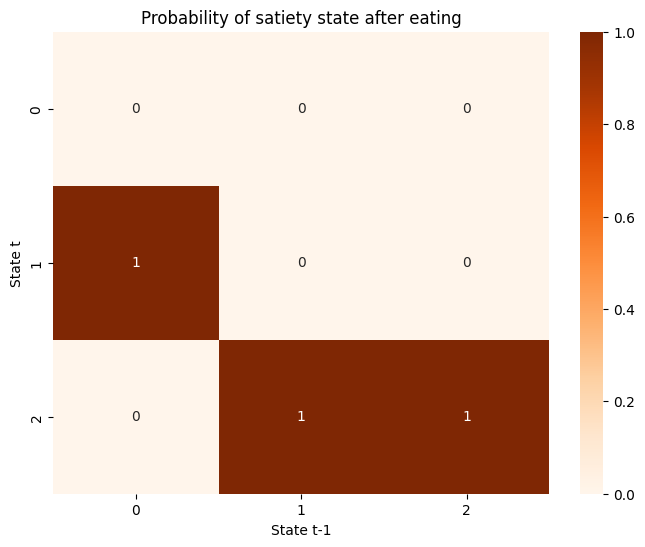

In [ ]:
# do eat. if food left then, then satiey will go up

B2[1][1,1,0,1]=1.0
B2[1][2,1,1,1]=1.0
B2[1][2,1,2,1]=1.0
plot_likelihoodB(B2[1][:,1,:,1], title = 'Probability of satiety state after eating')

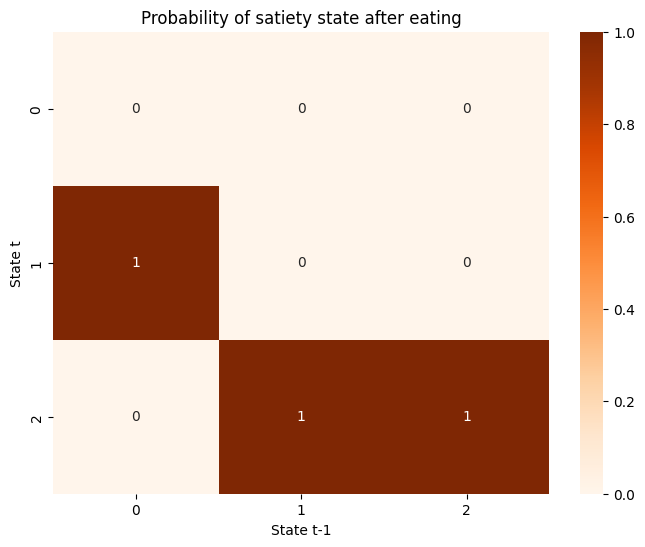

In [ ]:
B2[1][1,2,0,1]=1.0
B2[1][2,2,1,1]=1.0
B2[1][2,2,2,1]=1.0

plot_likelihoodB(B2[1][:,1,:,1], title = 'Probability of satiety state after eating' )

In [ ]:
B2[1][:,:,:,1]

array([[[1., 1., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[0., 0., 0.],
        [0., 1., 1.],
        [0., 1., 1.]]])

The above matrices look all the same, because regardless of food left situation, if the agent does not eat, its satiety goes down.

In [ ]:
print("Is the B matrix normalised?", utils.is_normalized(B2))

Is the B matrix normalised? True


### Prior preferences  - *C vector*



C vector: satisfying its hunger (maximizing satiety) and maintaining a sustainable food supply. The prior preferences encoded in the C matrix influence this tradeoff.

In [ ]:
# create prior preferences over observations

C2 = utils.obj_array_zeros([num_obs2])
C2

array([array([[0., 0., 0.],
              [0., 0., 0.],
              [0., 0., 0.]])], dtype=object)

In [ ]:
# Define preferences for each observation modality

C_food_left2 = np.array([5.0, 5.0, 5.0])  # flat preference on the obs of food left
#C_food_left2 = np.array([0.0, 20.0, 0.0])  # strong preference for the observation modality of food 1 <- average value
C_satiety2 = np.array([0.0, 10.0, 20.0]) # preference for the observation modality of sat = 1 (10.0) e sat = 2 (20.0)

# create an object array to hold each modality's preferences
C2 = np.empty(2, dtype=object)
C2[0] = C_food_left2
C2[1] = C_satiety2

In [ ]:
C2

array([array([5., 5., 5.]), array([ 0., 10., 20.])], dtype=object)

In [ ]:
len(C2)

2

In [ ]:
print("C vector:", C2)
for i, pref in enumerate(C2):
    print(f"Preferences for observation modality {i}: {pref}") #modality 0: food_left, 1: satiety

C vector: [array([5., 5., 5.]) array([ 0., 10., 20.])]
Preferences for observation modality 0: [5. 5. 5.]
Preferences for observation modality 1: [ 0. 10. 20.]


In [ ]:
softmax(C2[1])

array([2.06106005e-09, 4.53978686e-05, 9.99954600e-01])

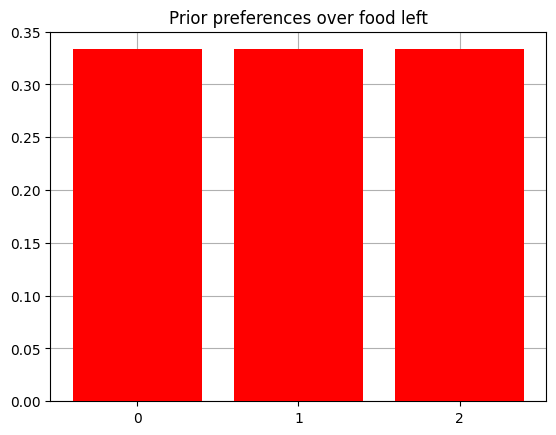

In [ ]:
utils.plot_beliefs(softmax(C2[0]), title = "Prior preferences over food left")

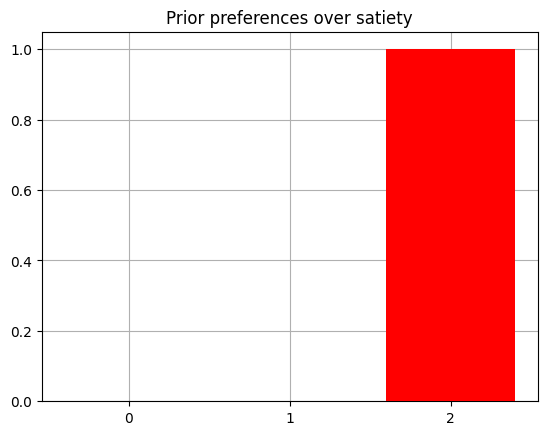

In [ ]:
utils.plot_beliefs(softmax(C2[1]), title = "Prior preferences over satiety")

Following *D vector* is superfluous/could mess things up

In [ ]:
# specify prior over hidden states (D vector)

#D2 = utils.obj_array(num_factors2)

# we set at t = 0 strong beliefs over hidden state food left = 2 D2[0][:,1,:] and satiety = 0 D2[1][0,:,:]

#D_food_left2 = np.array([0.0, 20.0, 20.0])
#D_satiety2 = np.array([20.0, 0.0, 0.0])

# create an object array to hold each modality's preferences
#D2 = np.empty(2, dtype=object)
#D2[0] = D_food_left2
#D2[1] = D_satiety2

#utils.plot_beliefs(softmax(D2[0]), title = "Initial beliefs about probability of food left state")

## **2.2 Generative Process**

### Agent

In [ ]:
# we set policy_len = 3 because in order to plan the agent needs to look further than just 1 ts
my_agent2 = Agent(A=A2, B=B2, C=C2, B_factor_list=B2_factor_list, policy_len = 3, policies=None, action_selection="stochastic")

In [ ]:
my_agent2.policy_len


3

In [ ]:
 pol = my_agent2.policies

In [ ]:
 len(pol) # should be reduced to 8 policies <- 2(actions)^3(steps ahead)

64

In [ ]:
# Filter policies based on the condition action[0] == action[1], so that we have the same action for both obs for all the 3 time steps
def is_valid_policy(policy):
    return all((action[0] == action[1]) for action in policy)

restricted_policies = [policy for policy in pol if is_valid_policy(policy)]

restricted_policies

[array([[0, 0],
        [0, 0],
        [0, 0]]),
 array([[0, 0],
        [0, 0],
        [1, 1]]),
 array([[0, 0],
        [1, 1],
        [0, 0]]),
 array([[0, 0],
        [1, 1],
        [1, 1]]),
 array([[1, 1],
        [0, 0],
        [0, 0]]),
 array([[1, 1],
        [0, 0],
        [1, 1]]),
 array([[1, 1],
        [1, 1],
        [0, 0]]),
 array([[1, 1],
        [1, 1],
        [1, 1]])]

In [ ]:
len(restricted_policies)

8

In [ ]:
my_agent2.policies = restricted_policies

In [ ]:
# to adjust matrix size after having reduced policies

my_agent2.E = my_agent2._construct_E_prior()

In [ ]:
my_agent2.policies # we expect 8 policies 2^3

[array([[0, 0],
        [0, 0],
        [0, 0]]),
 array([[0, 0],
        [0, 0],
        [1, 1]]),
 array([[0, 0],
        [1, 1],
        [0, 0]]),
 array([[0, 0],
        [1, 1],
        [1, 1]]),
 array([[1, 1],
        [0, 0],
        [0, 0]]),
 array([[1, 1],
        [0, 0],
        [1, 1]]),
 array([[1, 1],
        [1, 1],
        [0, 0]]),
 array([[1, 1],
        [1, 1],
        [1, 1]])]

In [ ]:
len(my_agent2.policies)

8

### Environment and AIF loop

In [ ]:
class room_Env2:
    def __init__(self):

        # Initial states
        self.state_food2 = 2  # food = 2 (full)
        self.state_satiety2 = 1  # satiety = 1 (half satisfied)

    def step(self, action):
        """
        Updates the environment state based on the agent's action and returns the observation.

        :param action: int, the action taken by the agent, 0 for 'do not eat', 1 for 'eat'
        :return: tuple, (observation_food, observation_satiety)
        """
        if action == 0:  # do not eat
            # increase food level if agent does not eat
            self.state_food2 = min(self.state_food2 + 1, 2)  # food level can grow up to 2
            self.state_satiety2 = max(self.state_satiety2 - 1, 0) # satiety decreases

        elif action == 1:  # eat
            if self.state_food2 > 0:  # can only eat if food is present
                # decrease food, increase satiety
                self.state_food2 -= 1
                self.state_satiety2 = min(self.state_satiety2 + 1, 2)
            elif self.state_food2==0:
                self.state_food2 = 0
                self.state_satiety2 = min(self.state_satiety2 - 1, 2)

        # mapping states to observations
        obs_food2 = self.state_food2  # directly use the state as observation
        obs_satiety2 = self.state_satiety2

        return [obs_food2, obs_satiety2]

    def reset(self):
        # reset the environment to the initial state
        self.state_food2 = 2  # Food full present
        self.state_satiety2 = 1  # Half satisfied

        return [self.state_food2, self.state_satiety2]

We can run the AIF loop several times to show results reliability

In [ ]:
num_runs = 3

# length of active inference loop in time
T = 10

# initialize lists to store results
actions_list = []
observations_list = []

for run in range(num_runs):
    env = room_Env2()
    current_state = env.reset() # initialize or reset the env
    my_agent2.reset()

    actions = []
    observations = []
    satiety_zero_count = 0 # if satiety is 0 for more than 2 ts the agent dies
    print("\nNew Run")
    for t in range(T):
        # get current observation from the environment
        if t == 0:
            observation = [np.array([current_state[0]]), np.array([current_state[1]])]
        else:
            obs = env.step(action)
            observation = [np.array([obs[0]]), np.array([obs[1]])]

        print(f"Observation: {observation}")
        print()

        # update the agent's belief about the current state based on the observation
        qs = my_agent2.infer_states(observation)  # Update state beliefs

        # infer policies based on the updated beliefs
        my_agent2.infer_policies()

        # sample the next action from the inferred policies
        action = my_agent2.sample_action()

        # handle action based on its type and structure
        if isinstance(action, np.ndarray) and action.size == 1:
            action = int(action.item())  # Convert single-item array to integer
        elif isinstance(action, np.ndarray) and action.ndim > 0:
            action = int(action[0])  # Select the first action if multiple are given
        else:
            print("Unexpected action format. Terminating loop.")
            break

          # Check for satiety level and update the count
        if observation[1] == 0:
            satiety_zero_count += 1
        else:
            satiety_zero_count = 0

          # Terminate loop if satiety = 0 for 1 time step
        if satiety_zero_count >= 1:
            print("AGENT DIES OF STARVATION.")
            print()
            break

        # store results for this timestep
        actions.append(action)
        observations.append(observation)


        # print results for this timestep
        print(f"Run {run + 1}")
        print(f"Time step {t}, Action taken: {action}")


    # Store results for this run
    actions_list.append(actions)
    observations_list.append(observations)


New Run
Observation: [array([2]), array([1])]

Run 1
Time step 0, Action taken: 1
Observation: [array([1]), array([2])]

Run 1
Time step 1, Action taken: 0
Observation: [array([2]), array([1])]

Run 1
Time step 2, Action taken: 1
Observation: [array([1]), array([2])]

Run 1
Time step 3, Action taken: 0
Observation: [array([2]), array([1])]

Run 1
Time step 4, Action taken: 1
Observation: [array([1]), array([2])]

Run 1
Time step 5, Action taken: 1
Observation: [array([0]), array([2])]

Run 1
Time step 6, Action taken: 0
Observation: [array([1]), array([1])]

Run 1
Time step 7, Action taken: 1
Observation: [array([0]), array([2])]

Run 1
Time step 8, Action taken: 0
Observation: [array([1]), array([1])]

Run 1
Time step 9, Action taken: 1

New Run
Observation: [array([2]), array([1])]

Run 2
Time step 0, Action taken: 1
Observation: [array([1]), array([2])]

Run 2
Time step 1, Action taken: 1
Observation: [array([0]), array([2])]

Run 2
Time step 2, Action taken: 0
Observation: [array(

In [ ]:
# to read the output: observation index 1: food left, index 2: satiety

The agent is planning with respect to the future (policy lenght is 3 ts) and it needs to care if it has food left, by not being greedy. This happens, and it manages to stay alive (satiety never goes to 0 over 10 ts for 3 runs) by not eating all the food at its disposal.

### Results plots

<ipython-input-197-60135239df0d>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20', num_runs)  # 'tab20' provides 20 different colors


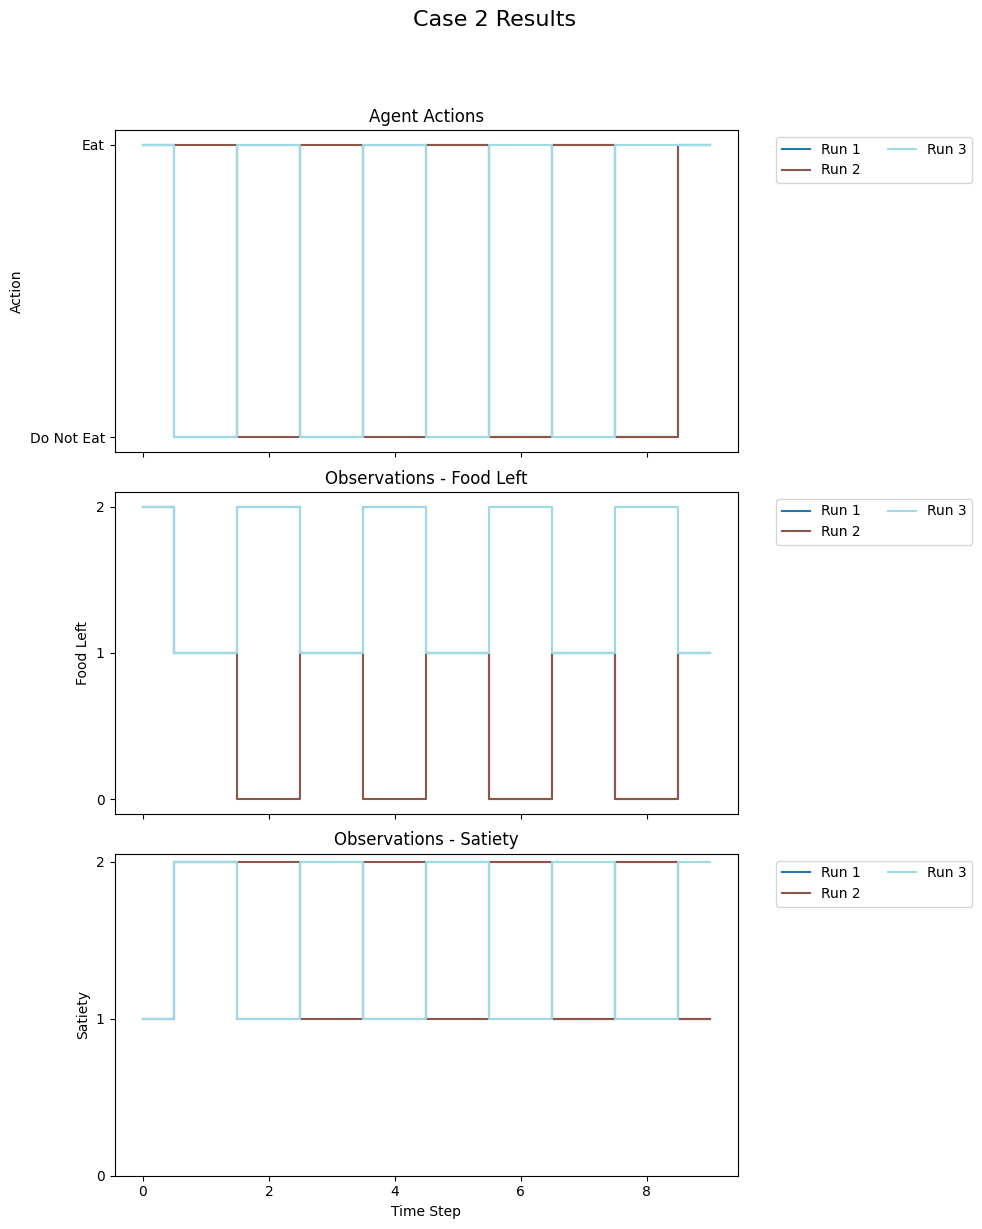

In [ ]:
from matplotlib.cm import get_cmap

# Define a colormap
cmap = get_cmap('tab20', num_runs)  # 'tab20' provides 20 different colors

# Plot the results
time_steps = range(T)

fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Plotting actions for each run
for run in range(num_runs):
    axs[0].step(time_steps, actions_list[run], where='mid', label=f'Run {run + 1}', color=cmap(run))
axs[0].set_ylabel("Action")
axs[0].set_title("Agent Actions")
axs[0].set_yticks([0, 1])
axs[0].set_yticklabels(["Do Not Eat", "Eat"])
axs[0].legend(ncol=2, bbox_to_anchor=(1.05, 1), loc='upper left')

# Plotting observations - food left for each run
for run in range(num_runs):
    obs_food = [obs[0][0] for obs in observations_list[run]]  # Extracting food left
    axs[1].step(time_steps, obs_food, where='mid', label=f'Run {run + 1}', color=cmap(run))
axs[1].set_ylabel("Food Left")
axs[1].set_title("Observations - Food Left")
axs[1].set_yticks([0, 1, 2])
axs[1].legend(ncol=2, bbox_to_anchor=(1.05, 1), loc='upper left')

# Plotting observations - satiety for each run
for run in range(num_runs):
    obs_satiety = [obs[1][0] for obs in observations_list[run]]  # Extracting satiety level
    axs[2].step(time_steps, obs_satiety, where='mid', label=f'Run {run + 1}', color=cmap(run))
axs[2].set_ylabel("Satiety")
axs[2].set_title("Observations - Satiety")
axs[2].set_yticks([0, 1, 2])
axs[2].legend(ncol=2, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel("Time Step")
plt.tight_layout()

fig.suptitle("Case 2 Results", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.92)

plt.show()


Run 1 completely overlaps with part of run 2 and part of run 3.

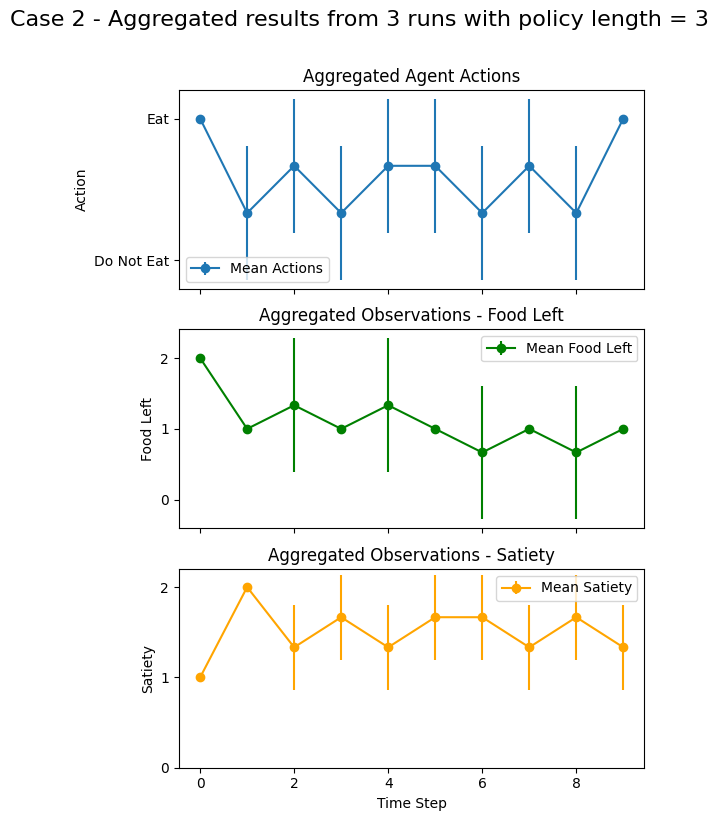

In [ ]:
# Plot the aggregated results
# Number of runs
num_runs = len(observations_list)
T = len(observations_list[0])

# Initialize arrays to store aggregated data
actions_array = np.zeros((num_runs, T))
food_left_array = np.zeros((num_runs, T))
satiety_array = np.zeros((num_runs, T))

# Populate arrays with data from observations_list
for run in range(num_runs):
    actions_array[run, :] = actions_list[run]
    food_left_array[run, :] = [obs[0][0] for obs in observations_list[run]]
    satiety_array[run, :] = [obs[1][0] for obs in observations_list[run]]

# Calculate mean and standard deviation
mean_actions = np.mean(actions_array, axis=0)
std_actions = np.std(actions_array, axis=0)

mean_food_left = np.mean(food_left_array, axis=0)
std_food_left = np.std(food_left_array, axis=0)

mean_satiety = np.mean(satiety_array, axis=0)
std_satiety = np.std(satiety_array, axis=0)

# Plot the aggregated results
time_steps = range(T)

fig, axs = plt.subplots(3, 1, figsize=(6, 8), sharex=True)

# Plotting aggregated actions
axs[0].errorbar(time_steps, mean_actions, yerr=std_actions, fmt='-o', label='Mean Actions')
axs[0].set_ylabel("Action")
axs[0].set_title("Aggregated Agent Actions")
axs[0].set_yticks([0, 1])
axs[0].set_yticklabels(["Do Not Eat", "Eat"])
axs[0].legend()

# Plotting aggregated observations - food left
axs[1].errorbar(time_steps, mean_food_left, yerr=std_food_left, fmt='-o', color='green', label='Mean Food Left')
axs[1].set_ylabel("Food Left")
axs[1].set_title("Aggregated Observations - Food Left")
axs[1].set_yticks([0, 1, 2])
axs[1].legend()

# Plotting aggregated observations - satiety
axs[2].errorbar(time_steps, mean_satiety, yerr=std_satiety, fmt='-o', color='orange', label='Mean Satiety')
axs[2].set_ylabel("Satiety")
axs[2].set_title("Aggregated Observations - Satiety")
axs[2].set_yticks([0, 1, 2])
axs[2].legend()

plt.xlabel("Time Step")
plt.tight_layout()

fig.suptitle("Case 2 - Aggregated results from 3 runs with policy length = 3", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.92)

plt.show()


##**2.3 Learning**

Until now we have tested the agent's behavior to see whether it was correct. This was done by having pre-filled A and B matrices. Now, we are introducing learning of the B matrix, which represents the agent's model of how its actions affect the state of the environment. We keep the pre-filled A matrix and initialize a random B matrix to check whether the agent is able to learn the B matrix the way it should be through different runs. Focusing on the B matrix only also is useful to save computational resources and not adding too much layers of complexity.

**Expected results:** in the early runs the agent behaves randomly and dies quickly. But with learning it should improve performance and eventually learn to survive indefinitely. And it will learn the B matrix which look like the ones we hand designed.

In [ ]:
#we do not fill in the B matrix
B2_random = utils.random_B_matrix(num_states2, num_controls, B2_factor_list)
dir_scale=1

In [ ]:
pB = utils.dirichlet_like(B2_random,scale=dir_scale) # added PK
pB=[pB[0],pB[1]]

In [ ]:
B2_random[0].shape

(3, 3, 2)

In [ ]:
B2_random[1].shape

(3, 3, 3, 2)

In [ ]:
B2_random

array([array([[[0.55102192, 0.33918108],
               [0.41590713, 0.10447943],
               [0.14570026, 0.20548878]],

              [[0.32207808, 0.26082836],
               [0.43607563, 0.23045304],
               [0.39573353, 0.47946746]],

              [[0.1269    , 0.39999057],
               [0.14801725, 0.66506752],
               [0.45856621, 0.31504376]]]),
       array([[[[0.35124733, 0.42410488],
                [0.08824528, 0.04776604],
                [0.14142946, 0.13947421]],

               [[0.17948256, 0.33177518],
                [0.11716871, 0.41146907],
                [0.09030896, 0.1452614 ]],

               [[0.46964602, 0.2187373 ],
                [0.48039019, 0.50077413],
                [0.47682599, 0.27490093]]],


              [[[0.33728524, 0.41009725],
                [0.44477846, 0.34883267],
                [0.51327987, 0.04718096]],

               [[0.28698453, 0.21368497],
                [0.31086324, 0.18017617],
                [0.7131780

In [ ]:
pB

[array([[[0.55102192, 0.33918108],
         [0.41590713, 0.10447943],
         [0.14570026, 0.20548878]],
 
        [[0.32207808, 0.26082836],
         [0.43607563, 0.23045304],
         [0.39573353, 0.47946746]],
 
        [[0.1269    , 0.39999057],
         [0.14801725, 0.66506752],
         [0.45856621, 0.31504376]]]),
 array([[[[0.35124733, 0.42410488],
          [0.08824528, 0.04776604],
          [0.14142946, 0.13947421]],
 
         [[0.17948256, 0.33177518],
          [0.11716871, 0.41146907],
          [0.09030896, 0.1452614 ]],
 
         [[0.46964602, 0.2187373 ],
          [0.48039019, 0.50077413],
          [0.47682599, 0.27490093]]],
 
 
        [[[0.33728524, 0.41009725],
          [0.44477846, 0.34883267],
          [0.51327987, 0.04718096]],
 
         [[0.28698453, 0.21368497],
          [0.31086324, 0.18017617],
          [0.71317809, 0.68233904]],
 
         [[0.26902627, 0.36307237],
          [0.29030987, 0.47297937],
          [0.06864684, 0.56775805]]],
 
 
    

We have a new my_agent2, with a random B matrix

In [ ]:
#pass pB
my_new_agent2 = Agent(A=A2, B=B2_random, pB = pB, C=C2, B_factor_list=B2_factor_list, policy_len = 3, policies=None, action_selection="stochastic")

In [ ]:
#we restrict policies as before
my_new_agent2.policies = restricted_policies

In [ ]:
# to adjust matrix size after having reduced policies
my_new_agent2.E = my_new_agent2._construct_E_prior()

In [ ]:
my_new_agent2.policies # we expect 8 policies 2^3

[array([[0, 0],
        [0, 0],
        [0, 0]]),
 array([[0, 0],
        [0, 0],
        [1, 1]]),
 array([[0, 0],
        [1, 1],
        [0, 0]]),
 array([[0, 0],
        [1, 1],
        [1, 1]]),
 array([[1, 1],
        [0, 0],
        [0, 0]]),
 array([[1, 1],
        [0, 0],
        [1, 1]]),
 array([[1, 1],
        [1, 1],
        [0, 0]]),
 array([[1, 1],
        [1, 1],
        [1, 1]])]

In [ ]:
print("Num policies:",len(my_new_agent2.policies))

Num policies: 8


### AIF loop with learning

In [ ]:
# Number of runs and time steps
num_runs = 20
T = 10

actions_list = []
observations_list = []
B_snapshots0_action0 = []
B_snapshots0_action1 = []
B_snapshots1_action0 = []
B_snapshots1_action1 = []
survival_time_with_learning=[]

my_new_agent2.reset()

for run in range(num_runs):
    actions = []
    observations = []
    env = room_Env2()
    current_state = env.reset()
    satiety_zero_count = 0

    for t in range(T):
        if t == 0:
            observation = [np.array([current_state[0]]), np.array([current_state[1]])]
            qs_prev = my_new_agent2.infer_states(observation)
        else:
            obs = env.step(action)
            observation = [np.array([obs[0]]), np.array([obs[1]])]

        # Store snapshot of B matrix for the first factor and first action
        B_snapshots0_action0.append(my_new_agent2.B[0][:, :, 0].copy()) #if we store action 0 the matrices are all the same,
        B_snapshots0_action1.append(my_new_agent2.B[0][:, :, 1].copy())
        B_snapshots1_action0.append(my_new_agent2.B[1][:, :, 0].copy())
        B_snapshots1_action1.append(my_new_agent2.B[1][:, :, 1].copy())

        # Update the agent's belief about the current state based on the observation
        qs = my_new_agent2.infer_states(observation)

        # Infer policies based on the updated beliefs
        my_new_agent2.infer_policies()

        if t > 0:
            qB = my_new_agent2.update_B(qs_prev)
            qs_prev = qs

        # Sample the next action from the inferred policies
        action = my_new_agent2.sample_action()

        if isinstance(action, np.ndarray) and action.size == 1:
            action = int(action.item())
        elif isinstance(action, np.ndarray) and action.ndim > 0:
            action = int(action[0])
        else:
            print("Unexpected action format. Terminating loop.")
            break

        if observation[1] == 0:
            satiety_zero_count += 1
        else:
            satiety_zero_count = 0

        if satiety_zero_count >= 1: # like before, agent dies if satiety = 0 last more than 1 ts
            print(f"AGENT DIED OF STARVATION IN RUN {run + 1}.")
            survival_time_with_learning.append(t)
            break

        # Store results for this time step
        actions.append(action)
        observations.append(observation)
        previous_observation = observation

    # Store results for this run
    actions_list.append(actions)
    observations_list.append(observations)
    if t == T - 1:
        survival_time_with_learning.append(t)
        print(f"AGENT SURVIVED IN RUN {run + 1}.")

AGENT SURVIVED IN RUN 1.
AGENT SURVIVED IN RUN 2.
AGENT SURVIVED IN RUN 3.
AGENT SURVIVED IN RUN 4.
AGENT SURVIVED IN RUN 5.
AGENT SURVIVED IN RUN 6.
AGENT SURVIVED IN RUN 7.
AGENT SURVIVED IN RUN 8.
AGENT SURVIVED IN RUN 9.
AGENT SURVIVED IN RUN 10.
AGENT SURVIVED IN RUN 11.
AGENT SURVIVED IN RUN 12.
AGENT SURVIVED IN RUN 13.
AGENT SURVIVED IN RUN 14.
AGENT SURVIVED IN RUN 15.
AGENT SURVIVED IN RUN 16.
AGENT SURVIVED IN RUN 17.
AGENT SURVIVED IN RUN 18.
AGENT SURVIVED IN RUN 19.
AGENT SURVIVED IN RUN 20.


Agent should die in the first runs and then learn of to survive. The trajectory of learning will be different every time you run because of different initial seed values for the B matrices.

**Updated B matrix**

num total steps 192
Food left, action do not eat


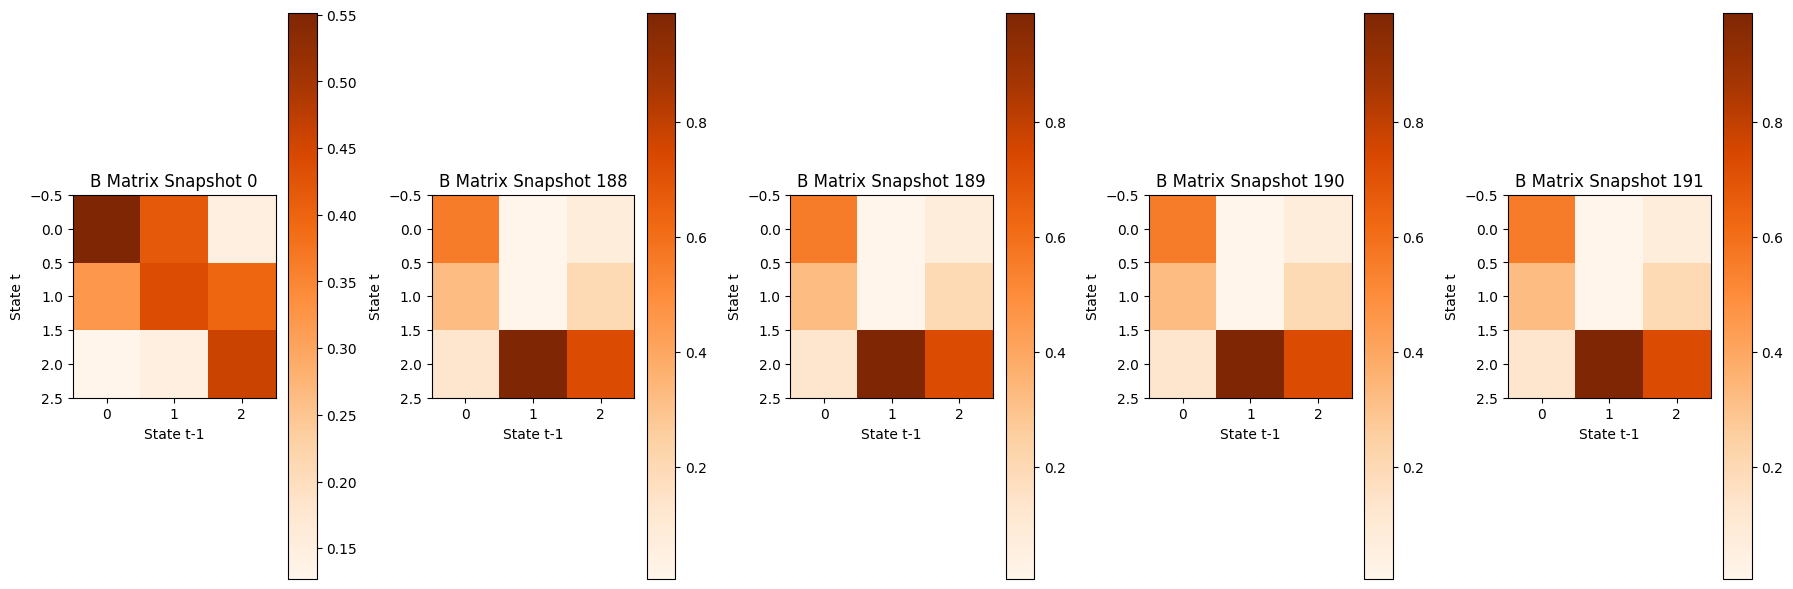

In [ ]:
# Plot snapshots of the updated B matrix for one of the factors as an example
num_snapshots = min(len(B_snapshots0_action0), 5)  # Limit to 5 snapshots for clarity
print("num total steps",len(B_snapshots0_action0))

print("Food left, action do not eat")
plt.figure(figsize=(18, 6))
plt.subplot(1, num_snapshots, 1)
plt.imshow(B_snapshots0_action0[0], cmap='Oranges', interpolation='nearest')
plt.colorbar()
plt.title(f'B Matrix Snapshot {0}')
plt.xlabel('State t-1')
plt.ylabel('State t')
for i in range(1,num_snapshots):
    plt.subplot(1, num_snapshots, i + 1)
    plt.imshow(B_snapshots0_action0[i+len(B_snapshots0_action0)- 5], cmap='Oranges', interpolation='nearest')
    plt.colorbar()
    plt.title(f'B Matrix Snapshot {i+len(B_snapshots0_action0)- 5}')
    plt.xlabel('State t-1')
    plt.ylabel('State t')
plt.tight_layout()
plt.show()

Food left, action 'eat'


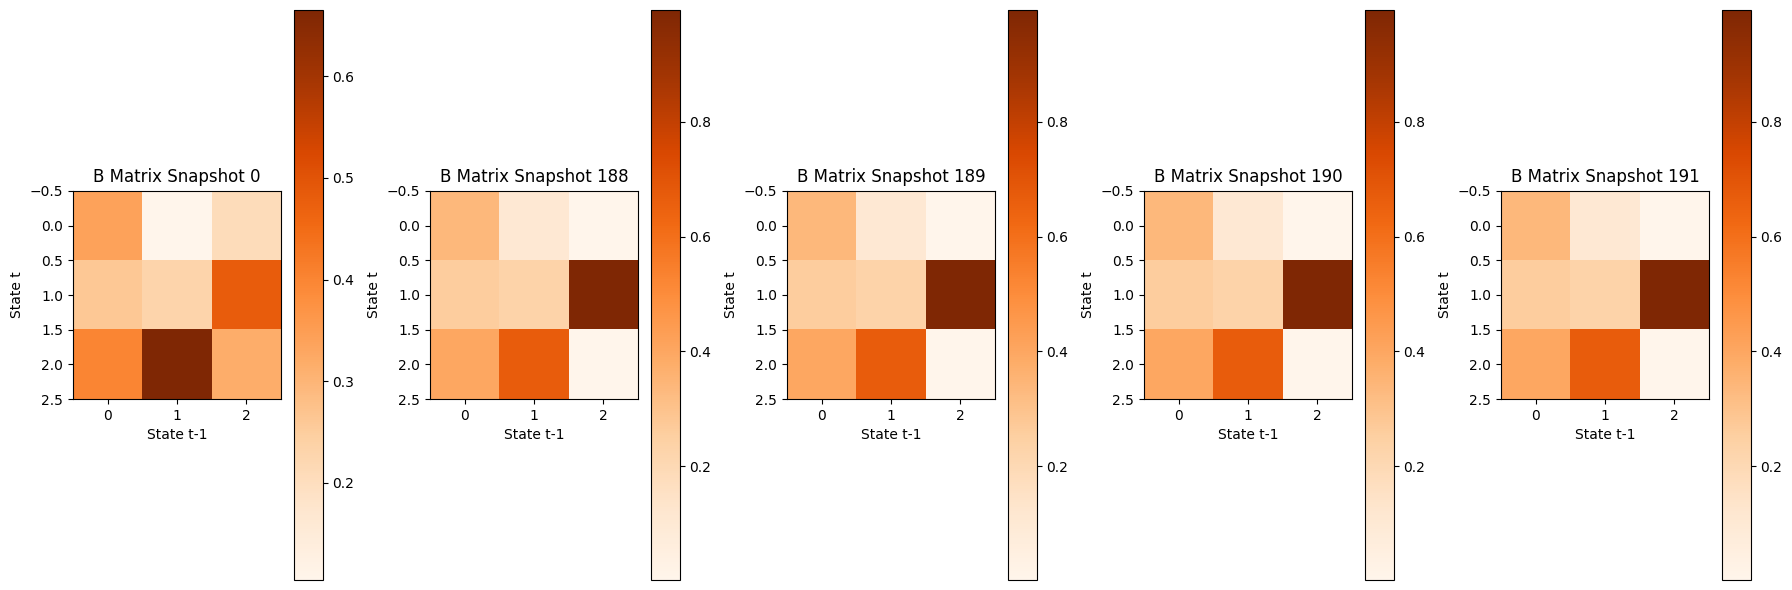

In [ ]:
print("Food left, action 'eat'")
plt.figure(figsize=(18, 6))
plt.subplot(1, num_snapshots, 1)
plt.imshow(B_snapshots0_action1[0], cmap='Oranges', interpolation='nearest')
plt.colorbar()
plt.title(f'B Matrix Snapshot {0}')
plt.xlabel('State t-1')
plt.ylabel('State t')
for i in range(1,num_snapshots):
    plt.subplot(1, num_snapshots, i + 1)
    plt.imshow(B_snapshots0_action1[i+len(B_snapshots0_action0)- 5], cmap='Oranges', interpolation='nearest')
    plt.colorbar()
    plt.title(f'B Matrix Snapshot {i+len(B_snapshots0_action0)- 5}')
    plt.xlabel('State t-1')
    plt.ylabel('State t')
plt.tight_layout()
plt.show()


There is learning on eat action.

Satiety, action 'do not eat', food_left=0


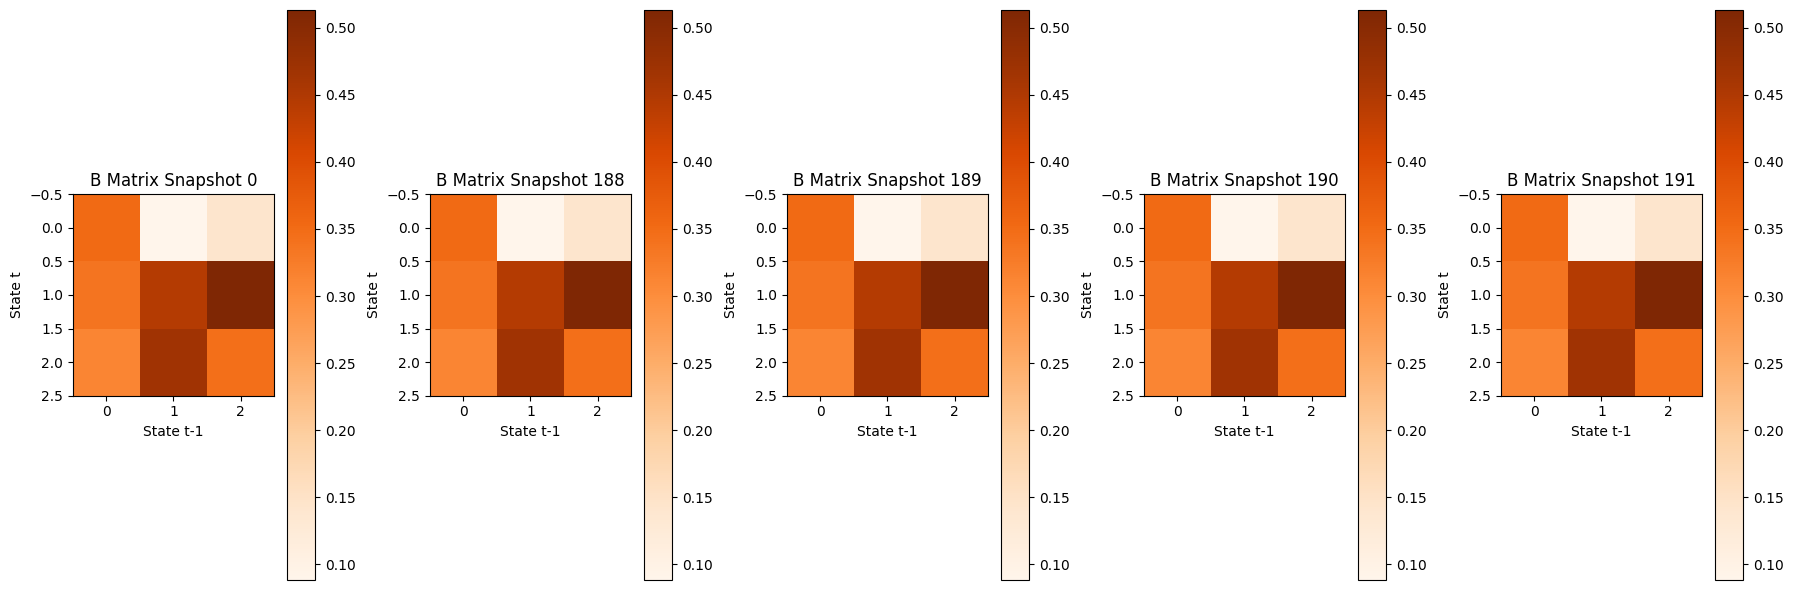

In [ ]:
print("Satiety, action 'do not eat', food_left=0")
plt.figure(figsize=(18, 6))
plt.subplot(1, num_snapshots, 1)
plt.imshow(B_snapshots1_action0[0][:,0,:], cmap='Oranges', interpolation='nearest')
plt.colorbar()
plt.title(f'B Matrix Snapshot {0}')
plt.xlabel('State t-1')
plt.ylabel('State t')
for i in range(1,num_snapshots):
    plt.subplot(1, num_snapshots, i + 1)
    plt.imshow(B_snapshots1_action0[i+len(B_snapshots0_action0)- 5][:,0,:], cmap='Oranges', interpolation='nearest')
    plt.colorbar()
    plt.title(f'B Matrix Snapshot {i+len(B_snapshots0_action0)- 5}')
    plt.xlabel('State t-1')
    plt.ylabel('State t')
plt.tight_layout()
plt.show()

Satiety, action 'do not eat', food_left=1


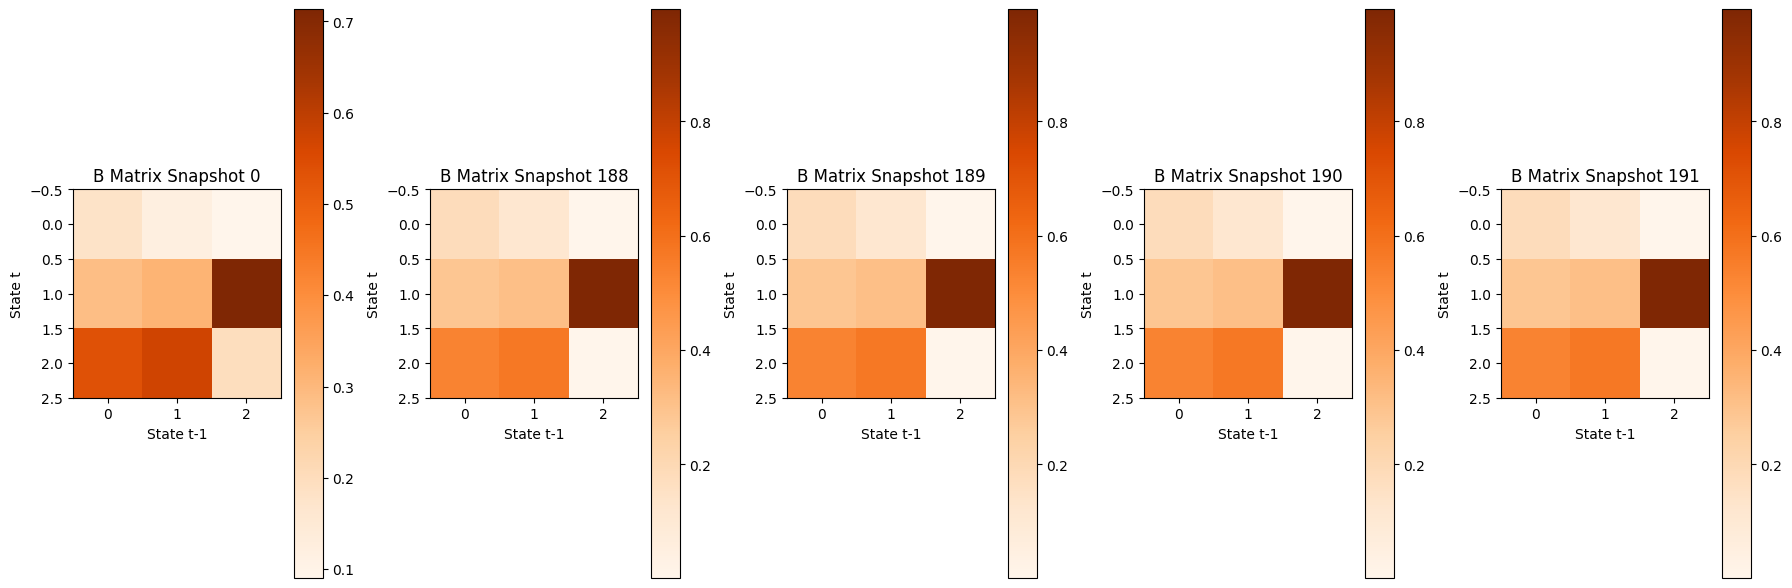

In [ ]:
print("Satiety, action 'do not eat', food_left=1")
plt.figure(figsize=(18, 6))
plt.subplot(1, num_snapshots, 1)
plt.imshow(B_snapshots1_action0[0][:,1,:], cmap='Oranges', interpolation='nearest')
plt.colorbar()
plt.title(f'B Matrix Snapshot {0}')
plt.xlabel('State t-1')
plt.ylabel('State t')
for i in range(1,num_snapshots):
    plt.subplot(1, num_snapshots, i + 1)
    plt.imshow(B_snapshots1_action0[i+len(B_snapshots0_action0)- 5][:,1,:], cmap='Oranges', interpolation='nearest')
    plt.colorbar()
    plt.title(f'B Matrix Snapshot {i+len(B_snapshots0_action0)- 5}')
    plt.xlabel('State t-1')
    plt.ylabel('State t')
plt.tight_layout()
plt.show()

Satiety, action 'do not eat', food_left=2


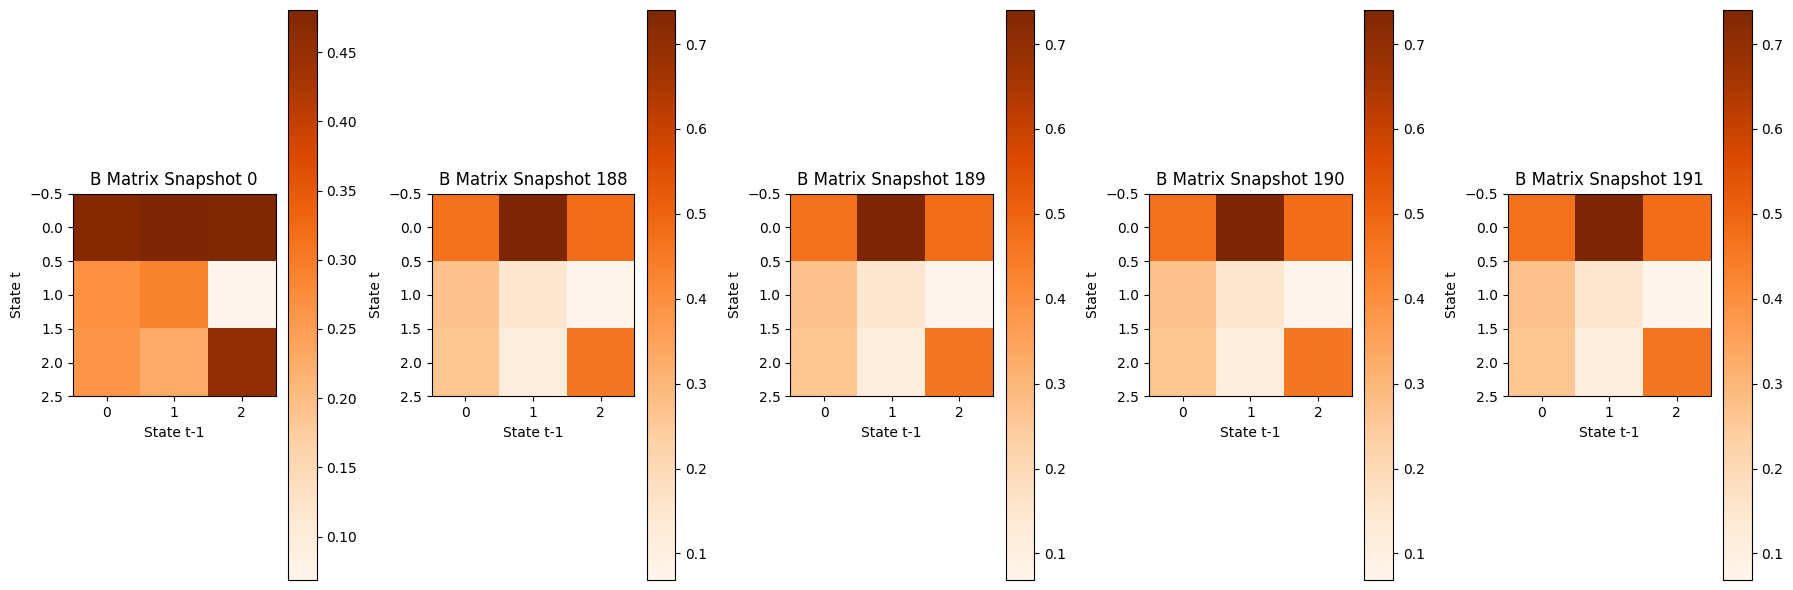

In [ ]:
print("Satiety, action 'do not eat', food_left=2")
plt.figure(figsize=(18, 6))
plt.subplot(1, num_snapshots, 1)
plt.imshow(B_snapshots1_action0[0][:,2,:], cmap='Oranges', interpolation='nearest')
plt.colorbar()
plt.title(f'B Matrix Snapshot {0}')
plt.xlabel('State t-1')
plt.ylabel('State t')
for i in range(1,num_snapshots):
    plt.subplot(1, num_snapshots, i + 1)
    plt.imshow(B_snapshots1_action0[i+len(B_snapshots0_action0)- 5][:,2,:], cmap='Oranges', interpolation='nearest')
    plt.colorbar()
    plt.title(f'B Matrix Snapshot {i+len(B_snapshots0_action0)- 5}')
    plt.xlabel('State t-1')
    plt.ylabel('State t')
plt.tight_layout()
plt.show()

Satiety, action 'eat', food_left=0


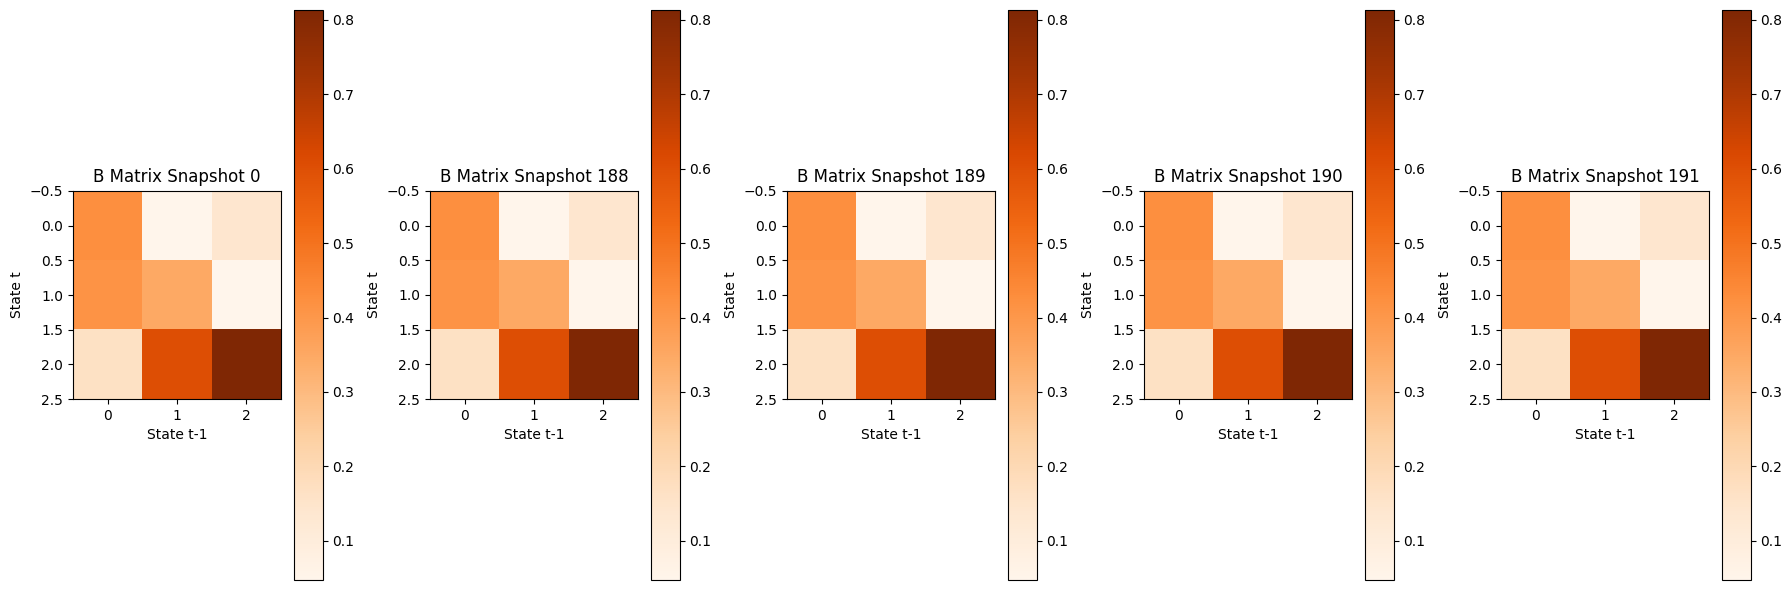

In [ ]:
print("Satiety, action 'eat', food_left=0")
plt.figure(figsize=(18, 6))
plt.subplot(1, num_snapshots, 1)
plt.imshow(B_snapshots1_action1[0][:,0,:], cmap='Oranges', interpolation='nearest')
plt.colorbar()
plt.title(f'B Matrix Snapshot {0}')
plt.xlabel('State t-1')
plt.ylabel('State t')
for i in range(1,num_snapshots):
    plt.subplot(1, num_snapshots, i + 1)
    plt.imshow(B_snapshots1_action1[i+len(B_snapshots0_action0)- 5][:,0,:], cmap='Oranges', interpolation='nearest')
    plt.colorbar()
    plt.title(f'B Matrix Snapshot {i+len(B_snapshots0_action0)- 5}')
    plt.xlabel('State t-1')
    plt.ylabel('State t')
plt.tight_layout()
plt.show()

Satiety, action 'eat', food_left=1


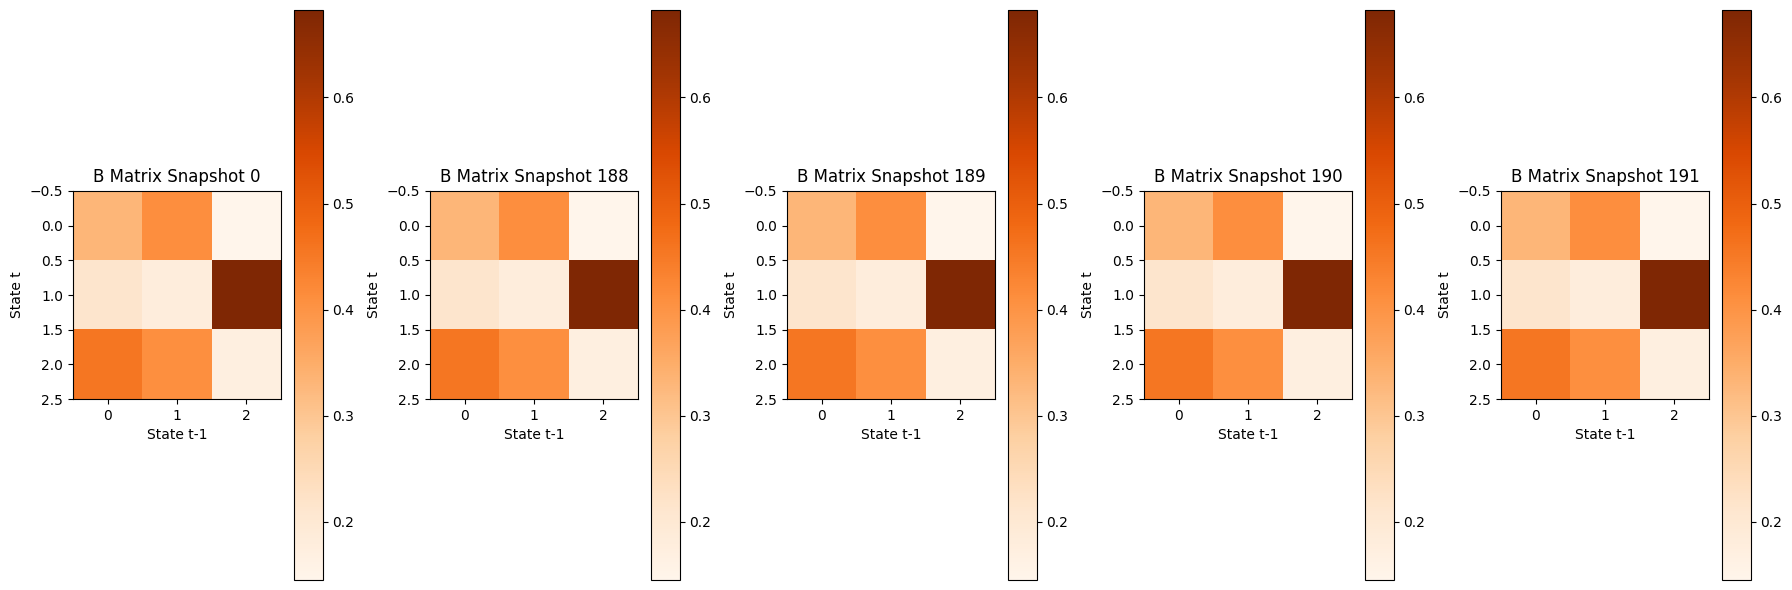

In [ ]:
print("Satiety, action 'eat', food_left=1")
plt.figure(figsize=(18, 6))
plt.subplot(1, num_snapshots, 1)
plt.imshow(B_snapshots1_action1[0][:,1,:], cmap='Oranges', interpolation='nearest')
plt.colorbar()
plt.title(f'B Matrix Snapshot {0}')
plt.xlabel('State t-1')
plt.ylabel('State t')
for i in range(1,num_snapshots):
    plt.subplot(1, num_snapshots, i + 1)
    plt.imshow(B_snapshots1_action1[i+len(B_snapshots0_action0)- 5][:,1,:], cmap='Oranges', interpolation='nearest')
    plt.colorbar()
    plt.title(f'B Matrix Snapshot {i+len(B_snapshots0_action0)- 5}')
    plt.xlabel('State t-1')
    plt.ylabel('State t')
plt.tight_layout()
plt.show()

Satiety, action 'eat', food_left=2


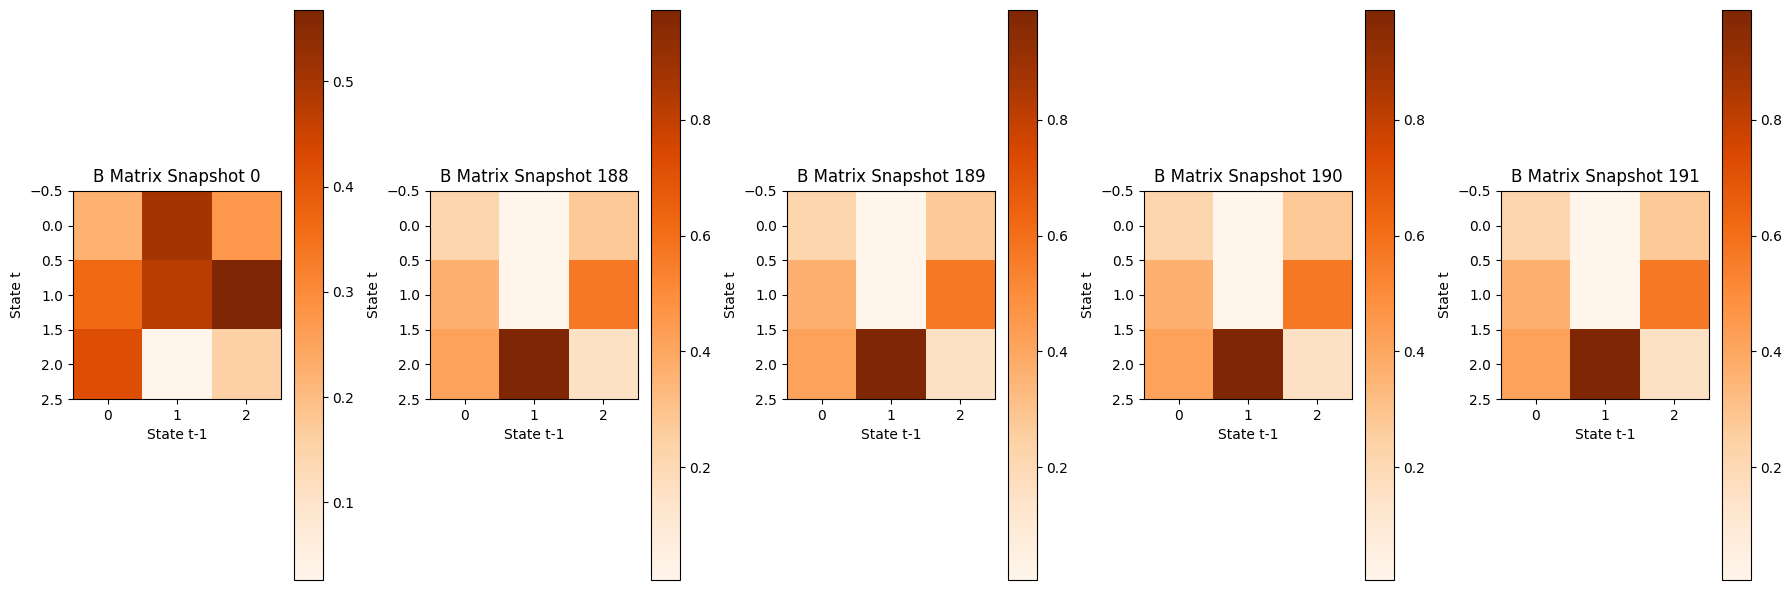

In [ ]:
print("Satiety, action 'eat', food_left=2")
plt.figure(figsize=(18, 6))
plt.subplot(1, num_snapshots, 1)
plt.imshow(B_snapshots1_action1[0][:,2,:], cmap='Oranges', interpolation='nearest')
plt.colorbar()
plt.title(f'B Matrix Snapshot {0}')
plt.xlabel('State t-1')
plt.ylabel('State t')
for i in range(1,num_snapshots):
    plt.subplot(1, num_snapshots, i + 1)
    plt.imshow(B_snapshots1_action1[i+len(B_snapshots0_action0)- 5][:,2,:], cmap='Oranges', interpolation='nearest')
    plt.colorbar()
    plt.title(f'B Matrix Snapshot {i+len(B_snapshots0_action0)- 5}')
    plt.xlabel('State t-1')
    plt.ylabel('State t')
plt.tight_layout()
plt.show()

The B matrices aren't learned perfectly even after a lot of runs.  This is because there will state/action situations the agent never encounters  (or maybe encounter just once) and therefore it never learns. Once it has learned enough about the world in order to survive, and it has a strong preference to survive (which the C matrix has), then it isn't going to go and try something else when it has a perfectly good way of behaving. So it will reinforce learning for those situations. Once the agent has learned what it needs to learn in order to survive, then that is the way it will behave.

Show belief changing animation - it gets saved in the folders

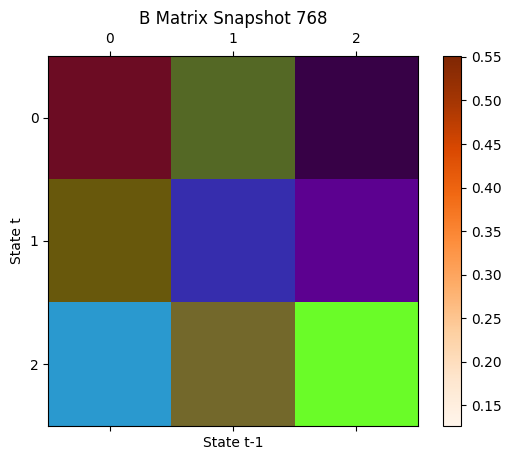

In [ ]:
from matplotlib.animation import FuncAnimation

# Assume B_snapshots is a list of 2D numpy arrays representing the B matrix snapshots
# For demonstration, let's create some dummy B_snapshots data
# B_snapshots = [np.random.rand(10, 10) for _ in range(50)]  # Replace with your actual B_snapshots data

B_snapshots = (
    B_snapshots0_action0 +
    B_snapshots0_action1 +
    B_snapshots1_action0 +
    B_snapshots1_action1
)
# Step 1: Set up the figure and axis
fig, ax = plt.subplots()
cax = ax.matshow(B_snapshots[0], cmap='Oranges')
plt.colorbar(cax)
plt.xlabel('State t-1')
plt.ylabel('State t')

# Step 2: Define the update function
def update(frame):
    cax.set_array(B_snapshots[frame])
    ax.set_title(f'B Matrix Snapshot {frame+1}')
    return [cax]

# Step 3: Create the animation
ani = FuncAnimation(fig, update, frames=len(B_snapshots), interval=200)

# Step 4: Save or display the animation
# Save as GIF
ani.save('B_matrix_animation.gif', writer='imagemagick')

# Save as MP4 video
# ani.save('B_matrix_animation.mp4', writer='ffmpeg')

# Alternatively, you can display the animation inline (useful for Jupyter Notebooks)
plt.show()

**Plot aggregated results**

observations_list[0] [[array([2]), array([1])], [array([1]), array([2])], [array([2]), array([1])], [array([1]), array([2])], [array([2]), array([1])], [array([1]), array([2])], [array([2]), array([1])], [array([1]), array([2])], [array([2]), array([1])], [array([1]), array([2])]]
padded_actions_list [[2, 1, 2, 1, 2, 1, 2, 1, 2, 1], [2, 1, 2, 1, 2, 1, 2, 1, 2, 1], [2, 1, 2, 1, 2, 1, 2, 1, 2, 1], [2, 1, 2, 1, 2, 1, 2, 1, 2, 1], [2, 1, 2, 1, 2, 1, 2, 1, 2, 1], [2, 1, 2, 1, 2, 1, 2, 1, 2, 1], [2, 1, 2, 1, 2, 1, 2, 1, 2, 1], [2, 1, 2, 1, 2, 1, 2, 1, 2, 1], [2, 1, 2, 1, 2, 1, 2, 1, 2, 1], [2, 1, 2, 1, 2, 1, 2, 1, 2, 1], [2, 1, 2, 1, 2, 1, 2, 1, 2, 1], [2, 1, 2, 1, 2, 1, 2, 1, 2, 1], [2, 1, 2, 1, 2, 1, 2, 1, 2, 1], [2, 1, 2, 1, 2, 1, 2, 1, 2, 1], [2, 1, 2, 1, 2, 1, 2, 1, 2, 1], [2, 1, 2, 1, 2, 1, 2, 1, 2, 1], [2, 1, 2, 1, 2, 1, 2, 1, 2, 1], [2, 1, 2, 1, 2, 1, 2, 1, 2, 1], [2, 1, 2, 1, 2, 1, 2, 1, 2, 1], [2, 1, 2, 1, 2, 1, 2, 1, 2, 1]]
padded_observation_list [[[array([2]), array([1])], [arra

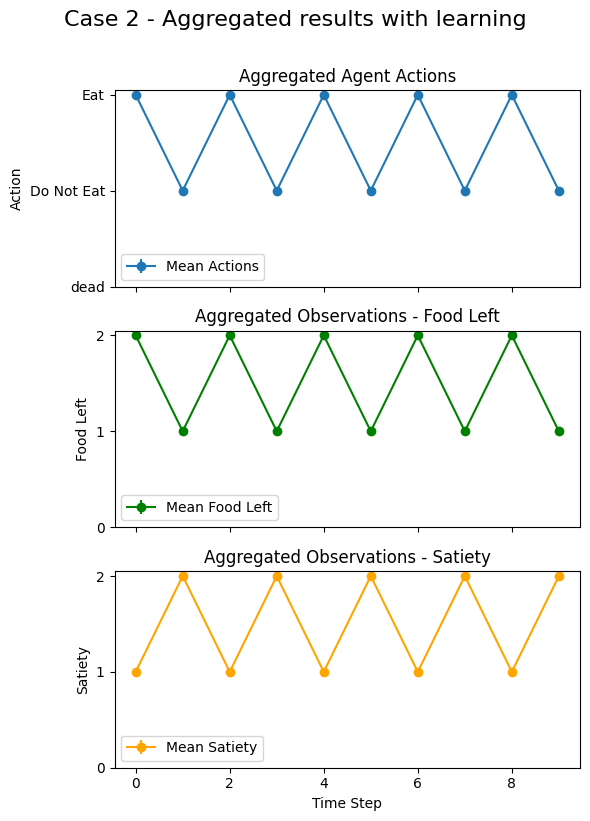

In [ ]:
# Aggregated results
num_runs = len(observations_list)
T = len(observations_list[0])
print("observations_list[0]", observations_list[0])

# Add 1 to all existing values in the action list
new_actions_list = [[x + 1 for x in lst] for lst in actions_list]

# Find the maximum length of sublists for actions and observations
max_len_act = max(len(lst) for lst in new_actions_list)
max_len_obs = max(len(run) for run in observations_list)

# Ensure max_len_act and max_len_obs are consistent with T
max_len_act = max(max_len_act, T)
max_len_obs = max(max_len_obs, T)

# Pad the sublists for actions and observations to ensure each run has T elements
padded_actions_list = [lst + [0] * (T - len(lst)) for lst in new_actions_list]
padded_observations_list = [
    run + [[np.array([2]), np.array([0])]] * (T - len(run)) for run in observations_list
]

print("padded_actions_list", padded_actions_list)
print("padded_observation_list", padded_observations_list)

# Initialize numpy arrays for actions, food left, and satiety
actions_array = np.zeros((num_runs, T))
food_left_array = np.zeros((num_runs, T))
satiety_array = np.zeros((num_runs, T))

# Populate the arrays with the padded lists
for run in range(num_runs):
    actions_array[run, :] = padded_actions_list[run]
    food_left_array[run, :] = [obs[0][0] for obs in padded_observations_list[run]]
    satiety_array[run, :] = [obs[1][0] for obs in padded_observations_list[run]]

# Calculate mean and standard deviation
mean_actions = np.mean(actions_array, axis=0)
std_actions = np.std(actions_array, axis=0)

mean_food_left = np.mean(food_left_array, axis=0)
std_food_left = np.std(food_left_array, axis=0)

mean_satiety = np.mean(satiety_array, axis=0)
std_satiety = np.std(satiety_array, axis=0)

# Plot the aggregated results
time_steps = range(T)

fig, axs = plt.subplots(3, 1, figsize=(6, 8), sharex=True)

# Plotting aggregated actions
axs[0].errorbar(time_steps, mean_actions, yerr=std_actions, fmt='-o', label='Mean Actions')
axs[0].set_ylabel("Action")
axs[0].set_title("Aggregated Agent Actions")
axs[0].set_yticks([0, 1, 2])
axs[0].set_yticklabels(["dead", "Do Not Eat", "Eat"])
axs[0].legend()

# Plotting aggregated observations - food left
axs[1].errorbar(time_steps, mean_food_left, yerr=std_food_left, fmt='-o', color='green', label='Mean Food Left')
axs[1].set_ylabel("Food Left")
axs[1].set_title("Aggregated Observations - Food Left")
axs[1].set_yticks([0, 1, 2])
axs[1].legend()

# Plotting aggregated observations - satiety
axs[2].errorbar(time_steps, mean_satiety, yerr=std_satiety, fmt='-o', color='orange', label='Mean Satiety')
axs[2].set_ylabel("Satiety")
axs[2].set_title("Aggregated Observations - Satiety")
axs[2].set_yticks([0, 1, 2])
axs[2].legend()

plt.xlabel("Time Step")
plt.tight_layout()

fig.suptitle("Case 2 - Aggregated results with learning", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.92)

plt.show()

### AIF loop without learning - better than 2.2


With respect to 2.2, here we added to the loop *qs_prev*, i.e. the agent's belief about the state of the environment in the previous time step. This is inferred from the observation at the previous time step using the agent's state inference method. Moreover, here we do not reset the agent at every run.

In [ ]:
# Number of runs and time steps
num_runs = 20
T = 10

actions_list = []
observations_list = []
survival_time_no_learning=[] # in addition with respect to 2.2 AIF loop

my_new_agent2.reset() #we reset the agent outside the loop, different from 2.2 AIF loop


for run in range(num_runs):

    actions = []
    observations = []
    env = room_Env2()
    current_state = env.reset()


    satiety_zero_count = 0

    for t in range(T):
        if t == 0:
            observation = [np.array([current_state[0]]), np.array([current_state[1]])]
            # pk in addition to 2.2 AIF loop
            qs_prev = my_new_agent2.infer_states(observation)
        else:
            obs = env.step(action)
            observation = [np.array([obs[0]]), np.array([obs[1]])]

            # print(f"Observation: {observation}")
            # print()

        # Update the agent's belief about the current state based on the observation
        qs = my_new_agent2.infer_states(observation)

        # Infer policies based on the updated beliefs
        my_new_agent2.infer_policies()


        # Sample the next action from the inferred policies
        action = my_new_agent2.sample_action()

        if isinstance(action, np.ndarray) and action.size == 1:
            action = int(action.item())
        elif isinstance(action, np.ndarray) and action.ndim > 0:
            action = int(action[0])
        else:
            print("Unexpected action format. Terminating loop.")
            break



        if observation[1] == 0:
            satiety_zero_count += 1
        else:
            satiety_zero_count = 0

        if satiety_zero_count >= 1: # like before, agent dies if satiety = 0 last more than 1 ts
            print(f"AGENT DIED OF STARVATION IN RUN {run + 1}.")
            survival_time_no_learning.append(t)
            break


         # store results for this timestep
        actions.append(action)
        observations.append(observation)

        # # print results for this timestep
        # print(f"Run {run + 1}")
        # print(f"Time step {t}, Action taken: {action}")

        actions.append(action)
        observations.append(observation)
        previous_observation = observation

    # store results for this run
    actions_list.append(actions)
    observations_list.append(observations)
    if t==T-1:
      survival_time_no_learning.append(t)
      print(f"AGENT SURVIVED IN RUN {run + 1}.")

AGENT SURVIVED IN RUN 1.
AGENT SURVIVED IN RUN 2.
AGENT SURVIVED IN RUN 3.
AGENT SURVIVED IN RUN 4.
AGENT SURVIVED IN RUN 5.
AGENT SURVIVED IN RUN 6.
AGENT SURVIVED IN RUN 7.
AGENT SURVIVED IN RUN 8.
AGENT SURVIVED IN RUN 9.
AGENT SURVIVED IN RUN 10.
AGENT SURVIVED IN RUN 11.
AGENT SURVIVED IN RUN 12.
AGENT SURVIVED IN RUN 13.
AGENT SURVIVED IN RUN 14.
AGENT SURVIVED IN RUN 15.
AGENT SURVIVED IN RUN 16.
AGENT SURVIVED IN RUN 17.
AGENT SURVIVED IN RUN 18.
AGENT SURVIVED IN RUN 19.
AGENT SURVIVED IN RUN 20.


 Sometimes the agent can survive even without learning because of random initialization of the B matrix seeds.

**Plot aggregated results**

observations_list[0] [[array([2]), array([1])], [array([2]), array([1])], [array([1]), array([2])], [array([1]), array([2])], [array([2]), array([1])], [array([2]), array([1])], [array([1]), array([2])], [array([1]), array([2])], [array([2]), array([1])], [array([2]), array([1])], [array([1]), array([2])], [array([1]), array([2])], [array([2]), array([1])], [array([2]), array([1])], [array([1]), array([2])], [array([1]), array([2])], [array([2]), array([1])], [array([2]), array([1])], [array([1]), array([2])], [array([1]), array([2])]]
padded_actions_list [[2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1], [2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1], [2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1], [2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1], [2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1], [2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1], [2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1], [2,

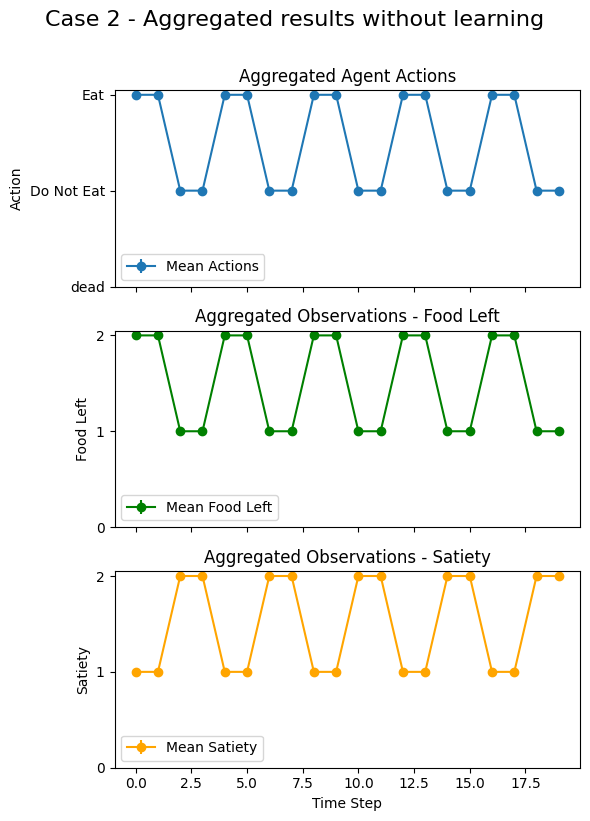

In [ ]:
# Aggregated results
num_runs = len(observations_list)
T = len(observations_list[0])
print("observations_list[0]", observations_list[0])

# Add 1 to all existing values in the action list
new_actions_list = [[x + 1 for x in lst] for lst in actions_list]

# Find the maximum length of sublists for actions and observations
max_len_act = max(len(lst) for lst in new_actions_list)
max_len_obs = max(len(run) for run in observations_list)

# Pad the sublists for actions and observations to ensure each run has T elements
padded_actions_list = [lst + [0] * (T - len(lst)) for lst in new_actions_list]
padded_observations_list = [
    run + [[np.array([2]), np.array([0])]] * (T - len(run)) for run in observations_list
]

print("padded_actions_list", padded_actions_list)
print("padded_observation_list", padded_observations_list)

# Initialize numpy arrays for actions, food left, and satiety
actions_array = np.zeros((num_runs, T))
food_left_array = np.zeros((num_runs, T))
satiety_array = np.zeros((num_runs, T))

# Populate the arrays with the padded lists
for run in range(num_runs):
    actions_array[run, :] = padded_actions_list[run]
    food_left_array[run, :] = [obs[0][0] for obs in padded_observations_list[run]]
    satiety_array[run, :] = [obs[1][0] for obs in padded_observations_list[run]]

# Calculate mean and standard deviation
mean_actions = np.mean(actions_array, axis=0)
std_actions = np.std(actions_array, axis=0)

mean_food_left = np.mean(food_left_array, axis=0)
std_food_left = np.std(food_left_array, axis=0)

mean_satiety = np.mean(satiety_array, axis=0)
std_satiety = np.std(satiety_array, axis=0)

# Plot the aggregated results
time_steps = range(T)

fig, axs = plt.subplots(3, 1, figsize=(6, 8), sharex=True)

# Plotting aggregated actions
axs[0].errorbar(time_steps, mean_actions, yerr=std_actions, fmt='-o', label='Mean Actions')
axs[0].set_ylabel("Action")
axs[0].set_title("Aggregated Agent Actions")
axs[0].set_yticks([0, 1, 2])
axs[0].set_yticklabels(["dead", "Do Not Eat", "Eat"])
axs[0].legend()

# Plotting aggregated observations - food left
axs[1].errorbar(time_steps, mean_food_left, yerr=std_food_left, fmt='-o', color='green', label='Mean Food Left')
axs[1].set_ylabel("Food Left")
axs[1].set_title("Aggregated Observations - Food Left")
axs[1].set_yticks([0, 1, 2])
axs[1].legend()

# Plotting aggregated observations - satiety
axs[2].errorbar(time_steps, mean_satiety, yerr=std_satiety, fmt='-o', color='orange', label='Mean Satiety')
axs[2].set_ylabel("Satiety")
axs[2].set_title("Aggregated Observations - Satiety")
axs[2].set_yticks([0, 1, 2])
axs[2].legend()

plt.xlabel("Time Step")
plt.tight_layout()

fig.suptitle("Case 2 - Aggregated results without learning", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.92)

plt.show()

### Comparison plot

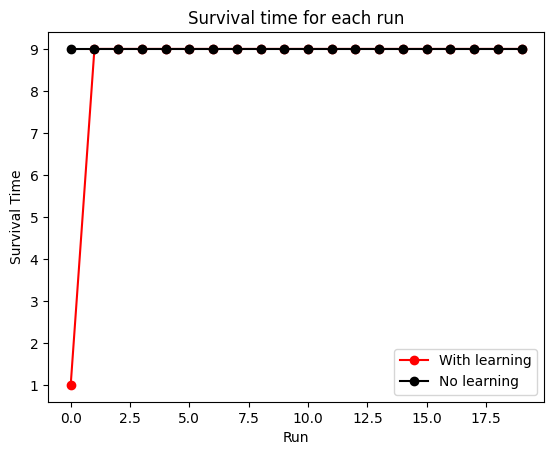

In [ ]:
plt.figure()
plt.plot(survival_time_with_learning,"ro-", label="With learning")
plt.plot(survival_time_no_learning,"ko-", label="No learning")
plt.title("Survival time for each run")
plt.xlabel("Run")
plt.ylabel("Survival Time")
plt.legend()
plt.show()

### 10 agents in the learning loop

Since the trajectory of learning is different every time you run it because of different rando initial seed values for the B matrices, we take the previous loop and put in another loop so it runs for 10 agents. (We put the limit to 10 just because google colab does not handle more for showing the output results.)

In [ ]:
# Function to run the simulation for a single agent
def run_simulation(num_runs=20, T=10):
    actions_list = []
    observations_list = []
    B_snapshots0_action0 = []
    B_snapshots0_action1 = []
    B_snapshots1_action0 = []
    B_snapshots1_action1 = []
    survival_time_with_learning = []

    for run in range(num_runs):
        actions = []
        observations = []
        env = room_Env2()
        current_state = env.reset()
        my_new_agent2.reset()

        satiety_zero_count = 0

        for t in range(T):
            if t == 0:
                observation = [np.array([current_state[0]]), np.array([current_state[1]])]
                qs_prev = my_new_agent2.infer_states(observation)
            else:
                obs = env.step(action)
                observation = [np.array([obs[0]]), np.array([obs[1]])]

            # Store snapshot of B matrix for different actions
            B_snapshots0_action0.append(my_new_agent2.B[0][:, :, 0].copy())
            B_snapshots0_action1.append(my_new_agent2.B[0][:, :, 1].copy())
            B_snapshots1_action0.append(my_new_agent2.B[1][:, :, 0].copy())
            B_snapshots1_action1.append(my_new_agent2.B[1][:, :, 1].copy())

            # Update the agent's belief about the current state based on the observation
            qs = my_new_agent2.infer_states(observation)

            # Infer policies based on the updated beliefs
            my_new_agent2.infer_policies()

            if t > 0:
                qB = my_new_agent2.update_B(qs_prev)
                qs_prev = qs

            # Sample the next action from the inferred policies
            action = my_new_agent2.sample_action()

            if isinstance(action, np.ndarray) and action.size == 1:
                action = int(action.item())
            elif isinstance(action, np.ndarray) and action.ndim > 0:
                action = int(action[0])
            else:
                print("Unexpected action format. Terminating loop.")
                break

            if observation[1] == 0:
                satiety_zero_count += 1
            else:
                satiety_zero_count = 0

            if satiety_zero_count >= 1:  # Agent dies if satiety = 0 lasts more than 1 time step
                print(f"AGENT DIED OF STARVATION IN RUN {run + 1}.")
                survival_time_with_learning.append(t)
                break

            # Store results for this time step
            actions.append(action)
            observations.append(observation)
            previous_observation = observation

        # Store results for this run
        actions_list.append(actions)
        observations_list.append(observations)
        if t == T - 1:
            survival_time_with_learning.append(t)
            print(f"AGENT SURVIVED IN RUN {run + 1}.")

    return actions_list, observations_list, survival_time_with_learning, B_snapshots0_action0, B_snapshots0_action1, B_snapshots1_action0, B_snapshots1_action1

In [ ]:
# Number of agents to simulate
num_agents = 10
num_runs = 20
T = 10

all_actions_list = []
all_observations_list = []
all_survival_times_with_learning = []
all_B_snapshots0_action0 = []
all_B_snapshots0_action1 = []
all_B_snapshots1_action0 = []
all_B_snapshots1_action1 = []

# Run the simulation for each agent
for agent in range(num_agents):
    print(f"Running simulation for agent {agent + 1}")
    actions_list, observations_list, survival_time_with_learning, B_snapshots0_action0, B_snapshots0_action1, B_snapshots1_action0, B_snapshots1_action1 = run_simulation(num_runs, T)

    all_actions_list.append(actions_list)
    all_observations_list.append(observations_list)
    all_survival_times_with_learning.extend(survival_time_with_learning)
    all_B_snapshots0_action0.extend(B_snapshots0_action0)
    all_B_snapshots0_action1.extend(B_snapshots0_action1)
    all_B_snapshots1_action0.extend(B_snapshots1_action0)
    all_B_snapshots1_action1.extend(B_snapshots1_action1)

# Create a combined list of all B matrix snapshots
B_snapshots = (
    all_B_snapshots0_action0 +
    all_B_snapshots0_action1 +
    all_B_snapshots1_action0 +
    all_B_snapshots1_action1
)

Running simulation for agent 1
AGENT SURVIVED IN RUN 1.
AGENT SURVIVED IN RUN 2.
AGENT SURVIVED IN RUN 3.
AGENT SURVIVED IN RUN 4.
AGENT SURVIVED IN RUN 5.
AGENT SURVIVED IN RUN 6.
AGENT SURVIVED IN RUN 7.
AGENT SURVIVED IN RUN 8.
AGENT SURVIVED IN RUN 9.
AGENT SURVIVED IN RUN 10.
AGENT SURVIVED IN RUN 11.
AGENT SURVIVED IN RUN 12.
AGENT SURVIVED IN RUN 13.
AGENT SURVIVED IN RUN 14.
AGENT SURVIVED IN RUN 15.
AGENT SURVIVED IN RUN 16.
AGENT SURVIVED IN RUN 17.
AGENT SURVIVED IN RUN 18.
AGENT SURVIVED IN RUN 19.
AGENT SURVIVED IN RUN 20.
Running simulation for agent 2
AGENT SURVIVED IN RUN 1.
AGENT SURVIVED IN RUN 2.
AGENT SURVIVED IN RUN 3.
AGENT SURVIVED IN RUN 4.
AGENT SURVIVED IN RUN 5.
AGENT SURVIVED IN RUN 6.
AGENT SURVIVED IN RUN 7.
AGENT SURVIVED IN RUN 8.
AGENT SURVIVED IN RUN 9.
AGENT SURVIVED IN RUN 10.
AGENT SURVIVED IN RUN 11.
AGENT SURVIVED IN RUN 12.
AGENT SURVIVED IN RUN 13.
AGENT SURVIVED IN RUN 14.
AGENT SURVIVED IN RUN 15.
AGENT SURVIVED IN RUN 16.
AGENT SURVIVED IN RU

Then we can do the plot which has an average over 10 agents:

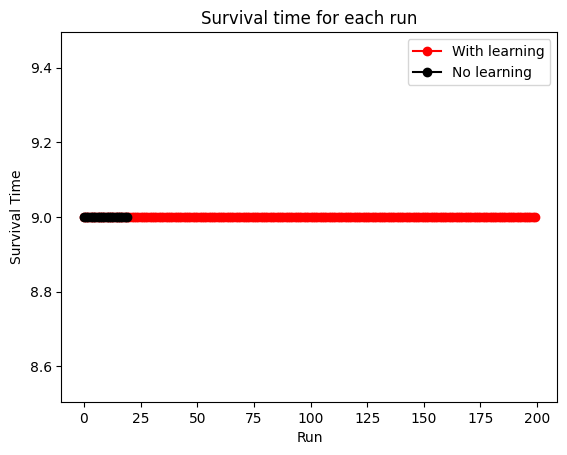

Output streaming troncato alle ultime 5000 righe.
        [1.17168706e-01, 4.11469068e-01],
        [7.40195097e-01, 5.91931599e-04]],

       [[4.44778463e-01, 3.48832668e-01],
        [3.10863238e-01, 1.80176172e-01],
        [1.45154935e-01, 5.59077269e-04]],

       [[4.66976258e-01, 6.03401293e-01],
        [5.71968056e-01, 4.08354760e-01],
        [1.14649967e-01, 9.98848991e-01]]]), array([[[8.82452788e-02, 4.77660392e-02],
        [1.17168706e-01, 4.11469068e-01],
        [7.40195097e-01, 5.91931599e-04]],

       [[4.44778463e-01, 3.48832668e-01],
        [3.10863238e-01, 1.80176172e-01],
        [1.45154935e-01, 5.59077269e-04]],

       [[4.66976258e-01, 6.03401293e-01],
        [5.71968056e-01, 4.08354760e-01],
        [1.14649967e-01, 9.98848991e-01]]]), array([[[8.82452788e-02, 4.77660392e-02],
        [1.17168706e-01, 4.11469068e-01],
        [7.40195097e-01, 5.91232742e-04]],

       [[4.44778463e-01, 3.48832668e-01],
        [3.10863238e-01, 1.80176172e-01],
        [1

In [ ]:
# better aggregate over the different runs and over the priors
# Aggregated results
mean_survival_times_with_learning = np.mean(all_survival_times_with_learning, axis=0)
std_survival_times_with_learning = np.std(all_survival_times_with_learning, axis=0)

# Placeholder for no learning survival times
survival_time_no_learning = [T-1] * num_runs

# Plot aggregated results
plt.figure()
plt.plot(all_survival_times_with_learning, "ro-", label="With learning")
plt.plot(survival_time_no_learning, "ko-", label="No learning")
plt.title("Survival time for each run")
plt.xlabel("Run")
plt.ylabel("Survival Time")
plt.legend()
plt.show()

print("B_snapshots:", B_snapshots)

### Mau - 27/5

this was done without the existing method for updating B matrix, rather we created a new function for that

In [ ]:
#we do not fill in the B matrix
B2_random = utils.random_B_matrix(num_states2, num_controls, B2_factor_list)

In [ ]:
B2_random[0].shape

(3, 3, 2)

In [ ]:
B2_random[1].shape

(3, 3, 3, 2)

In [ ]:
B2_random

array([array([[[0.13164704, 0.43030514],
               [0.03175245, 0.39993164],
               [0.19418541, 0.55681038]],

              [[0.30938254, 0.45317528],
               [0.88488024, 0.53978639],
               [0.7500531 , 0.29201309]],

              [[0.55897042, 0.11651957],
               [0.08336731, 0.06028197],
               [0.05576149, 0.15117653]]]),
       array([[[[0.32938622, 0.4700313 ],
                [0.49214942, 0.54414336],
                [0.30142876, 0.10044221]],

               [[0.52238081, 0.19293279],
                [0.43845287, 0.2466207 ],
                [0.21261042, 0.27592147]],

               [[0.37441341, 0.45148839],
                [0.59320256, 0.18394785],
                [0.33339836, 0.37024906]]],


              [[[0.36901284, 0.17799425],
                [0.04387731, 0.27938631],
                [0.25720217, 0.69337067]],

               [[0.14905631, 0.38700822],
                [0.1812979 , 0.57633501],
                [0.3684821

We have a new my_agent2, with a random B matrix

In [ ]:
my_new_agent2 = Agent(A=A2, B=B2_random, C=C2, B_factor_list=B2_factor_list, policy_len = 3, policies=None, action_selection="stochastic")

In [ ]:
#we restrict policies as before
my_new_agent2.policies = restricted_policies

In [ ]:
# to adjust matrix size after having reduced policies
my_new_agent2.E = my_new_agent2._construct_E_prior()

In [ ]:
# from Collis, Kinghorn (https://github.com/PoppyCollis/METATOOL_UoS/blob/master/agent.py)

#def update_B(self, qs_prev):

      #  Update posterior beliefs about Dirichlet parameters that parameterise the transition likelihood

 #       qB = learning.update_state_likelihood_dirichlet_interactions(
  #          self.pB,
   #         self.B,
     #       self.action,
    #      self.qs,
     #       qs_prev,
      #      self.B_factor_list,
       #     self.lr_pB,
    #        self.factors_to_learn
     #   )

     #   self.pB = qB # set new prior to posterior
     #   self.B = utils.norm_dist_obj_arr(qB)  # take expected value of posterior Dirichlet parameters to calculate posterior over B array

      #  return qB


make sure the following are well defined:

In [ ]:
def update_B2_matrix(B2_random, state_t_minus_1, state_t, action, B2_factor_list, learning_rate=0.1):
    """
    Update the B matrix based on observed transitions using a learning rate.
    :param B2_random: The current B matrix.
    :param state_t_minus_1: The state at time t-1.
    :param state_t: The state at time t.
    :param action: The action taken.
    :param factor_list: The factor list specifying dependencies between hidden state factors and actions.
    :param learning_rate: The learning rate for updating B.
    :return: The updated B matrix.
    """
    B2_updated = B2_random.copy()
    for f, factors in enumerate(B2_factor_list):
        if len(factors) == 1:
            print("action", action)
            print("f",f)
            print("the updated factor before update f for one factor", B2_updated[f][state_t[f], state_t_minus_1[factors[0]], action])
            # Single factor dependency
            B2_updated[f][state_t[f], state_t_minus_1[factors[0]], action] += learning_rate
            print("the updated factor after update f for one factor", B2_updated[f][state_t[f], state_t_minus_1[factors[0]], action])
            # Normalize the updated B matrix
            sums = B2_updated[f][:, state_t_minus_1[factors[0]], action].sum(axis=0, keepdims=True)
            B2_updated[f][:, state_t_minus_1[factors[0]], action] /= sums

            print("I ran the update on 1 factor")

        elif len(factors) == 2:
            print("action", action)
            print("f",f)
            print("the updated factor before update", B2_updated[f][:, state_t_minus_1[factors[0]], state_t_minus_1[factors[1]], action])
            # Two-factor dependency
            B2_updated[f][state_t[f], state_t_minus_1[factors[0]], state_t_minus_1[factors[1]], action] += learning_rate
            print("the updated factor after update", B2_updated[f][:, state_t_minus_1[factors[0]], state_t_minus_1[factors[1]], action])
            # Normalize the updated B matrix
            sums = B2_updated[f][:, state_t_minus_1[factors[0]], state_t_minus_1[factors[1]], action].sum(axis=0, keepdims=True)
            print("sums", sums)


            B2_updated[f][:, state_t_minus_1[factors[0]], state_t_minus_1[factors[1]], action] /= sums

            # print("B2_updated", B2_updated)

    return B2_updated


In [ ]:
# Number of runs and time steps
num_runs = 4
T = 10

actions_list = []
observations_list = []
B_snapshots = []

for run in range(num_runs):
    actions = []
    observations = []
    env = room_Env2()
    current_state = env.reset()
    my_new_agent2.reset()

    satiety_zero_count = 0

    for t in range(T):
        if t == 0:
            observation = [np.array([current_state[0]]), np.array([current_state[1]])]
        else:
            obs = env.step(action)
            observation = [np.array([obs[0]]), np.array([obs[1]])]

            print(f"Observation: {observation}")
            print()

            # Update the B matrix based on observed transition
            state_t_minus_1 = previous_observation
            state_t = obs
            my_new_agent2.B = update_B2_matrix(my_new_agent2.B, state_t_minus_1, state_t, action, B2_factor_list=[[0], [0,1]])

# Store snapshot of B matrix for the first factor and first action
        B_snapshots.append(my_new_agent2.B[0][:, :, 1].copy())

        # Update the agent's belief about the current state based on the observation
        qs = my_new_agent2.infer_states(observation)

        # Infer policies based on the updated beliefs
        my_new_agent2.infer_policies()

        # Sample the next action from the inferred policies
        action = my_new_agent2.sample_action()

        if isinstance(action, np.ndarray) and action.size == 1:
            action = int(action.item())
        elif isinstance(action, np.ndarray) and action.ndim > 0:
            action = int(action[0])
        else:
            print("Unexpected action format. Terminating loop.")
            break

        if observation[1] == 0:
            satiety_zero_count += 1
        else:
            satiety_zero_count = 0

        if satiety_zero_count >= 1: # like before, agent dies if satiety = 0 last more than 1 ts
            print(f"AGENT DIED OF STARVATION IN RUN {run + 1}.")
            break

         # store results for this timestep
        actions.append(action)
        observations.append(observation)

        # print results for this timestep
        print(f"Run {run + 1}")
        print(f"Time step {t}, Action taken: {action}")

        actions.append(action)
        observations.append(observation)
        previous_observation = observation

    # store results for this run
    actions_list.append(actions)
    observations_list.append(observations)

Run 1
Time step 0, Action taken: 1
Observation: [array([1]), array([2])]

action 1
f 0
the updated factor before update f for one factor [0.29201309]
the updated factor after update f for one factor [0.39201309]
I ran the update on 1 factor
action 1
f 1
the updated factor before update [[0.18394785]
 [0.554379  ]
 [0.26167314]]
the updated factor after update [[0.18394785]
 [0.554379  ]
 [0.36167314]]
sums [[1.1]]
Run 1
Time step 1, Action taken: 1
Observation: [array([0]), array([2])]

action 1
f 0
the updated factor before update f for one factor [0.39993164]
the updated factor after update f for one factor [0.49993164]
I ran the update on 1 factor
action 1
f 1
the updated factor before update [[0.27592147]
 [0.48875341]
 [0.23532513]]
the updated factor after update [[0.27592147]
 [0.48875341]
 [0.33532513]]
sums [[1.1]]
Run 1
Time step 2, Action taken: 1
Observation: [array([0]), array([1])]

action 1
f 0
the updated factor before update f for one factor [0.43030514]
the updated fa

Agent should die

Aggregation plots with padded lists

In [ ]:
# Aggregated results
num_runs = len(observations_list)
T = len(observations_list[0])
print("observations_list[0]",observations_list[0])

# Add 1 to all existing values
new_actions_list = [[x + 1 for x in lst] for lst in actions_list]

# Find the maximum length of sublists
max_len_act = max(len(lst) for lst in new_actions_list)
print("max_len_act", max_len_act)
print("T", T)
# Find the maximum length of observation sublists
max_len_obs = max(len(run) for run in observations_list)
print("max_len_obs", max_len_obs)


# Pad the sublists
padded_actions_list = [lst + [0] * (T - len(lst)) for lst in new_actions_list]
print("padded_actions_list", padded_actions_list)


# Pad the observations to ensure each run has T observations
padded_observations_list = [
    run + [[np.array([2]), np.array([0])]] * (T - len(run)) for run in observations_list
]


print("observation_list ", observations_list )
print("padded_observation_list ", padded_observations_list )

# # Convert to a numpy array
# action_list_array = np.array(padded_actions_list)
# print("Shape of the actions list array:", action_list_array.shape)
# print("Padded and incremented actions list array:\n", action_list_array)

food_left_array = np.zeros((num_runs, T))
satiety_array = np.zeros((num_runs, T))

for run in range(num_runs):

    actions_array[run, :] = padded_actions_list[run]
    print("actions_array[run, :]", actions_array[run, :])
    food_left_array[run, :] = [obs[0][0] for obs in padded_observations_list[run]]
    satiety_array[run, :] = [obs[1][0] for obs in padded_observations_list[run]]

# Calculate mean and standard deviation
mean_actions = np.mean(actions_array, axis=0)
std_actions = np.std(actions_array, axis=0)

mean_food_left = np.mean(food_left_array, axis=0)
std_food_left = np.std(food_left_array, axis=0)

mean_satiety = np.mean(satiety_array, axis=0)
std_satiety = np.std(satiety_array, axis=0)

# Plot the aggregated results
time_steps = range(T)

fig, axs = plt.subplots(3, 1, figsize=(6, 8), sharex=True)

# Plotting aggregated actions
axs[0].errorbar(time_steps, mean_actions, yerr=std_actions, fmt='-o', label='Mean Actions')
axs[0].set_ylabel("Action")
axs[0].set_title("Aggregated Agent Actions")
axs[0].set_yticks([0, 1, 2])
axs[0].set_yticklabels(["dead","Do Not Eat", "Eat"])
axs[0].legend()

# Plotting aggregated observations - food left
axs[1].errorbar(time_steps, mean_food_left, yerr=std_food_left, fmt='-o', color='green', label='Mean Food Left')
axs[1].set_ylabel("Food Left")
axs[1].set_title("Aggregated Observations - Food Left")
axs[1].set_yticks([0, 1, 2])
axs[1].legend()

# Plotting aggregated observations - satiety
axs[2].errorbar(time_steps, mean_satiety, yerr=std_satiety, fmt='-o', color='orange', label='Mean Satiety')
axs[2].set_ylabel("Satiety")
axs[2].set_title("Aggregated Observations - Satiety")
axs[2].set_yticks([0, 1, 2])
axs[2].legend()

plt.xlabel("Time Step")
plt.tight_layout()

fig.suptitle("Case 2 - Aggregated results from 3 runs with learning", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.92)

plt.show()

observations_list[0] [[array([2]), array([1])], [array([2]), array([1])], [array([1]), array([2])], [array([1]), array([2])], [array([0]), array([2])], [array([0]), array([2])], [array([0]), array([1])], [array([0]), array([1])]]
max_len_act 8
T 8
max_len_obs 8
padded_actions_list [[2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 1, 1, 1, 1]]
observation_list  [[[array([2]), array([1])], [array([2]), array([1])], [array([1]), array([2])], [array([1]), array([2])], [array([0]), array([2])], [array([0]), array([2])], [array([0]), array([1])], [array([0]), array([1])]], [[array([2]), array([1])], [array([2]), array([1])], [array([1]), array([2])], [array([1]), array([2])], [array([0]), array([2])], [array([0]), array([2])], [array([0]), array([1])], [array([0]), array([1])]], [[array([2]), array([1])], [array([2]), array([1])], [array([1]), array([2])], [array([1]), array([2])], [array([0]), array([2])], [array([0]), array([2])], [array([0]), arra

ValueError: could not broadcast input array from shape (8,) into shape (10,)

In [ ]:
# Plot snapshots of the updated B matrix for one of the factors as an example
num_snapshots = min(len(B_snapshots), 50)  # Limit to 5 snapshots for clarity

plt.figure(figsize=(18, 6))
for i in range(num_snapshots):
    plt.subplot(1, num_snapshots, i + 1)
    plt.imshow(B_snapshots[i], cmap='Oranges', interpolation='nearest')
    plt.colorbar()
    plt.title(f'B Matrix Snapshot {i+1}')
    plt.xlabel('State t-1')
    plt.ylabel('State t')

plt.tight_layout()
plt.show()

Show belief changing animation - it gets saved in the folders

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Assume B_snapshots is a list of 2D numpy arrays representing the B matrix snapshots
# For demonstration, let's create some dummy B_snapshots data
# B_snapshots = [np.random.rand(10, 10) for _ in range(50)]  # Replace with your actual B_snapshots data

# Step 1: Set up the figure and axis
fig, ax = plt.subplots()
cax = ax.matshow(B_snapshots[0], cmap='Oranges')
plt.colorbar(cax)
plt.xlabel('State t-1')
plt.ylabel('State t')

# Step 2: Define the update function
def update(frame):
    cax.set_array(B_snapshots[frame])
    ax.set_title(f'B Matrix Snapshot {frame+1}')
    return [cax]

# Step 3: Create the animation
ani = FuncAnimation(fig, update, frames=len(B_snapshots), interval=200)

# Step 4: Save or display the animation
# Save as GIF
ani.save('B_matrix_animation.gif', writer='imagemagick')

# Save as MP4 video
# ani.save('B_matrix_animation.mp4', writer='ffmpeg')

# Alternatively, you can display the animation inline (useful for Jupyter Notebooks)
plt.show()

Something wrong: matrices are all the same

EDIT!!!! THEY WERE ALL THE SAME BECAUSE YOU WERE ONLY snapshotting action 0, but action 1 was the only one updating as you can see, they are no longer the same now

## **2.4 Extending results** - in progress

### *2.4.1 Wrong matrices*

**Transition model (Planning) - B matrix**

We set a wrong B matrix that maps different food transitions.

In [ ]:
# we set a wrong B2[1] matrix for satiety state to see if the agent learns to behave correctly despite them

In [ ]:
B2_factor_list = [[0], [0,1]] # we add an extra dim to the matrix for satiety state

B3 = utils.random_B_matrix(num_states2, num_controls, B2_factor_list)

In [ ]:
B3[0] = np.copy(B2[0])

In [ ]:
B3[0].shape

(3, 3, 2)

In [ ]:
B3[0]

array([[[0., 1.],
        [0., 1.],
        [0., 0.]],

       [[1., 0.],
        [0., 0.],
        [0., 1.]],

       [[0., 0.],
        [1., 0.],
        [1., 0.]]])

In [ ]:
B3[0][:,:,0]

array([[0., 0., 0.],
       [1., 0., 0.],
       [0., 1., 1.]])

In [ ]:
B3[0][:,:,1]

array([[1., 1., 0.],
       [0., 0., 1.],
       [0., 0., 0.]])

In [ ]:
B3[1].shape

(3, 3, 3, 2)

In [ ]:
B3[1][:,:,:,:] = 0.0

B3[1][0,0,:,0] = 1.0
B3[1][0,1,:,0] = 1.0
B3[1][1,2,:,0] = 1.0

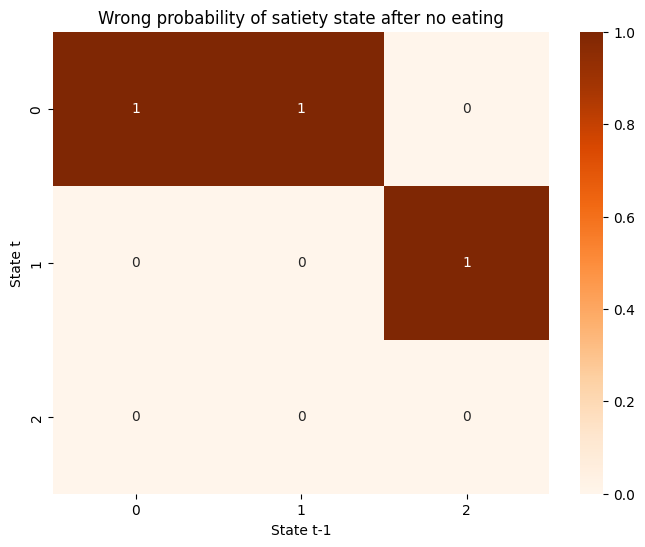

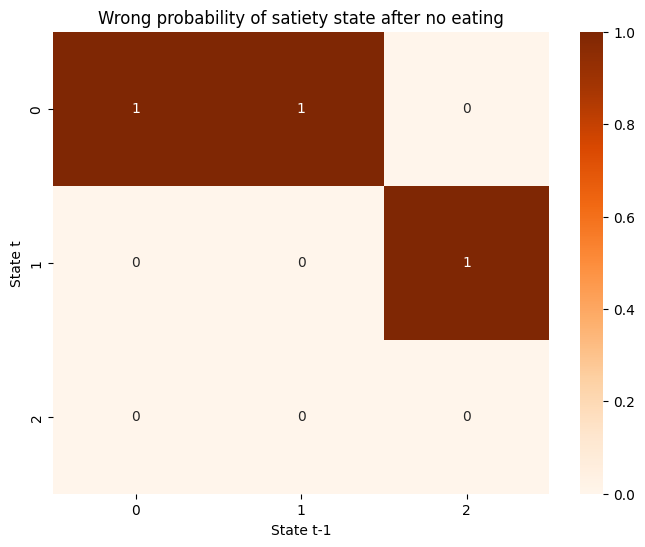

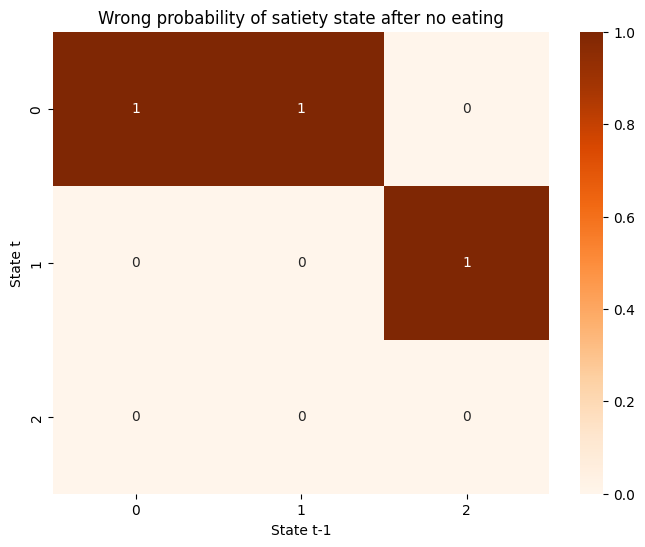

In [ ]:
plot_likelihoodB(B3[1][:,:,0,0], title = 'Wrong probability of satiety state after no eating' )
plot_likelihoodB(B3[1][:,:,1,0], title = 'Wrong probability of satiety state after no eating' )
plot_likelihoodB(B3[1][:,:,2,0], title = 'Wrong probability of satiety state after no eating' )

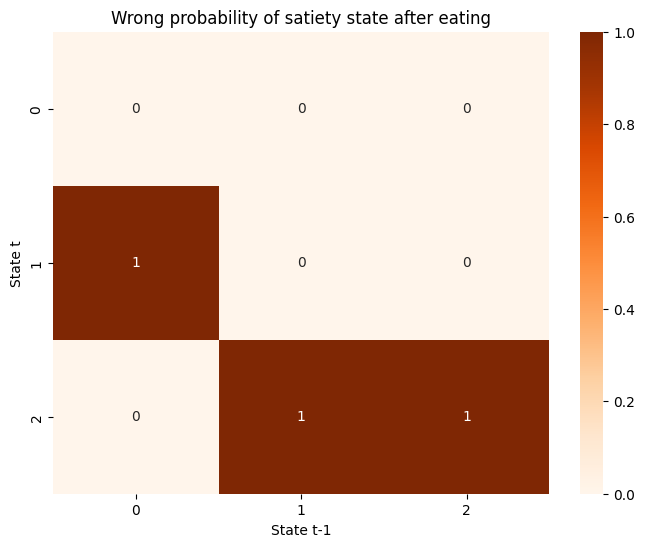

In [ ]:
B3[1][1,0,0,1]=1.0
B3[1][1,1,0,1]=1.0
B3[1][1,2,0,1]=1.0

B3[1][1,0,1,1]=1.0
B3[1][2,1,1,1]=1.0
B3[1][2,2,1,1]=1.0

B3[1][2,0,2,1]=1.0
B3[1][2,1,2,1]=1.0
B3[1][2,2,2,1]=1.0

plot_likelihoodB(B3[1][:,:,1,1], title = 'Wrong probability of satiety state after eating')

In [ ]:
B3[1][:,:,:,0]

array([[[1., 1., 1.],
        [1., 1., 1.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [1., 1., 1.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [ ]:
B3[1][:,:,:,1]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[1., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[0., 0., 1.],
        [0., 1., 1.],
        [0., 1., 1.]]])

In [ ]:
# check if the matrix is normalised
# Sum the probabilities across the first axis (observation probabilities for each state)
sums = B3.sum(axis=0)
sums = B3[1].sum(axis=0)

# Check if all sums are close to 1.0
if np.allclose(sums, 1.0):
    print("The matrix is properly normalised.")
else:
    print("The matrix is not normalised. Sums:", sums)

print("Is the B matrix normalised?", utils.is_normalized(B3))

The matrix is properly normalised.
Is the B matrix normalised? True


In [ ]:
# we set policy_len = 3 because in order to plan the agent need to look further than just 1 ts
my_agent3 = Agent(A=A2, B=B3, pB=pB, C=C2, B_factor_list=B2_factor_list, policy_len = 3, policies=None, action_selection="stochastic")

In [ ]:
my_agent3.policy_len


3

In [ ]:
my_agent3.policies = restricted_policies

In [ ]:
# to adjust matrix size after having reduced policies

my_agent3.E = my_agent3._construct_E_prior()

In [ ]:
len(my_agent3.policies) # 8 policies expected

8

#### No learning

We change the agent in the AIF loop.

In [ ]:
num_runs = 3

# length of active inference loop in time
T = 10

# initialize lists to store results
actions_list = []
observations_list = []
survival_time_no_learning=[]

my_agent3.reset()

for run in range(num_runs):
    env = room_Env2()
    current_state = env.reset() # initialize or reset the env


    actions = []
    observations = []
    satiety_zero_count = 0 # if satiety is 0 for more than 2 ts the agent dies

    for t in range(T):
        # get current observation from the environment
        if t == 0:
            observation = [np.array([current_state[0]]), np.array([current_state[1]])]
              # pk
            qs_prev = my_agent3.infer_states(observation)
        else:
            obs = env.step(action)
            observation = [np.array([obs[0]]), np.array([obs[1]])]

        print(f"Observation: {observation}")
        print()

        # update the agent's belief about the current state based on the observation
        qs = my_agent3.infer_states(observation)  # Update state beliefs

        # infer policies based on the updated beliefs
        my_agent3.infer_policies()

        # sample the next action from the inferred policies
        action = my_agent3.sample_action()

        # handle action based on its type and structure
        if isinstance(action, np.ndarray) and action.size == 1:
            action = int(action.item())  # Convert single-item array to integer
        elif isinstance(action, np.ndarray) and action.ndim > 0:
            action = int(action[0])  # Select the first action if multiple are given
        else:
            print("Unexpected action format. Terminating loop.")
            break

          # Check for satiety level and update the count
        if observation[1] == 0:
            satiety_zero_count += 1
        else:
            satiety_zero_count = 0

          # Terminate loop if satiety = 0 for 1 time step
        if satiety_zero_count >= 1:
            print(f"AGENT DIED OF STARVATION IN RUN {run + 1}.")
            print()
            survival_time_no_learning.append(t)
            break

        # store results for this timestep
        actions.append(action)
        observations.append(observation)
        previous_observation = observation


        # print results for this timestep
        print(f"Run {run + 1}")
        print(f"Time step {t}, Action taken: {action}")


    # Store results for this run
    actions_list.append(actions)
    observations_list.append(observations)
    if t==T-1:
      survival_time_no_learning.append(t)
      print(f"AGENT SURVIVED IN RUN {run + 1}.")

Observation: [array([2]), array([1])]

Run 1
Time step 0, Action taken: 0
Observation: [array([2]), array([0])]

AGENT DIED OF STARVATION IN RUN 1.

Observation: [array([2]), array([1])]

Run 2
Time step 0, Action taken: 0
Observation: [array([2]), array([0])]

AGENT DIED OF STARVATION IN RUN 2.

Observation: [array([2]), array([1])]

Run 3
Time step 0, Action taken: 0
Observation: [array([2]), array([0])]

AGENT DIED OF STARVATION IN RUN 3.



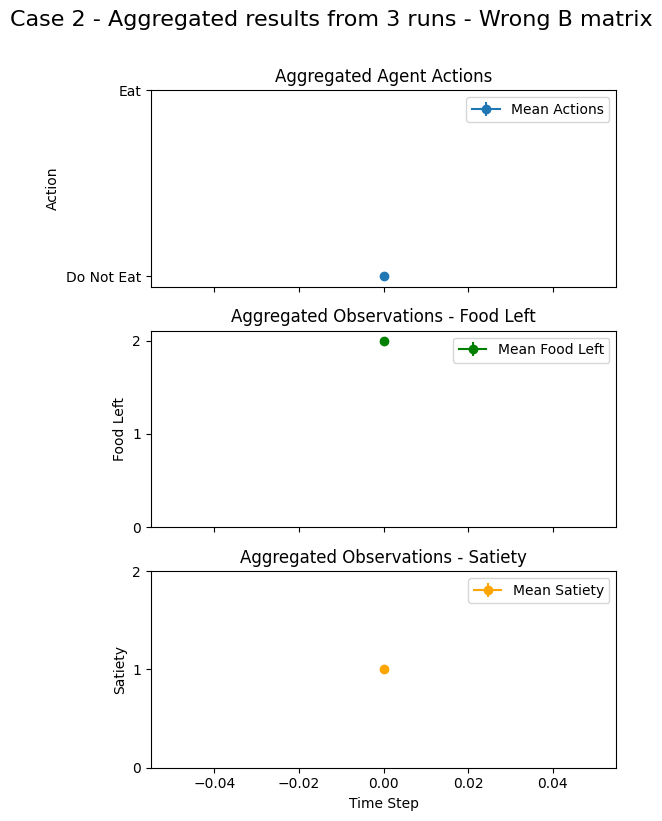

In [ ]:
# Number of runs
num_runs = len(observations_list)
T = len(observations_list[0])

# Initialize arrays to store aggregated data
actions_array = np.zeros((num_runs, T))
food_left_array = np.zeros((num_runs, T))
satiety_array = np.zeros((num_runs, T))

# Populate arrays with data from observations_list
for run in range(num_runs):
    actions_array[run, :] = actions_list[run]
    food_left_array[run, :] = [obs[0][0] for obs in observations_list[run]]
    satiety_array[run, :] = [obs[1][0] for obs in observations_list[run]]

# Calculate mean and standard deviation
mean_actions = np.mean(actions_array, axis=0)
std_actions = np.std(actions_array, axis=0)

mean_food_left = np.mean(food_left_array, axis=0)
std_food_left = np.std(food_left_array, axis=0)

mean_satiety = np.mean(satiety_array, axis=0)
std_satiety = np.std(satiety_array, axis=0)

# Plot the aggregated results
time_steps = range(T)

fig, axs = plt.subplots(3, 1, figsize=(6, 8), sharex=True)

# Plotting aggregated actions
axs[0].errorbar(time_steps, mean_actions, yerr=std_actions, fmt='-o', label='Mean Actions')
axs[0].set_ylabel("Action")
axs[0].set_title("Aggregated Agent Actions")
axs[0].set_yticks([0, 1])
axs[0].set_yticklabels(["Do Not Eat", "Eat"])
axs[0].legend()

# Plotting aggregated observations - food left
axs[1].errorbar(time_steps, mean_food_left, yerr=std_food_left, fmt='-o', color='green', label='Mean Food Left')
axs[1].set_ylabel("Food Left")
axs[1].set_title("Aggregated Observations - Food Left")
axs[1].set_yticks([0, 1, 2])
axs[1].legend()

# Plotting aggregated observations - satiety
axs[2].errorbar(time_steps, mean_satiety, yerr=std_satiety, fmt='-o', color='orange', label='Mean Satiety')
axs[2].set_ylabel("Satiety")
axs[2].set_title("Aggregated Observations - Satiety")
axs[2].set_yticks([0, 1, 2])
axs[2].legend()

plt.xlabel("Time Step")
plt.tight_layout()

fig.suptitle("Case 2 - Aggregated results from 3 runs - Wrong B matrix", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.92)

plt.show()

By setting wrong B matrix the agent does not survive more than 3 time steps for each run.

#### Learning

In [ ]:
# Number of runs and time steps
num_runs = 3
T = 10

actions_list = []
observations_list = []
survival_time_with_learning=[]# in addition with respect to 2.2 AIF loop

my_agent3.reset() #we reset the agent outside the loop


for run in range(num_runs):

    actions = []
    observations = []
    env = room_Env2()
    current_state = env.reset()


    satiety_zero_count = 0

    for t in range(T):
        if t == 0:
            observation = [np.array([current_state[0]]), np.array([current_state[1]])]
            # pk in addition to 2.2 AIF loop
            qs_prev = my_agent3.infer_states(observation)
        else:
            obs = env.step(action)
            observation = [np.array([obs[0]]), np.array([obs[1]])]

            # print(f"Observation: {observation}")
            # print()

        # Update the agent's belief about the current state based on the observation
        qs = my_agent3.infer_states(observation)

        # Infer policies based on the updated beliefs
        my_agent3.infer_policies()

        if t>0:
          qB=my_agent3.update_B(qs_prev)
          qs_prev=qs


        # Sample the next action from the inferred policies
        action = my_agent3.sample_action()

        if isinstance(action, np.ndarray) and action.size == 1:
            action = int(action.item())
        elif isinstance(action, np.ndarray) and action.ndim > 0:
            action = int(action[0])
        else:
            print("Unexpected action format. Terminating loop.")
            break



        if observation[1] == 0:
            satiety_zero_count += 1
        else:
            satiety_zero_count = 0

        if satiety_zero_count >= 1: # like before, agent dies if satiety = 0 last more than 1 ts
            print(f"AGENT DIED OF STARVATION IN RUN {run + 1}.")
            survival_time_no_learning.append(t)
            break


         # store results for this timestep
        actions.append(action)
        observations.append(observation)

        # # print results for this timestep
        # print(f"Run {run + 1}")
        # print(f"Time step {t}, Action taken: {action}")

        actions.append(action)
        observations.append(observation)
        previous_observation = observation

    # store results for this run
    actions_list.append(actions)
    observations_list.append(observations)
    if t==T-1:
      survival_time_with_learning.append(t)
      print(f"AGENT SURVIVED IN RUN {run + 1}.")

AGENT SURVIVED IN RUN 1.
AGENT SURVIVED IN RUN 2.
AGENT SURVIVED IN RUN 3.


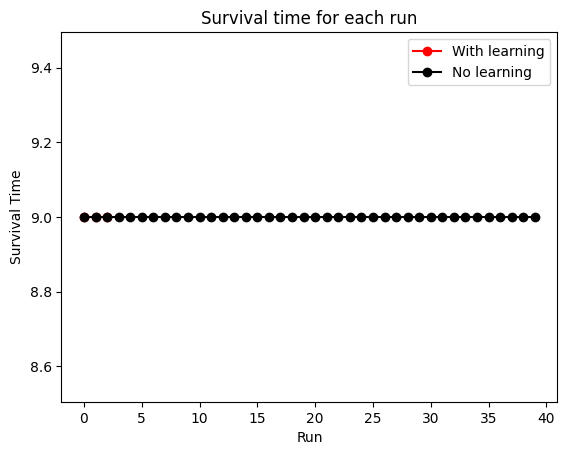

In [ ]:
plt.figure()
plt.plot(survival_time_with_learning,"ro-", label="With learning")
plt.plot(survival_time_no_learning,"ko-", label="No learning")
plt.title("Survival time for each run")
plt.xlabel("Run")
plt.ylabel("Survival Time")
plt.legend()
plt.show()

### *2.4.2 Different prior preferences* - in progress


#### Strong preferences on both states and **no learning**
Now we set an agent that has a strong preference for food present, while before it did not care about that.

In [ ]:
# create prior preferences over observations

C3 = utils.obj_array_zeros([num_obs2])
C3

array([array([[0., 0., 0.],
              [0., 0., 0.],
              [0., 0., 0.]])], dtype=object)

In [ ]:
# Define preferences for each observation modality

C_food_left3 = np.array([0.0, 20.0, 0.0])  # strong preference for the observation modality of food 1 <- average value


# create an object array to hold each modality's preferences
C3 = np.empty(2, dtype=object)
C3[0] = C_food_left3
C3[1] = C_satiety2 #preferences over satiety are the same as before C_satiety2 = np.array([0.0, 10.0, 20.0])

In [ ]:
C3

array([array([ 0., 20.,  0.]), array([ 0., 10., 20.])], dtype=object)

In [ ]:
len(C3)

2

In [ ]:
print("C vector:", C3)
for i, pref in enumerate(C3):
    print(f"Preferences for observation modality {i}: {pref}") #modality 0: food_left, 1: satiety

C vector: [array([ 0., 20.,  0.]) array([ 0., 10., 20.])]
Preferences for observation modality 0: [ 0. 20.  0.]
Preferences for observation modality 1: [ 0. 10. 20.]


In [ ]:
softmax(C3[1])

array([2.06106005e-09, 4.53978686e-05, 9.99954600e-01])

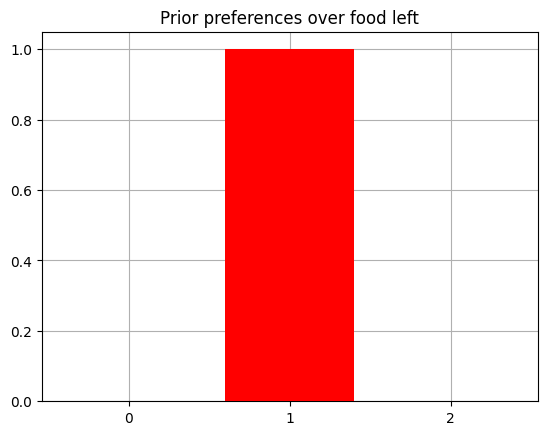

In [ ]:
utils.plot_beliefs(softmax(C3[0]), title = "Prior preferences over food left")


We set a new agent

In [ ]:
C3

array([array([ 0., 20.,  0.]), array([ 0., 10., 20.])], dtype=object)

In [ ]:
# we set policy_len = 3 because in order to plan the agent need to look further than just 1 ts
my_agent4 = Agent(A=A2, B=B2, C=C3, pB=pB, B_factor_list=B2_factor_list, policy_len = 3, policies=None, action_selection="stochastic")

In [ ]:
my_agent4.policies = restricted_policies

In [ ]:
# to adjust matrix size after having reduced policies

my_agent4.E = my_agent4._construct_E_prior()

In [ ]:
my_agent4.policies # we expect 8 policies 2^3

[array([[0, 0],
        [0, 0],
        [0, 0]]),
 array([[0, 0],
        [0, 0],
        [1, 1]]),
 array([[0, 0],
        [1, 1],
        [0, 0]]),
 array([[0, 0],
        [1, 1],
        [1, 1]]),
 array([[1, 1],
        [0, 0],
        [0, 0]]),
 array([[1, 1],
        [0, 0],
        [1, 1]]),
 array([[1, 1],
        [1, 1],
        [0, 0]]),
 array([[1, 1],
        [1, 1],
        [1, 1]])]

In [ ]:
len(my_agent4.policies)

8

We change the agent in the AIF loop.

In [ ]:
#more ts

In [ ]:
num_runs = 3

# length of active inference loop in time
T = 10

# initialize lists to store results
actions_list = []
observations_list = []
survival_time_no_learning=[]

my_agent4.reset()

for run in range(num_runs):
    env = room_Env2()
    current_state = env.reset() # initialize or reset the env


    actions = []
    observations = []
    satiety_zero_count = 0 # if satiety is 0 for more than 2 ts the agent dies

    for t in range(T):
        # get current observation from the environment
        if t == 0:
            observation = [np.array([current_state[0]]), np.array([current_state[1]])]
              # pk
            qs_prev = my_agent4.infer_states(observation)
        else:
            obs = env.step(action)
            observation = [np.array([obs[0]]), np.array([obs[1]])]

        print(f"Observation: {observation}")
        print()

        # update the agent's belief about the current state based on the observation
        qs = my_agent4.infer_states(observation)  # Update state beliefs

        # infer policies based on the updated beliefs
        my_agent4.infer_policies()

        # sample the next action from the inferred policies
        action = my_agent4.sample_action()

        # handle action based on its type and structure
        if isinstance(action, np.ndarray) and action.size == 1:
            action = int(action.item())  # Convert single-item array to integer
        elif isinstance(action, np.ndarray) and action.ndim > 0:
            action = int(action[0])  # Select the first action if multiple are given
        else:
            print("Unexpected action format. Terminating loop.")
            break

          # Check for satiety level and update the count
        if observation[1] == 0:
            satiety_zero_count += 1
        else:
            satiety_zero_count = 0

          # Terminate loop if satiety = 0 for 1 time step
        if satiety_zero_count >= 1:
            print(f"AGENT DIED OF STARVATION IN RUN {run + 1}.")
            print()
            survival_time_no_learning.append(t)
            break

        # store results for this timestep
        actions.append(action)
        observations.append(observation)
        previous_observation = observation


        # print results for this timestep
        print(f"Run {run + 1}")
        print(f"Time step {t}, Action taken: {action}")


    # Store results for this run
    actions_list.append(actions)
    observations_list.append(observations)
    if t==T-1:
      survival_time_no_learning.append(t)
      print(f"AGENT SURVIVED IN RUN {run + 1}.")

Observation: [array([2]), array([1])]

Run 1
Time step 0, Action taken: 1
Observation: [array([1]), array([2])]

Run 1
Time step 1, Action taken: 0
Observation: [array([2]), array([1])]

Run 1
Time step 2, Action taken: 1
Observation: [array([1]), array([2])]

Run 1
Time step 3, Action taken: 0
Observation: [array([2]), array([1])]

Run 1
Time step 4, Action taken: 1
Observation: [array([1]), array([2])]

Run 1
Time step 5, Action taken: 0
Observation: [array([2]), array([1])]

Run 1
Time step 6, Action taken: 1
Observation: [array([1]), array([2])]

Run 1
Time step 7, Action taken: 0
Observation: [array([2]), array([1])]

Run 1
Time step 8, Action taken: 1
Observation: [array([1]), array([2])]

Run 1
Time step 9, Action taken: 0
AGENT SURVIVED IN RUN 1.
Observation: [array([2]), array([1])]

Run 2
Time step 0, Action taken: 1
Observation: [array([1]), array([2])]

Run 2
Time step 1, Action taken: 0
Observation: [array([2]), array([1])]

Run 2
Time step 2, Action taken: 1
Observation: 

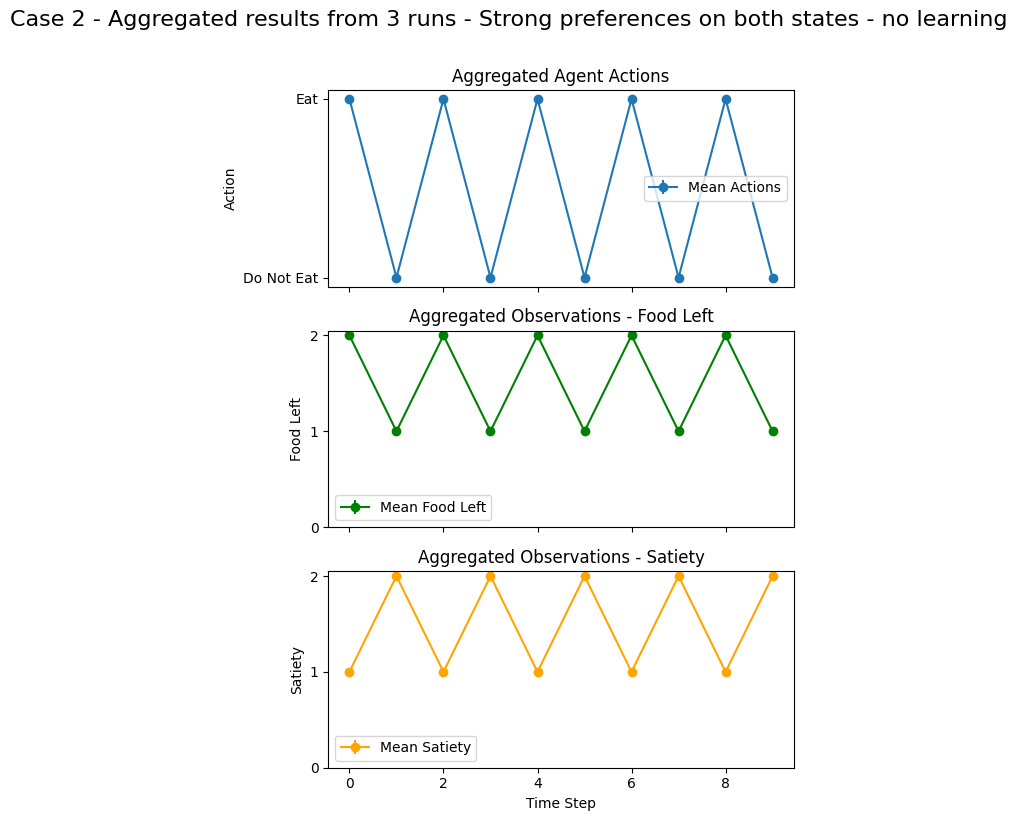

In [ ]:
# Number of runs
num_runs = len(observations_list)
T = len(observations_list[0])

# Initialize arrays to store aggregated data
actions_array = np.zeros((num_runs, T))
food_left_array = np.zeros((num_runs, T))
satiety_array = np.zeros((num_runs, T))

# Populate arrays with data from observations_list
for run in range(num_runs):
    actions_array[run, :] = actions_list[run]
    food_left_array[run, :] = [obs[0][0] for obs in observations_list[run]]
    satiety_array[run, :] = [obs[1][0] for obs in observations_list[run]]

# Calculate mean and standard deviation
mean_actions = np.mean(actions_array, axis=0)
std_actions = np.std(actions_array, axis=0)

mean_food_left = np.mean(food_left_array, axis=0)
std_food_left = np.std(food_left_array, axis=0)

mean_satiety = np.mean(satiety_array, axis=0)
std_satiety = np.std(satiety_array, axis=0)

# Plot the aggregated results
time_steps = range(T)

fig, axs = plt.subplots(3, 1, figsize=(6, 8), sharex=True)

# Plotting aggregated actions
axs[0].errorbar(time_steps, mean_actions, yerr=std_actions, fmt='-o', label='Mean Actions')
axs[0].set_ylabel("Action")
axs[0].set_title("Aggregated Agent Actions")
axs[0].set_yticks([0, 1])
axs[0].set_yticklabels(["Do Not Eat", "Eat"])
axs[0].legend()

# Plotting aggregated observations - food left
axs[1].errorbar(time_steps, mean_food_left, yerr=std_food_left, fmt='-o', color='green', label='Mean Food Left')
axs[1].set_ylabel("Food Left")
axs[1].set_title("Aggregated Observations - Food Left")
axs[1].set_yticks([0, 1, 2])
axs[1].legend()

# Plotting aggregated observations - satiety
axs[2].errorbar(time_steps, mean_satiety, yerr=std_satiety, fmt='-o', color='orange', label='Mean Satiety')
axs[2].set_ylabel("Satiety")
axs[2].set_title("Aggregated Observations - Satiety")
axs[2].set_yticks([0, 1, 2])
axs[2].legend()

plt.xlabel("Time Step")
plt.tight_layout()

fig.suptitle("Case 2 - Aggregated results from 3 runs - Strong preferences on both states - no learning", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.92)

plt.show()

By setting strong preferences on food left the agent keeps maintaining itself alive never getting to satiety = 0. (This is a bit trivial, not very useful as a proof of robustness)

#### Strong preferences on both states and **learning**

#### Weak preference on survival and **learning**

In 2.3 we saw that the B matrices arent learned perfectly even after a lot of runs.  this is because there will state/action situations it never encounters  (or maybe just once) and therefore it never learns. Once you have learned enough about the world in order to survive, and you have a strong preference to survive (which our C matrix has), then you aren't going to go and try something else when you have a perfectly good way of behaving. So it will reinforce learning for those situations. Once the agent has learned what it needs to learn in order to survive, then that is the way it will behave.

Now we investigate what happens if the C matrix showed a much weaker drive to survive than the C matrix of [0,10,20] which we have. eg[0,1,1] then it would lead to more likely death but also, over a time, a broader knowledge of how the world works.

In [ ]:
# create prior preferences over observations
C4 = utils.obj_array_zeros([num_obs2])
C4

array([array([[0., 0., 0.],
              [0., 0., 0.],
              [0., 0., 0.]])], dtype=object)

In [ ]:
# Define preferences for each observation modality
C_satiety4 = np.array([0.0, 1.0, 1.0])  # weak preference on satiety

# create an object array to hold each modality's preferences
C4 = np.empty(2, dtype=object)
C4[0] = C_food_left2 # they are the same as our main case 2.1
C4[1] = C_satiety4

In [ ]:
C4

array([array([5., 5., 5.]), array([0., 1., 1.])], dtype=object)

In [ ]:
len(C4)

2

In [ ]:
print("C vector:", C4)
for i, pref in enumerate(C4):
    print(f"Preferences for observation modality {i}: {pref}") #modality 0: food_left, 1: satiety

C vector: [array([5., 5., 5.]) array([0., 1., 1.])]
Preferences for observation modality 0: [5. 5. 5.]
Preferences for observation modality 1: [0. 1. 1.]


In [ ]:
softmax(C4[1])

array([0.1553624, 0.4223188, 0.4223188])

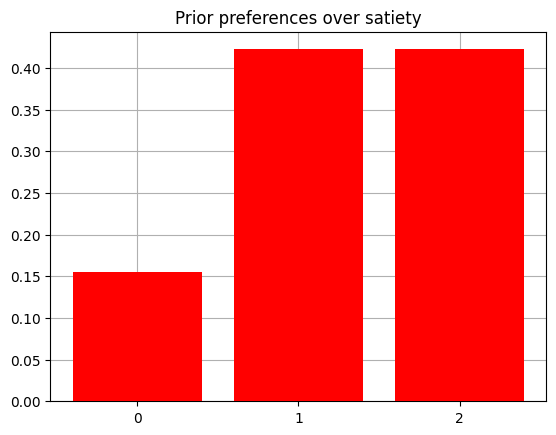

In [ ]:
utils.plot_beliefs(softmax(C4[1]), title = "Prior preferences over satiety")


We set a new agent

In [ ]:
# we set policy_len = 3 because in order to plan the agent need to look further than just 1 ts
my_agent5 = Agent(A=A2, B=B2, C=C4, pB=pB, B_factor_list=B2_factor_list, policy_len = 3, policies=None, action_selection="stochastic")

In [ ]:
B2[0].shape

(3, 3, 2)

In [ ]:
B2[1].shape

(3, 3, 3, 2)

In [ ]:
my_agent5.policies = restricted_policies

In [ ]:
# to adjust matrix size after having reduced policies

my_agent5.E = my_agent5._construct_E_prior()

In [ ]:
my_agent5.policies # we expect 8 policies 2^3

[array([[0, 0],
        [0, 0],
        [0, 0]]),
 array([[0, 0],
        [0, 0],
        [1, 1]]),
 array([[0, 0],
        [1, 1],
        [0, 0]]),
 array([[0, 0],
        [1, 1],
        [1, 1]]),
 array([[1, 1],
        [0, 0],
        [0, 0]]),
 array([[1, 1],
        [0, 0],
        [1, 1]]),
 array([[1, 1],
        [1, 1],
        [0, 0]]),
 array([[1, 1],
        [1, 1],
        [1, 1]])]

In [ ]:
len(my_agent5.policies)

8

We change the agent in the AIF loop.

In [ ]:
# Number of runs and time steps
num_runs = 20
T = 10

actions_list = []
observations_list = []
survival_time_with_learning=[] # in addition with respect to 2.2 AIF loop

my_agent5.reset() #we reset the agent outside the loop


for run in range(num_runs):

    actions = []
    observations = []
    env = room_Env2()
    current_state = env.reset()


    satiety_zero_count = 0

    for t in range(T):
        if t == 0:
            observation = [np.array([current_state[0]]), np.array([current_state[1]])]
            # pk in addition to 2.2 AIF loop
            qs_prev = my_agent5.infer_states(observation)
        else:
            obs = env.step(action)
            observation = [np.array([obs[0]]), np.array([obs[1]])]

            # print(f"Observation: {observation}")
            # print()

        # Update the agent's belief about the current state based on the observation
        qs = my_agent5.infer_states(observation)

        # Infer policies based on the updated beliefs
        my_agent5.infer_policies()

        if t>0:
          qB=my_agent5.update_B(qs_prev)
          qs_prev=qs


        # Sample the next action from the inferred policies
        action = my_agent5.sample_action()

        if isinstance(action, np.ndarray) and action.size == 1:
            action = int(action.item())
        elif isinstance(action, np.ndarray) and action.ndim > 0:
            action = int(action[0])
        else:
            print("Unexpected action format. Terminating loop.")
            break



        if observation[1] == 0:
            satiety_zero_count += 1
        else:
            satiety_zero_count = 0

        if satiety_zero_count >= 1: # like before, agent dies if satiety = 0 last more than 1 ts
            print(f"AGENT DIED OF STARVATION IN RUN {run + 1}.")
            survival_time_no_learning.append(t)
            break


         # store results for this timestep
        actions.append(action)
        observations.append(observation)

        # # print results for this timestep
        # print(f"Run {run + 1}")
        # print(f"Time step {t}, Action taken: {action}")

        actions.append(action)
        observations.append(observation)
        previous_observation = observation

    # store results for this run
    actions_list.append(actions)
    observations_list.append(observations)
    if t==T-1:
      survival_time_with_learning.append(t)
      print(f"AGENT SURVIVED IN RUN {run + 1}.")

AGENT DIED OF STARVATION IN RUN 1.
AGENT DIED OF STARVATION IN RUN 2.
AGENT DIED OF STARVATION IN RUN 3.
AGENT DIED OF STARVATION IN RUN 4.
AGENT DIED OF STARVATION IN RUN 5.
AGENT DIED OF STARVATION IN RUN 6.
AGENT DIED OF STARVATION IN RUN 7.
AGENT DIED OF STARVATION IN RUN 8.
AGENT DIED OF STARVATION IN RUN 9.
AGENT DIED OF STARVATION IN RUN 10.
AGENT DIED OF STARVATION IN RUN 11.
AGENT DIED OF STARVATION IN RUN 12.
AGENT DIED OF STARVATION IN RUN 13.
AGENT DIED OF STARVATION IN RUN 14.
AGENT DIED OF STARVATION IN RUN 15.
AGENT DIED OF STARVATION IN RUN 16.
AGENT DIED OF STARVATION IN RUN 17.
AGENT DIED OF STARVATION IN RUN 18.
AGENT DIED OF STARVATION IN RUN 19.
AGENT DIED OF STARVATION IN RUN 20.


As expected, the agent dies. But maybe we should see more learning on the B matrix. Something wrong with B[1] dimensions, need to check the plot

num total steps 200
Food left, action do not eat


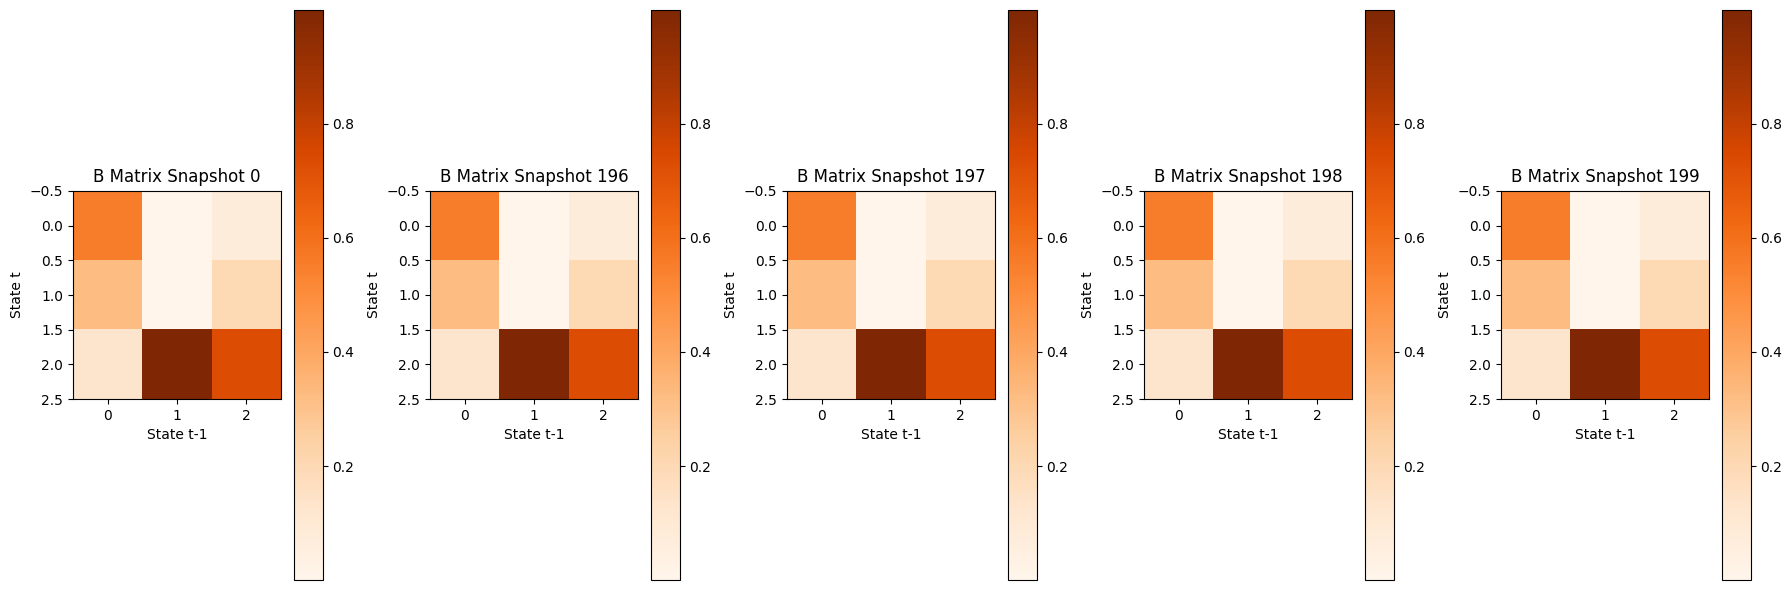

In [ ]:
# Plot snapshots of the updated B matrix for one of the factors as an example
num_snapshots = min(len(B_snapshots0_action0), 5)  # Limit to 5 snapshots for clarity
print("num total steps",len(B_snapshots0_action0))

print("Food left, action do not eat")
plt.figure(figsize=(18, 6))
plt.subplot(1, num_snapshots, 1)
plt.imshow(B_snapshots0_action0[0], cmap='Oranges', interpolation='nearest')
plt.colorbar()
plt.title(f'B Matrix Snapshot {0}')
plt.xlabel('State t-1')
plt.ylabel('State t')
for i in range(1,num_snapshots):
    plt.subplot(1, num_snapshots, i + 1)
    plt.imshow(B_snapshots0_action0[i+len(B_snapshots0_action0)- 5], cmap='Oranges', interpolation='nearest')
    plt.colorbar()
    plt.title(f'B Matrix Snapshot {i+len(B_snapshots0_action0)- 5}')
    plt.xlabel('State t-1')
    plt.ylabel('State t')
plt.tight_layout()
plt.show()

Food left, action 'eat'


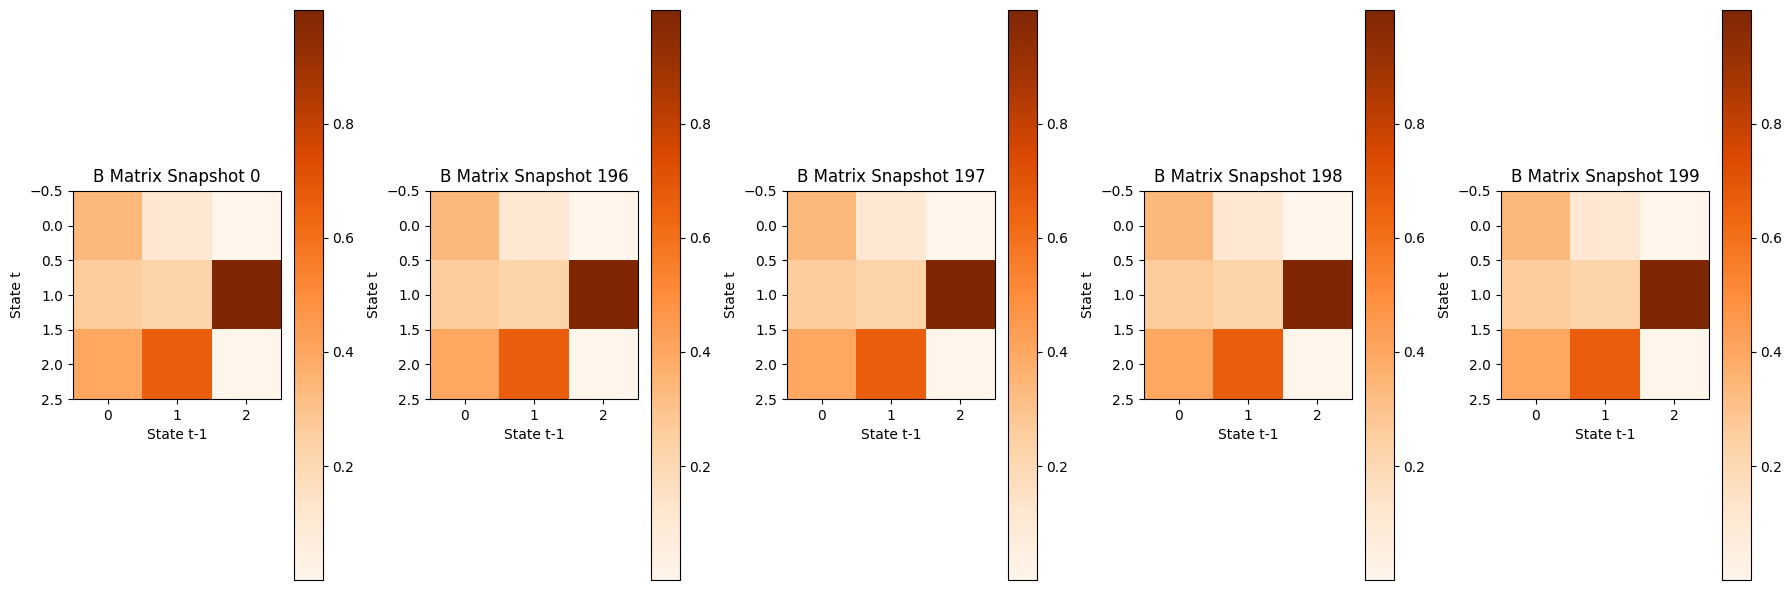

In [ ]:
print("Food left, action 'eat'")
plt.figure(figsize=(18, 6))
plt.subplot(1, num_snapshots, 1)
plt.imshow(B_snapshots0_action1[0], cmap='Oranges', interpolation='nearest')
plt.colorbar()
plt.title(f'B Matrix Snapshot {0}')
plt.xlabel('State t-1')
plt.ylabel('State t')
for i in range(1,num_snapshots):
    plt.subplot(1, num_snapshots, i + 1)
    plt.imshow(B_snapshots0_action1[i+len(B_snapshots0_action0)- 5], cmap='Oranges', interpolation='nearest')
    plt.colorbar()
    plt.title(f'B Matrix Snapshot {i+len(B_snapshots0_action0)- 5}')
    plt.xlabel('State t-1')
    plt.ylabel('State t')
plt.tight_layout()
plt.show()


Satiety, action 'do not eat', food_left=0


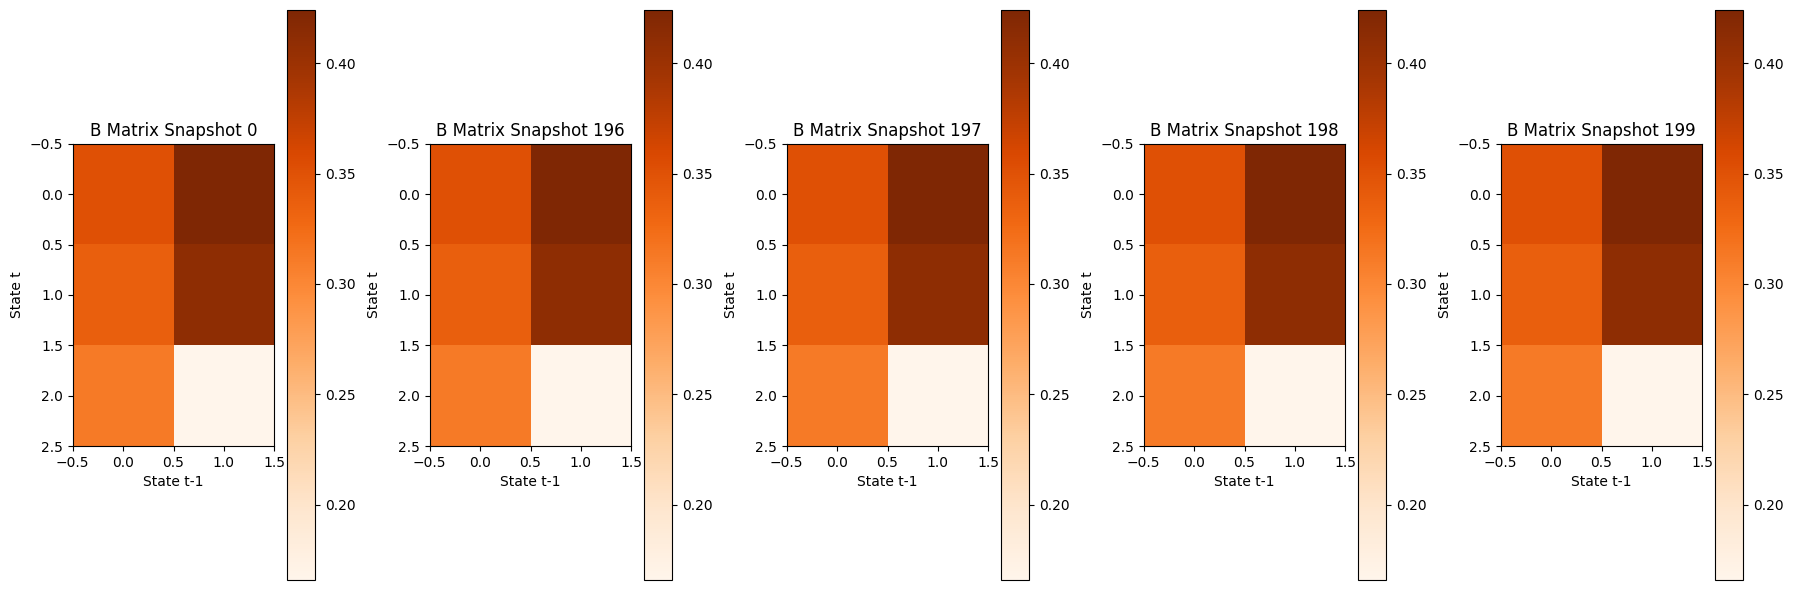

In [ ]:
print("Satiety, action 'do not eat', food_left=0")
plt.figure(figsize=(18, 6))
plt.subplot(1, num_snapshots, 1)
plt.imshow(B_snapshots1_action0[0][:,0,:], cmap='Oranges', interpolation='nearest')
plt.colorbar()
plt.title(f'B Matrix Snapshot {0}')
plt.xlabel('State t-1')
plt.ylabel('State t')
for i in range(1,num_snapshots):
    plt.subplot(1, num_snapshots, i + 1)
    plt.imshow(B_snapshots1_action0[i+len(B_snapshots0_action0)- 5][:,0,:], cmap='Oranges', interpolation='nearest')
    plt.colorbar()
    plt.title(f'B Matrix Snapshot {i+len(B_snapshots0_action0)- 5}')
    plt.xlabel('State t-1')
    plt.ylabel('State t')
plt.tight_layout()
plt.show()

Satiety, action 'do not eat', food_left=1


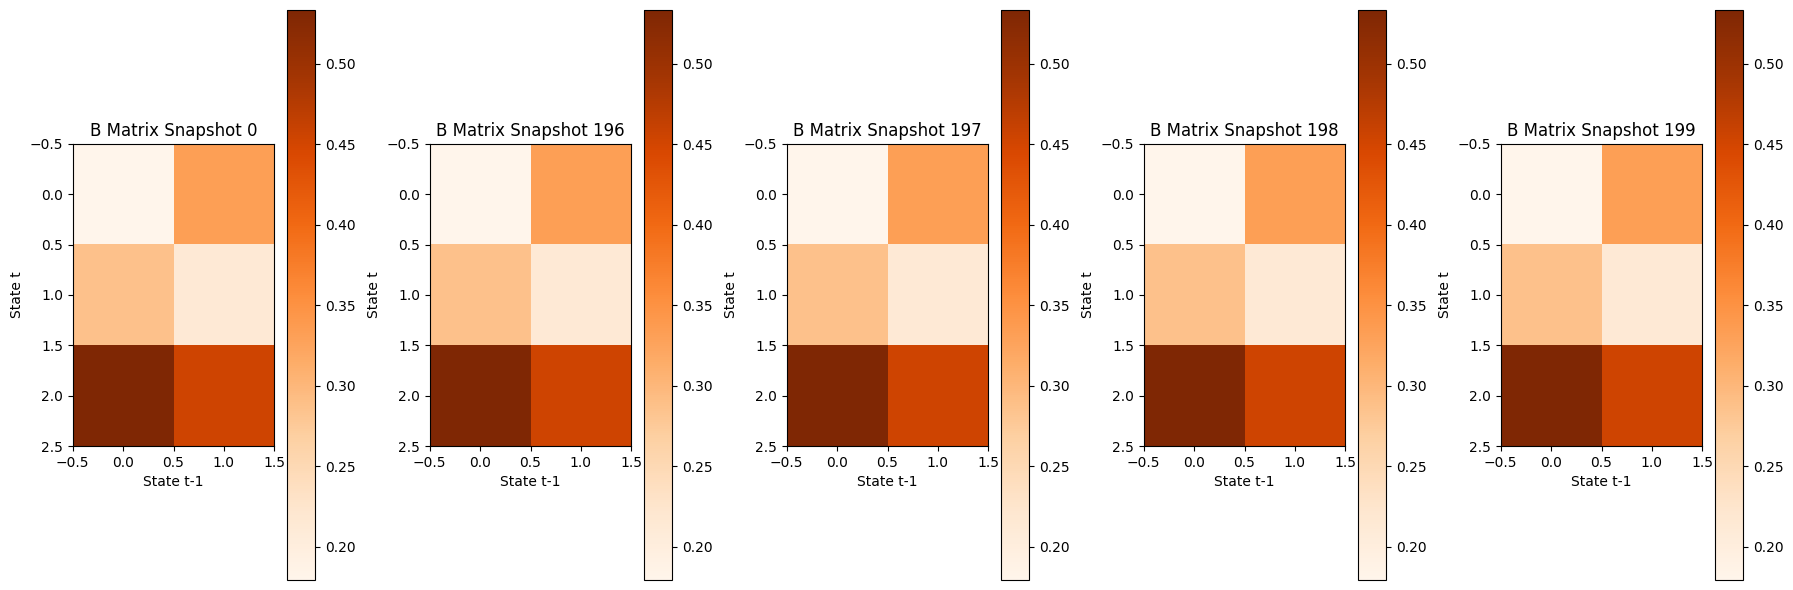

In [ ]:
print("Satiety, action 'do not eat', food_left=1")
plt.figure(figsize=(18, 6))
plt.subplot(1, num_snapshots, 1)
plt.imshow(B_snapshots1_action0[0][:,1,:], cmap='Oranges', interpolation='nearest')
plt.colorbar()
plt.title(f'B Matrix Snapshot {0}')
plt.xlabel('State t-1')
plt.ylabel('State t')
for i in range(1,num_snapshots):
    plt.subplot(1, num_snapshots, i + 1)
    plt.imshow(B_snapshots1_action0[i+len(B_snapshots0_action0)- 5][:,1,:], cmap='Oranges', interpolation='nearest')
    plt.colorbar()
    plt.title(f'B Matrix Snapshot {i+len(B_snapshots0_action0)- 5}')
    plt.xlabel('State t-1')
    plt.ylabel('State t')
plt.tight_layout()
plt.show()

Satiety, action 'do not eat', food_left=2


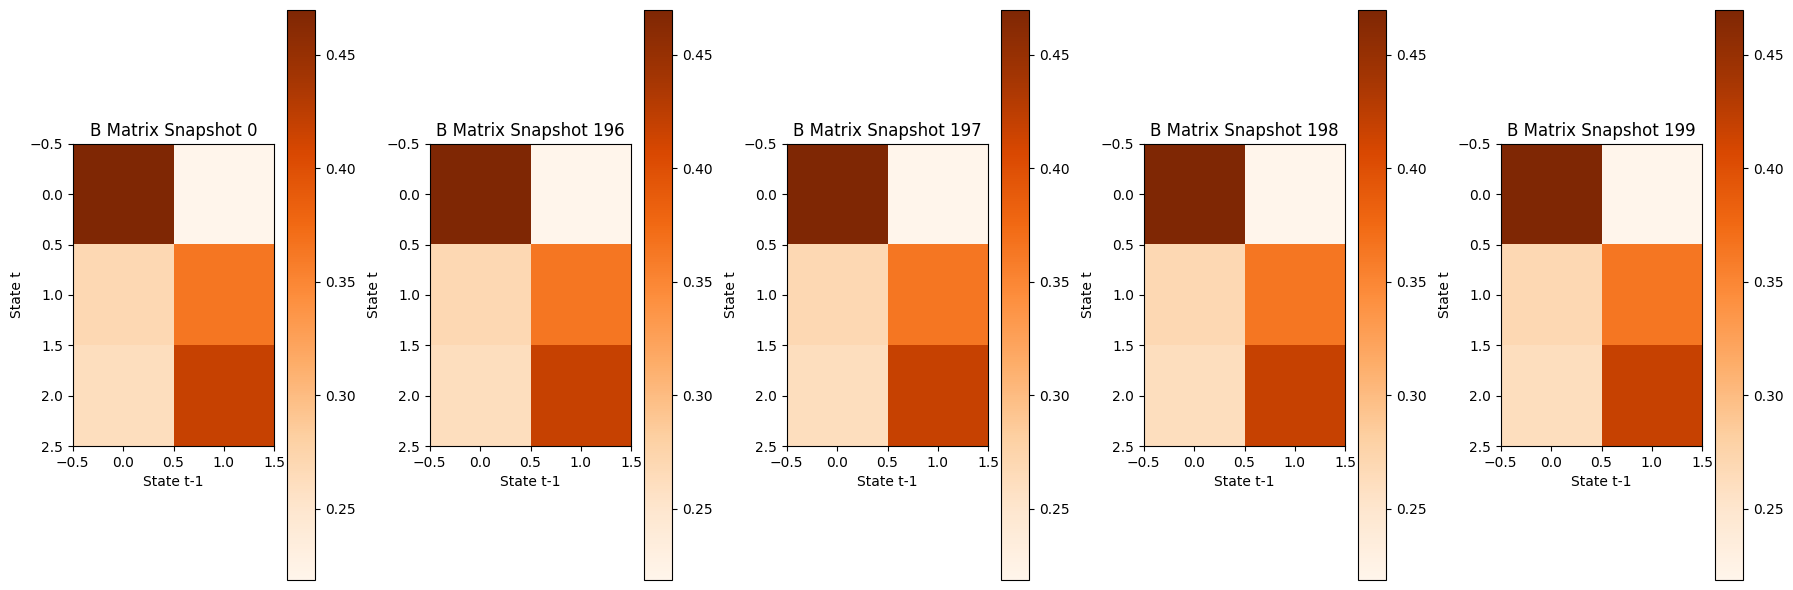

In [ ]:
print("Satiety, action 'do not eat', food_left=2")
plt.figure(figsize=(18, 6))
plt.subplot(1, num_snapshots, 1)
plt.imshow(B_snapshots1_action0[0][:,2,:], cmap='Oranges', interpolation='nearest')
plt.colorbar()
plt.title(f'B Matrix Snapshot {0}')
plt.xlabel('State t-1')
plt.ylabel('State t')
for i in range(1,num_snapshots):
    plt.subplot(1, num_snapshots, i + 1)
    plt.imshow(B_snapshots1_action0[i+len(B_snapshots0_action0)- 5][:,2,:], cmap='Oranges', interpolation='nearest')
    plt.colorbar()
    plt.title(f'B Matrix Snapshot {i+len(B_snapshots0_action0)- 5}')
    plt.xlabel('State t-1')
    plt.ylabel('State t')
plt.tight_layout()
plt.show()

Satiety, action 'eat', food_left=0


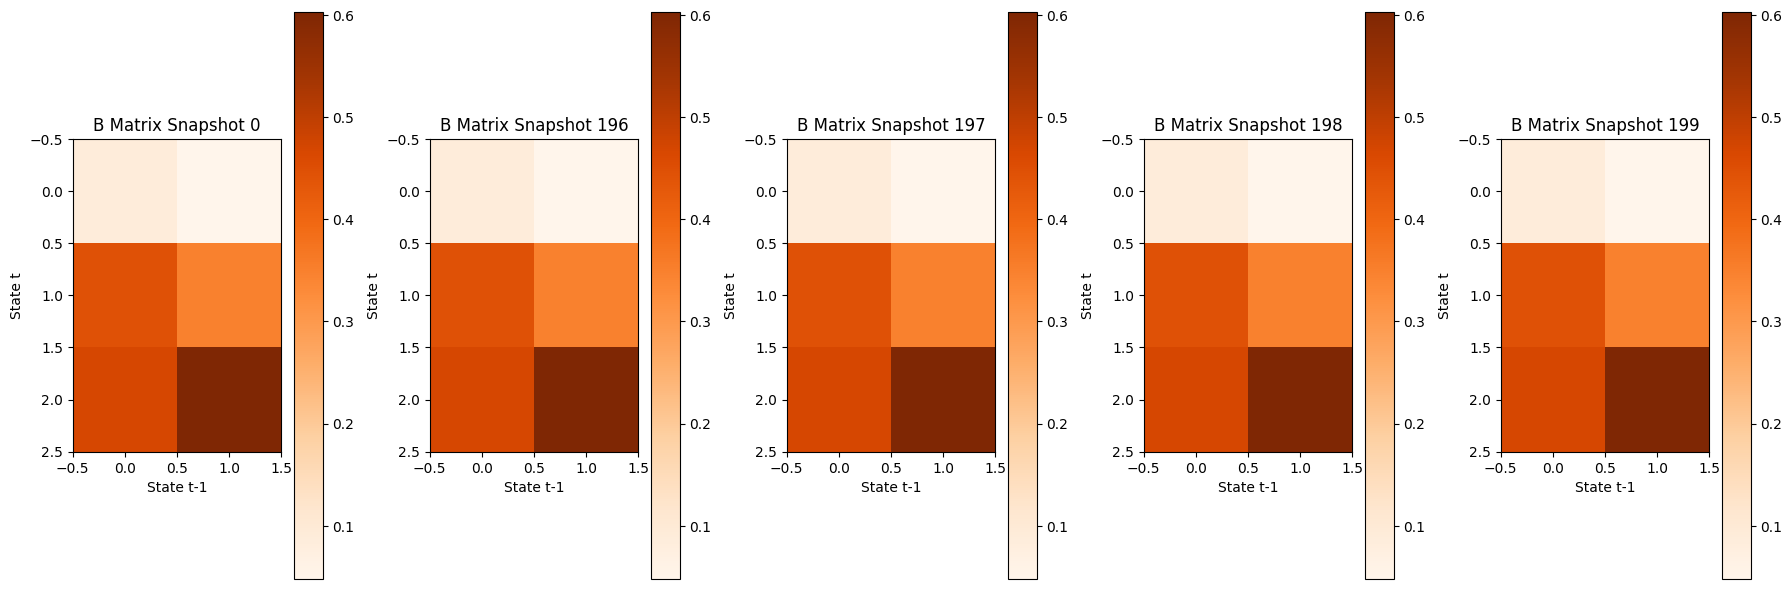

In [ ]:
print("Satiety, action 'eat', food_left=0")
plt.figure(figsize=(18, 6))
plt.subplot(1, num_snapshots, 1)
plt.imshow(B_snapshots1_action1[0][:,0,:], cmap='Oranges', interpolation='nearest')
plt.colorbar()
plt.title(f'B Matrix Snapshot {0}')
plt.xlabel('State t-1')
plt.ylabel('State t')
for i in range(1,num_snapshots):
    plt.subplot(1, num_snapshots, i + 1)
    plt.imshow(B_snapshots1_action1[i+len(B_snapshots0_action0)- 5][:,0,:], cmap='Oranges', interpolation='nearest')
    plt.colorbar()
    plt.title(f'B Matrix Snapshot {i+len(B_snapshots0_action0)- 5}')
    plt.xlabel('State t-1')
    plt.ylabel('State t')
plt.tight_layout()
plt.show()

Satiety, action 'eat', food_left=1


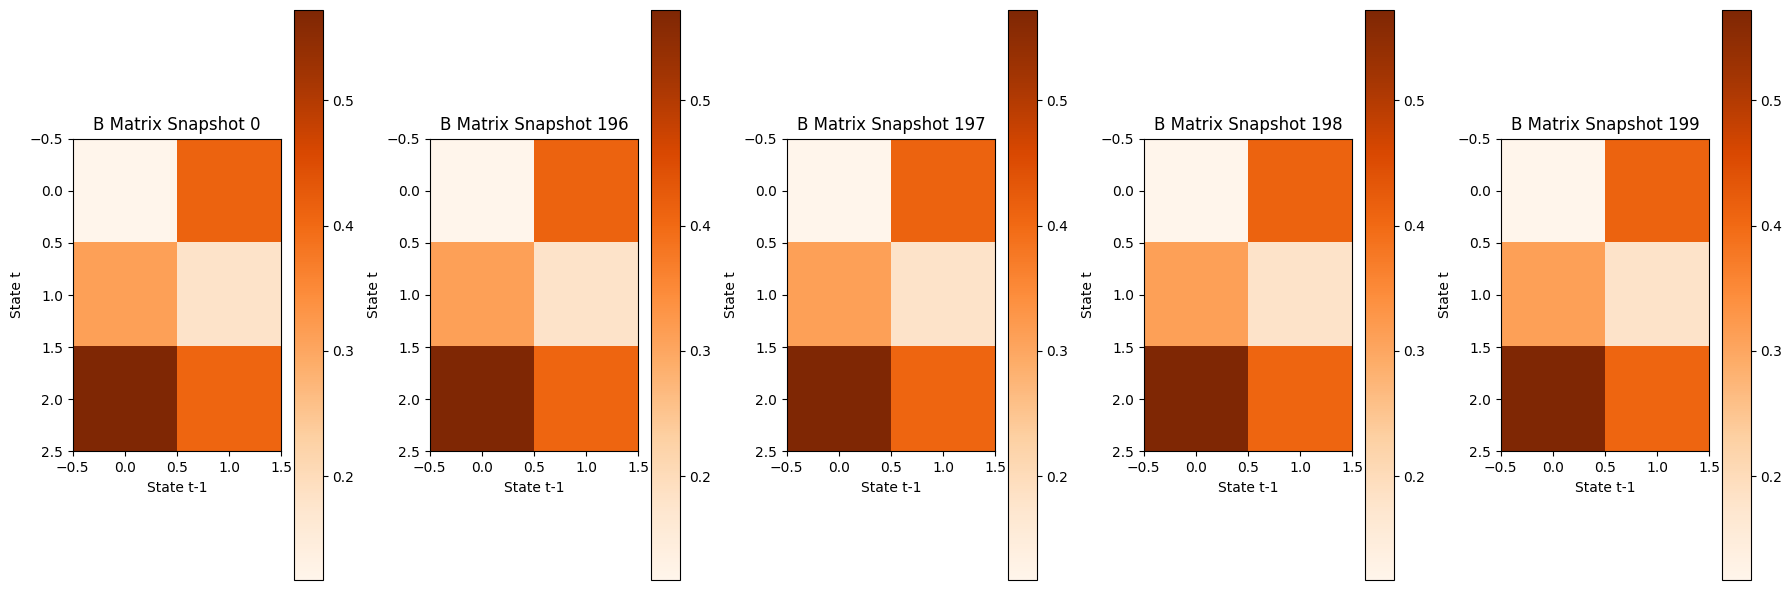

In [ ]:
print("Satiety, action 'eat', food_left=1")
plt.figure(figsize=(18, 6))
plt.subplot(1, num_snapshots, 1)
plt.imshow(B_snapshots1_action1[0][:,1,:], cmap='Oranges', interpolation='nearest')
plt.colorbar()
plt.title(f'B Matrix Snapshot {0}')
plt.xlabel('State t-1')
plt.ylabel('State t')
for i in range(1,num_snapshots):
    plt.subplot(1, num_snapshots, i + 1)
    plt.imshow(B_snapshots1_action1[i+len(B_snapshots0_action0)- 5][:,1,:], cmap='Oranges', interpolation='nearest')
    plt.colorbar()
    plt.title(f'B Matrix Snapshot {i+len(B_snapshots0_action0)- 5}')
    plt.xlabel('State t-1')
    plt.ylabel('State t')
plt.tight_layout()
plt.show()

Satiety, action 'eat', food_left=2


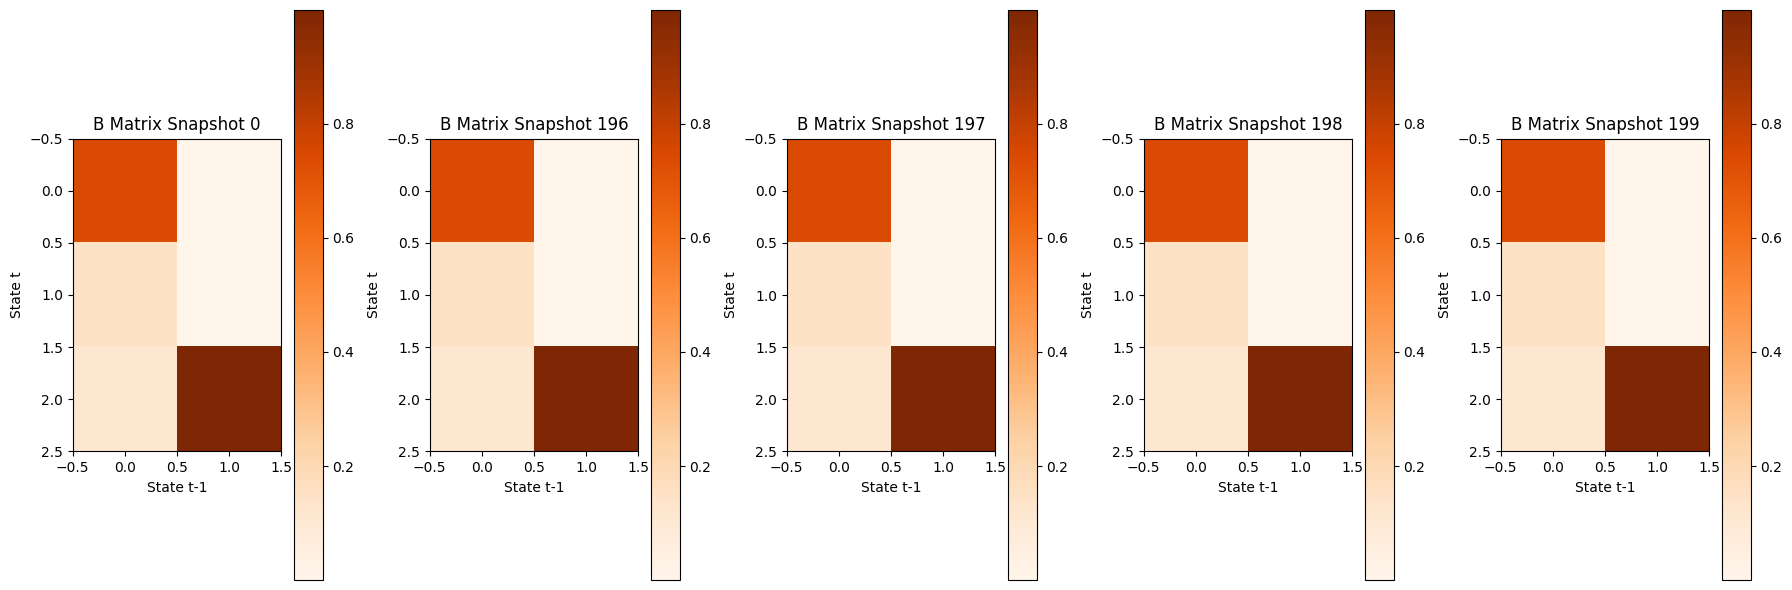

In [ ]:
print("Satiety, action 'eat', food_left=2")
plt.figure(figsize=(18, 6))
plt.subplot(1, num_snapshots, 1)
plt.imshow(B_snapshots1_action1[0][:,2,:], cmap='Oranges', interpolation='nearest')
plt.colorbar()
plt.title(f'B Matrix Snapshot {0}')
plt.xlabel('State t-1')
plt.ylabel('State t')
for i in range(1,num_snapshots):
    plt.subplot(1, num_snapshots, i + 1)
    plt.imshow(B_snapshots1_action1[i+len(B_snapshots0_action0)- 5][:,2,:], cmap='Oranges', interpolation='nearest')
    plt.colorbar()
    plt.title(f'B Matrix Snapshot {i+len(B_snapshots0_action0)- 5}')
    plt.xlabel('State t-1')
    plt.ylabel('State t')
plt.tight_layout()
plt.show()

#### Weak preference on survival and **learning**

### *2.4.3 Different environment*
We change the environment so that food and satiety levels change at different rates

In [ ]:
class room_Env3:
    def __init__(self):
        # Initial states
        self.state_food2 = 2  # food = 2 (full)
        self.state_satiety2 = 1  # satiety = 1 (half satisfied)

    def step(self, action):
        """
        Updates the environment state based on the agent's action and returns the observation.

        :param action: int, the action taken by the agent, 0 for 'do not eat', 1 for 'eat'
        :return: tuple, (observation_food, observation_satiety)
        """
        if action == 0:  # do not eat
            # Food increases at a slower rate if the agent does not eat
            self.state_food2 = min(self.state_food2 + 0.5, 2)  # food level can grow up to 2
            self.state_satiety2 = max(self.state_satiety2 - 0.2, 0)  # satiety decreases faster

        elif action == 1:  # eat
            if self.state_food2 > 0:  # can only eat if food is present
                # Food decreases at a faster rate and satiety increases at a different rate
                self.state_food2 = max(self.state_food2 - 1, 0)
                self.state_satiety2 = min(self.state_satiety2 + 0.8, 2)
            else:
                # If there is no food, satiety decreases
                self.state_satiety2 = max(self.state_satiety2 - 0.3, 0)

        # Mapping states to observations
        obs_food2 = int(round(self.state_food2))  # directly use the state as observation, converted to int to be sure it works in the loop
        obs_satiety2 = int(round(self.state_satiety2))

        return [obs_food2, obs_satiety2]

    def reset(self):
        # Reset the environment to the initial state
        self.state_food2 = 2  # Food full present
        self.state_satiety2 = 1  # Half satisfied

        return [self.state_food2, self.state_satiety2]

#### No Learning

In [ ]:
# Number of runs and time steps
num_runs = 20
T = 10

actions_list = []
observations_list = []
B_snapshots0_action0 = []
B_snapshots0_action1 = []
B_snapshots1_action0 = []
B_snapshots1_action1 = []
survival_time_no_learning=[]

my_new_agent2.reset()




for run in range(num_runs):

    actions = []
    observations = []
    env = room_Env3()
    current_state = env.reset()


    satiety_zero_count = 0

    for t in range(T):
        if t == 0:
            observation = [np.array([current_state[0]]), np.array([current_state[1]])]
            # pk
            qs_prev = my_new_agent2.infer_states(observation)
        else:
            obs = env.step(action)
            observation = [np.array([obs[0]]), np.array([obs[1]])]

        # Store snapshot of B matrix for the first factor and first action
        B_snapshots0_action0.append(my_new_agent2.B[0][:, :, 0].copy()) #if we store action 0 the matrices are all the same,
                                                                #because action 1 is the one on which B matrix is updated
        B_snapshots0_action1.append(my_new_agent2.B[0][:, :, 1].copy())

        B_snapshots1_action0.append(my_new_agent2.B[1][:, :,:, 0].copy())
        B_snapshots1_action1.append(my_new_agent2.B[1][:, :, :,1].copy())

        # Update the agent's belief about the current state based on the observation
        qs = my_new_agent2.infer_states(observation)

        # Infer policies based on the updated beliefs
        my_new_agent2.infer_policies()

        # Sample the next action from the inferred policies
        action = my_new_agent2.sample_action()

        if isinstance(action, np.ndarray) and action.size == 1:
            action = int(action.item())
        elif isinstance(action, np.ndarray) and action.ndim > 0:
            action = int(action[0])
        else:
            print("Unexpected action format. Terminating loop.")
            break



        if observation[1] == 0:
            satiety_zero_count += 1
        else:
            satiety_zero_count = 0

        if satiety_zero_count >= 1: # like before, agent dies if satiety = 0 last more than 1 ts
            print(f"AGENT DIED OF STARVATION IN RUN {run + 1}.")
            survival_time_with_learning.append(t)
            break


         # store results for this timestep
        actions.append(action)
        observations.append(observation)

        actions.append(action)
        observations.append(observation)
        previous_observation = observation

    # store results for this run
    actions_list.append(actions)
    observations_list.append(observations)
    if t==T-1:
      survival_time_no_learning.append(t)
      print(f"AGENT SURVIVED IN RUN {run + 1}.")

AGENT DIED OF STARVATION IN RUN 1.
AGENT SURVIVED IN RUN 1.
AGENT DIED OF STARVATION IN RUN 2.
AGENT SURVIVED IN RUN 2.
AGENT DIED OF STARVATION IN RUN 3.
AGENT SURVIVED IN RUN 3.
AGENT DIED OF STARVATION IN RUN 4.
AGENT SURVIVED IN RUN 4.
AGENT DIED OF STARVATION IN RUN 5.
AGENT SURVIVED IN RUN 5.
AGENT DIED OF STARVATION IN RUN 6.
AGENT SURVIVED IN RUN 6.
AGENT DIED OF STARVATION IN RUN 7.
AGENT SURVIVED IN RUN 7.
AGENT DIED OF STARVATION IN RUN 8.
AGENT SURVIVED IN RUN 8.
AGENT DIED OF STARVATION IN RUN 9.
AGENT SURVIVED IN RUN 9.
AGENT DIED OF STARVATION IN RUN 10.
AGENT SURVIVED IN RUN 10.
AGENT DIED OF STARVATION IN RUN 11.
AGENT SURVIVED IN RUN 11.
AGENT DIED OF STARVATION IN RUN 12.
AGENT SURVIVED IN RUN 12.
AGENT DIED OF STARVATION IN RUN 13.
AGENT SURVIVED IN RUN 13.
AGENT DIED OF STARVATION IN RUN 14.
AGENT SURVIVED IN RUN 14.
AGENT DIED OF STARVATION IN RUN 15.
AGENT SURVIVED IN RUN 15.
AGENT DIED OF STARVATION IN RUN 16.
AGENT SURVIVED IN RUN 16.
AGENT DIED OF STARVATION I

#### Learning

In [ ]:
# Number of runs and time steps
num_runs = 20
T = 10

actions_list = []
observations_list = []
survival_time_with_learning=[] # in addition with respect to 2.2 AIF loop

my_new_agent2.reset() #we reset the agent outside the loop, different from 2.2 AIF loop


for run in range(num_runs):

    actions = []
    observations = []
    env = room_Env3()
    current_state = env.reset()


    satiety_zero_count = 0

    for t in range(T):
        if t == 0:
            observation = [np.array([current_state[0]]), np.array([current_state[1]])]
            # pk in addition to 2.2 AIF loop
            qs_prev = my_new_agent2.infer_states(observation)
        else:
            obs = env.step(action)
            observation = [np.array([obs[0]]), np.array([obs[1]])]

            # print(f"Observation: {observation}")
            # print()

        # Update the agent's belief about the current state based on the observation
        qs = my_new_agent2.infer_states(observation)

        # Infer policies based on the updated beliefs
        my_new_agent2.infer_policies()

        if t>0:
          qB=my_new_agent2.update_B(qs_prev)
          qs_prev=qs

        # Sample the next action from the inferred policies
        action = my_new_agent2.sample_action()

        if isinstance(action, np.ndarray) and action.size == 1:
            action = int(action.item())
        elif isinstance(action, np.ndarray) and action.ndim > 0:
            action = int(action[0])
        else:
            print("Unexpected action format. Terminating loop.")
            break



        if observation[1] == 0:
            satiety_zero_count += 1
        else:
            satiety_zero_count = 0

        if satiety_zero_count >= 1: # like before, agent dies if satiety = 0 last more than 1 ts
            print(f"AGENT DIED OF STARVATION IN RUN {run + 1}.")
            survival_time_no_learning.append(t)
            break


         # store results for this timestep
        actions.append(action)
        observations.append(observation)

        # # print results for this timestep
        # print(f"Run {run + 1}")
        # print(f"Time step {t}, Action taken: {action}")

        actions.append(action)
        observations.append(observation)
        previous_observation = observation

    # store results for this run
    actions_list.append(actions)
    observations_list.append(observations)
    if t==T-1:
      survival_time_no_learning.append(t)
      print(f"AGENT SURVIVED IN RUN {run + 1}.")

AGENT SURVIVED IN RUN 1.
AGENT SURVIVED IN RUN 2.
AGENT DIED OF STARVATION IN RUN 3.
AGENT DIED OF STARVATION IN RUN 4.
AGENT DIED OF STARVATION IN RUN 5.
AGENT DIED OF STARVATION IN RUN 6.
AGENT SURVIVED IN RUN 7.
AGENT SURVIVED IN RUN 8.
AGENT SURVIVED IN RUN 9.
AGENT SURVIVED IN RUN 10.
AGENT SURVIVED IN RUN 11.
AGENT SURVIVED IN RUN 12.
AGENT SURVIVED IN RUN 13.
AGENT SURVIVED IN RUN 14.
AGENT SURVIVED IN RUN 15.
AGENT SURVIVED IN RUN 16.
AGENT SURVIVED IN RUN 17.
AGENT SURVIVED IN RUN 18.
AGENT SURVIVED IN RUN 19.
AGENT SURVIVED IN RUN 20.


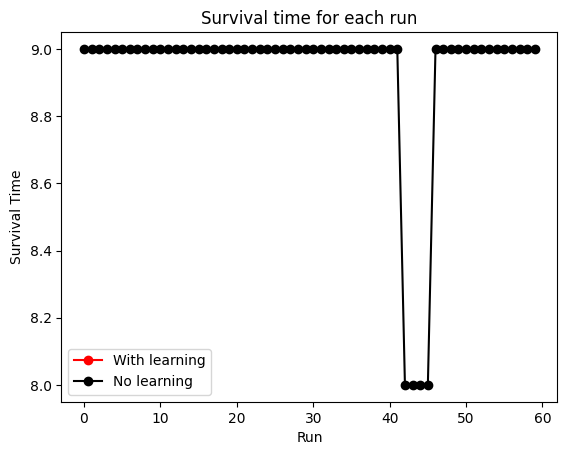

In [ ]:
plt.figure()
plt.plot(survival_time_with_learning,"ro-", label="With learning")
plt.plot(survival_time_no_learning,"ko-", label="No learning")
plt.title("Survival time for each run")
plt.xlabel("Run")
plt.ylabel("Survival Time")
plt.legend()
plt.show()

### *2.4.4 Different policy length* - in progress


When the agent has a policy length = 1, i.e. does not plan, it keeps itself alive as well, but the food goes to 0 more often than when it plans 3 ts ahead. Cfr agent with different policy length (3/1) and check how many of the agents dies.

#### No learning

In [ ]:
# we set policy_len = 1 so the agent does not actually plan
my_agent6 = Agent(A=A2, B=B2, C=C2, pB=pB, B_factor_list=B2_factor_list, policy_len = 1, policies=None, action_selection="stochastic")

In [ ]:
my_agent6.policy_len


1

In [ ]:
my_agent6.policies = restricted_policies

In [ ]:
# to adjust matrix size after having reduced policies

my_agent6.E = my_agent6._construct_E_prior()

In [ ]:
my_agent6.policies # we expect 8 policies 2^3

[array([[0, 0],
        [0, 0],
        [0, 0]]),
 array([[0, 0],
        [0, 0],
        [1, 1]]),
 array([[0, 0],
        [1, 1],
        [0, 0]]),
 array([[0, 0],
        [1, 1],
        [1, 1]]),
 array([[1, 1],
        [0, 0],
        [0, 0]]),
 array([[1, 1],
        [0, 0],
        [1, 1]]),
 array([[1, 1],
        [1, 1],
        [0, 0]]),
 array([[1, 1],
        [1, 1],
        [1, 1]])]

In [ ]:
len(my_agent6.policies)

8

**AIF loop**

In [ ]:
# Number of runs and time steps
num_runs = 20
T = 10

actions_list = []
observations_list = []
survival_time_no_learning=[] # in addition with respect to 2.2 AIF loop

my_agent6.reset() #we reset the agent outside the loop, different from 2.2 AIF loop


for run in range(num_runs):

    actions = []
    observations = []
    env = room_Env2()
    current_state = env.reset()


    satiety_zero_count = 0

    for t in range(T):
        if t == 0:
            observation = [np.array([current_state[0]]), np.array([current_state[1]])]
            # pk in addition to 2.2 AIF loop
            qs_prev = my_agent6.infer_states(observation)
        else:
            obs = env.step(action)
            observation = [np.array([obs[0]]), np.array([obs[1]])]

            # print(f"Observation: {observation}")
            # print()

        # Update the agent's belief about the current state based on the observation
        qs = my_agent6.infer_states(observation)

        # Infer policies based on the updated beliefs
        my_agent6.infer_policies()


        # Sample the next action from the inferred policies
        action = my_agent6.sample_action()

        if isinstance(action, np.ndarray) and action.size == 1:
            action = int(action.item())
        elif isinstance(action, np.ndarray) and action.ndim > 0:
            action = int(action[0])
        else:
            print("Unexpected action format. Terminating loop.")
            break



        if observation[1] == 0:
            satiety_zero_count += 1
        else:
            satiety_zero_count = 0

        if satiety_zero_count >= 1: # like before, agent dies if satiety = 0 last more than 1 ts
            print(f"AGENT DIED OF STARVATION IN RUN {run + 1}.")
            survival_time_no_learning.append(t)
            break


         # store results for this timestep
        actions.append(action)
        observations.append(observation)

        # # print results for this timestep
        # print(f"Run {run + 1}")
        # print(f"Time step {t}, Action taken: {action}")

        actions.append(action)
        observations.append(observation)
        previous_observation = observation

    # store results for this run
    actions_list.append(actions)
    observations_list.append(observations)
    if t==T-1:
      survival_time_no_learning.append(t)
      print(f"AGENT SURVIVED IN RUN {run + 1}.")

AGENT DIED OF STARVATION IN RUN 1.
AGENT DIED OF STARVATION IN RUN 2.
AGENT DIED OF STARVATION IN RUN 3.
AGENT DIED OF STARVATION IN RUN 4.
AGENT DIED OF STARVATION IN RUN 5.
AGENT DIED OF STARVATION IN RUN 6.
AGENT DIED OF STARVATION IN RUN 7.
AGENT DIED OF STARVATION IN RUN 8.
AGENT DIED OF STARVATION IN RUN 9.
AGENT DIED OF STARVATION IN RUN 10.
AGENT DIED OF STARVATION IN RUN 11.
AGENT DIED OF STARVATION IN RUN 12.
AGENT DIED OF STARVATION IN RUN 13.
AGENT DIED OF STARVATION IN RUN 14.
AGENT DIED OF STARVATION IN RUN 15.
AGENT DIED OF STARVATION IN RUN 16.
AGENT DIED OF STARVATION IN RUN 17.
AGENT DIED OF STARVATION IN RUN 18.
AGENT DIED OF STARVATION IN RUN 19.
AGENT DIED OF STARVATION IN RUN 20.


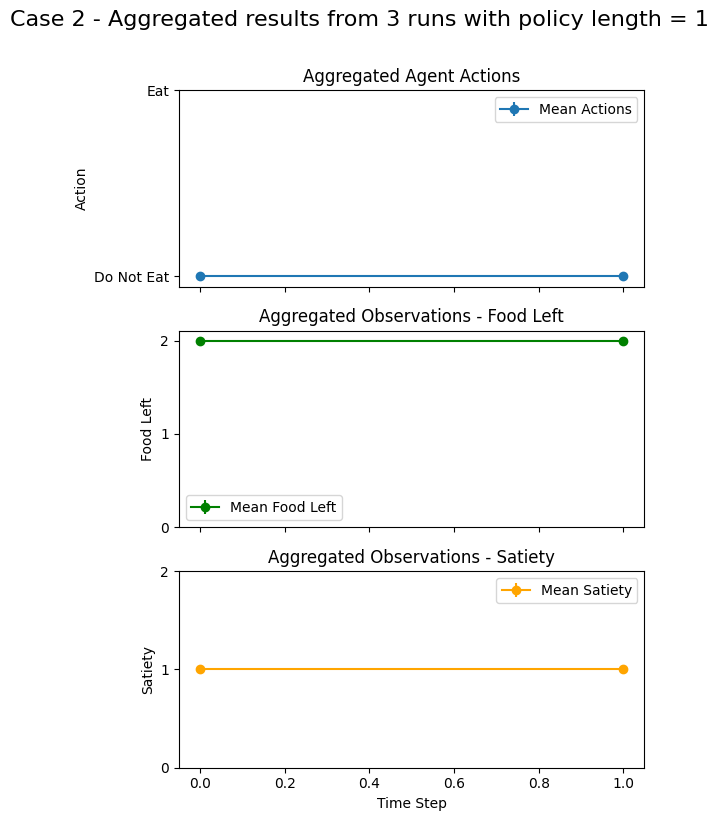

In [ ]:
#plot the aggregated results
# Number of runs
num_runs = len(observations_list)
T = len(observations_list[0])

# Initialize arrays to store aggregated data
actions_array = np.zeros((num_runs, T))
food_left_array = np.zeros((num_runs, T))
satiety_array = np.zeros((num_runs, T))

# Populate arrays with data from observations_list
for run in range(num_runs):
    actions_array[run, :] = actions_list[run]
    food_left_array[run, :] = [obs[0][0] for obs in observations_list[run]]
    satiety_array[run, :] = [obs[1][0] for obs in observations_list[run]]

# Calculate mean and standard deviation
mean_actions = np.mean(actions_array, axis=0)
std_actions = np.std(actions_array, axis=0)

mean_food_left = np.mean(food_left_array, axis=0)
std_food_left = np.std(food_left_array, axis=0)

mean_satiety = np.mean(satiety_array, axis=0)
std_satiety = np.std(satiety_array, axis=0)

# Plot
time_steps = range(T)

fig, axs = plt.subplots(3, 1, figsize=(6, 8), sharex=True)

# Plotting aggregated actions
axs[0].errorbar(time_steps, mean_actions, yerr=std_actions, fmt='-o', label='Mean Actions')
axs[0].set_ylabel("Action")
axs[0].set_title("Aggregated Agent Actions")
axs[0].set_yticks([0, 1])
axs[0].set_yticklabels(["Do Not Eat", "Eat"])
axs[0].legend()

# Plotting aggregated observations - food left
axs[1].errorbar(time_steps, mean_food_left, yerr=std_food_left, fmt='-o', color='green', label='Mean Food Left')
axs[1].set_ylabel("Food Left")
axs[1].set_title("Aggregated Observations - Food Left")
axs[1].set_yticks([0, 1, 2])
axs[1].legend()

# Plotting aggregated observations - satiety
axs[2].errorbar(time_steps, mean_satiety, yerr=std_satiety, fmt='-o', color='orange', label='Mean Satiety')
axs[2].set_ylabel("Satiety")
axs[2].set_title("Aggregated Observations - Satiety")
axs[2].set_yticks([0, 1, 2])
axs[2].legend()

plt.xlabel("Time Step")
plt.tight_layout()

fig.suptitle("Case 2 - Aggregated results from 3 runs with policy length = 1", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.92)

plt.show()

#### Learning

**AIF loop**

In [ ]:
# Number of runs and time steps
num_runs = 20
T = 10

actions_list = []
observations_list = []
B_snapshots0_action0 = []
B_snapshots0_action1 = []
B_snapshots1_action0 = []
B_snapshots1_action1 = []
survival_time_with_learning=[]

my_agent6.reset()

for run in range(num_runs):
    actions = []
    observations = []
    env = room_Env3()
    current_state = env.reset()
    satiety_zero_count = 0

    for t in range(T):
        if t == 0:
            observation = [np.array([current_state[0]]), np.array([current_state[1]])]
            qs_prev = my_agent6.infer_states(observation)
        else:
            obs = env.step(action)
            observation = [np.array([obs[0]]), np.array([obs[1]])]

        # Store snapshot of B matrix for the first factor and first action
        B_snapshots0_action0.append(my_agent6.B[0][:, :, 0].copy())  # if we store action 0 the matrices are all the same,
        B_snapshots0_action1.append(my_agent6.B[0][:, :, 1].copy())
        B_snapshots1_action0.append(my_agent6.B[1][:, :, 0].copy())
        B_snapshots1_action1.append(my_agent6.B[1][:, :, 1].copy())

        # Update the agent's belief about the current state based on the observation
        qs = my_agent6.infer_states(observation)

        # Infer policies based on the updated beliefs
        my_agent6.infer_policies()

        if t > 0:
            qB = my_agent6.update_B(qs_prev)
            qs_prev = qs

        # Sample the next action from the inferred policies
        action = my_agent6.sample_action()

        if isinstance(action, np.ndarray) and action.size == 1:
            action = int(action.item())
        elif isinstance(action, np.ndarray) and action.ndim > 0:
            action = int(action[0])
        else:
            print("Unexpected action format. Terminating loop.")
            break

        if observation[1] == 0:
            satiety_zero_count += 1
        else:
            satiety_zero_count = 0

        if satiety_zero_count >= 1:  # like before, agent dies if satiety = 0 last more than 1 ts
            print(f"AGENT DIED OF STARVATION IN RUN {run + 1}.")
            survival_time_with_learning.append(t)
            break

        # Store results for this time step
        actions.append(action)
        observations.append(observation)
        previous_observation = observation

    # Store results for this run
    actions_list.append(actions)
    observations_list.append(observations)
    if t == T - 1:
        survival_time_with_learning.append(t)
        print(f"AGENT SURVIVED IN RUN {run + 1}.")


AGENT DIED OF STARVATION IN RUN 1.
AGENT SURVIVED IN RUN 2.
AGENT SURVIVED IN RUN 3.
AGENT SURVIVED IN RUN 4.
AGENT SURVIVED IN RUN 5.
AGENT SURVIVED IN RUN 6.
AGENT SURVIVED IN RUN 7.
AGENT SURVIVED IN RUN 8.
AGENT SURVIVED IN RUN 9.
AGENT SURVIVED IN RUN 10.
AGENT SURVIVED IN RUN 11.
AGENT SURVIVED IN RUN 12.
AGENT SURVIVED IN RUN 13.
AGENT SURVIVED IN RUN 14.
AGENT SURVIVED IN RUN 15.
AGENT SURVIVED IN RUN 16.
AGENT SURVIVED IN RUN 17.
AGENT SURVIVED IN RUN 18.
AGENT SURVIVED IN RUN 19.
AGENT SURVIVED IN RUN 20.


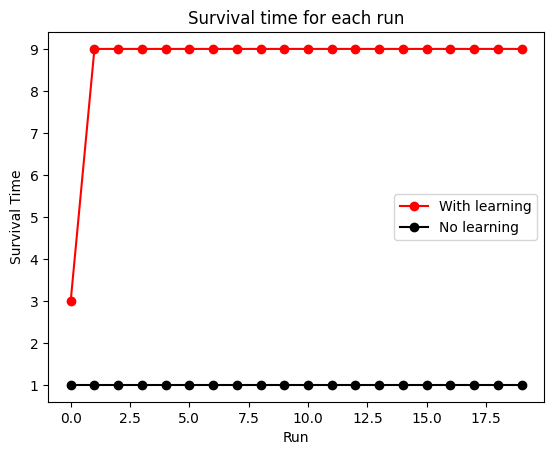

In [ ]:
plt.figure()
plt.plot(survival_time_with_learning,"ro-", label="With learning")
plt.plot(survival_time_no_learning,"ko-", label="No learning")
plt.title("Survival time for each run")
plt.xlabel("Run")
plt.ylabel("Survival Time")
plt.legend()
plt.show()